In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [4]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [5]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers                    

In [6]:
tqdm = partial(tqdm, position=0, leave=True)

In [7]:
files_all=[]
for file in os.listdir("/content/drive/My Drive/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/My Drive/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:int(len(files_all)/2)+1]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[int(len(files_all)/2):]:
  right_files_path.append(folder_path + file)

In [8]:
import multiprocessing
print(multiprocessing.cpu_count())

2


In [9]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC )
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


In [10]:
f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 3.9845659732818604 [s] ... size 740.974913 MB


In [11]:
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 6.256710052490234 [s] ... size 987.965868 MB


In [12]:
f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/all_images_bgr_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 10.991532564163208 [s] ... size 740.974913 MB


In [13]:
f=h5.File('drive/MyDrive/all_images_gray_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/all_images_gray_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 11.953744649887085 [s] ... size 987.965868 MB


In [14]:
del images_left_bgr,images_right_bgr

In [15]:

from timeit import default_timer as timer
time_all = []

In [16]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_freak = []
num_kps_gftt = []
num_kps_briefstar = []
num_kps_surf = []
num_kps_rootsift = []

In [17]:
Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  #points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  #points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


In [18]:
for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 208879.68it/s]


In [19]:
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [20]:
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [21]:
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [22]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [23]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [24]:
del Fdb, all_feat_brisk_left, all_feat_brisk_right

In [25]:
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [06:52<00:00,  8.26s/it]


In [26]:
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 21409.34it/s]


In [27]:
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [28]:
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [29]:
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [30]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [31]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [32]:
del Fdb, all_feat_kaze_left, all_feat_kaze_right

In [33]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [34]:
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [01:14<00:00,  1.48s/it]


In [35]:
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 226719.14it/s]


In [36]:
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [37]:
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [38]:
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [39]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [40]:
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [41]:
del Fdb, all_feat_akaze_left, all_feat_akaze_right

In [42]:
orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [00:15<00:00,  3.23it/s]


In [43]:
for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 198876.43it/s]


In [44]:
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [45]:
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [46]:
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [47]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [48]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [49]:
del Fdb, all_feat_orb_left, all_feat_orb_right

In [50]:
start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [00:12<00:00,  4.12it/s]


In [51]:
num_kps_star=[]
for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 30415.55it/s]


In [52]:
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [53]:
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [54]:
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [55]:
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [56]:
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [57]:
del Fdb, all_feat_star_left, all_feat_star_right

In [58]:
start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [00:53<00:00,  1.06s/it]


In [59]:
num_kps_freak=[]
for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 145939.60it/s]


In [60]:
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [61]:
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [62]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [67]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [68]:
del Fdb, all_feat_freak_left, all_feat_freak_right

In [69]:
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 60)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [02:43<00:00,  3.27s/it]


In [70]:
num_kps_agast=[]
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 67345.92it/s]


In [71]:
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [72]:
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [73]:
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [74]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [75]:
del Fdb, all_feat_agast_left

In [76]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [77]:
del Fdb, all_feat_agast_right

In [78]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [79]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [02:39<00:00,  3.20s/it]


In [80]:
num_kps_rootsift=[]
for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 324134.78it/s]


In [81]:
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [82]:
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [83]:
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [84]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [85]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [86]:
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

In [87]:
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [00:14<00:00,  3.57it/s]


In [88]:
num_kps_gftt=[]
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 295790.13it/s]


In [89]:
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [90]:
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [91]:
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [92]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [93]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [94]:
del Fdb, all_feat_gftt_left, all_feat_gftt_right

In [95]:
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [01:28<00:00,  1.77s/it]


In [96]:
num_kps_daisy=[]
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 38363.71it/s]


In [97]:
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [98]:
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [99]:
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [100]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [101]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [102]:
del Fdb, all_feat_daisy_left, all_feat_daisy_right

In [103]:
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


In [104]:
num_kps_sift=[]
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 244423.31it/s]


In [105]:
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [106]:
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [107]:
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [108]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [109]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [110]:
del Fdb, all_feat_sift_left, all_feat_sift_right

In [111]:
start = timer()

surf  = cv2.xfeatures2d.SURF_create()
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [06:48<00:00,  8.18s/it]


In [112]:
num_kps_surf=[]
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 33689.19it/s]


In [113]:
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [114]:
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [115]:
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [116]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [117]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [118]:
del Fdb, all_feat_surf_left, all_feat_surf_right

In [119]:
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 50/50 [05:48<00:00,  6.97s/it]


In [120]:
num_kps_mser=[]
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

100%|██████████| 100/100 [00:00<00:00, 28630.06it/s]


In [121]:
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [122]:
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [123]:
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [124]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [125]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [126]:
del Fdb, all_feat_mser_left, all_feat_mser_right

In [127]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [128]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [129]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [130]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [131]:
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [132]:
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [133]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  2%|▏         | 1/51 [00:06<05:16,  6.32s/it]


Number of matches 38377
Number of matches After Lowe's Ratio 1925
Number of Robust matches 1867




  4%|▍         | 2/51 [00:11<04:48,  5.90s/it]


Number of matches 39499
Number of matches After Lowe's Ratio 1919
Number of Robust matches 1741




  6%|▌         | 3/51 [00:16<04:41,  5.86s/it]


Number of matches 37350
Number of matches After Lowe's Ratio 1805
Number of Robust matches 1766




  8%|▊         | 4/51 [00:21<04:16,  5.46s/it]


Number of matches 35747
Number of matches After Lowe's Ratio 1798
Number of Robust matches 1609




 10%|▉         | 5/51 [00:25<03:53,  5.07s/it]


Number of matches 34127
Number of matches After Lowe's Ratio 1655
Number of Robust matches 1613




 12%|█▏        | 6/51 [00:30<03:39,  4.87s/it]


Number of matches 31692
Number of matches After Lowe's Ratio 1496
Number of Robust matches 1381




 14%|█▎        | 7/51 [00:33<03:18,  4.50s/it]


Number of matches 28986
Number of matches After Lowe's Ratio 1201
Number of Robust matches 1058




 16%|█▌        | 8/51 [00:36<02:55,  4.09s/it]


Number of matches 28823
Number of matches After Lowe's Ratio 1170
Number of Robust matches 897




 18%|█▊        | 9/51 [00:40<02:43,  3.89s/it]


Number of matches 26721
Number of matches After Lowe's Ratio 1150
Number of Robust matches 1132




 20%|█▉        | 10/51 [00:42<02:24,  3.53s/it]


Number of matches 27608
Number of matches After Lowe's Ratio 1138
Number of Robust matches 1119




 22%|██▏       | 11/51 [00:45<02:13,  3.34s/it]


Number of matches 27518
Number of matches After Lowe's Ratio 1156
Number of Robust matches 1029




 24%|██▎       | 12/51 [00:49<02:13,  3.43s/it]


Number of matches 28433
Number of matches After Lowe's Ratio 1197
Number of Robust matches 1005




 25%|██▌       | 13/51 [00:52<02:05,  3.30s/it]


Number of matches 26102
Number of matches After Lowe's Ratio 1005
Number of Robust matches 909




 27%|██▋       | 14/51 [00:55<01:55,  3.12s/it]


Number of matches 28894
Number of matches After Lowe's Ratio 863
Number of Robust matches 840




 29%|██▉       | 15/51 [00:58<01:51,  3.11s/it]


Number of matches 30125
Number of matches After Lowe's Ratio 58
Number of Robust matches 50




 31%|███▏      | 16/51 [01:02<01:57,  3.35s/it]


Number of matches 30185
Number of matches After Lowe's Ratio 2680
Number of Robust matches 1967




 33%|███▎      | 17/51 [01:05<01:51,  3.28s/it]


Number of matches 25802
Number of matches After Lowe's Ratio 1197
Number of Robust matches 1120




 35%|███▌      | 18/51 [01:07<01:41,  3.08s/it]


Number of matches 25870
Number of matches After Lowe's Ratio 1069
Number of Robust matches 977




 37%|███▋      | 19/51 [01:11<01:41,  3.18s/it]


Number of matches 27741
Number of matches After Lowe's Ratio 1100
Number of Robust matches 1087




 39%|███▉      | 20/51 [01:14<01:35,  3.09s/it]


Number of matches 25980
Number of matches After Lowe's Ratio 1201
Number of Robust matches 1136




 41%|████      | 21/51 [01:16<01:29,  2.97s/it]


Number of matches 26420
Number of matches After Lowe's Ratio 1260
Number of Robust matches 1178




 43%|████▎     | 22/51 [01:20<01:31,  3.15s/it]


Number of matches 30232
Number of matches After Lowe's Ratio 1266
Number of Robust matches 1117




 45%|████▌     | 23/51 [01:24<01:32,  3.30s/it]


Number of matches 30957
Number of matches After Lowe's Ratio 1423
Number of Robust matches 1406




 47%|████▋     | 24/51 [01:28<01:34,  3.51s/it]


Number of matches 33625
Number of matches After Lowe's Ratio 1618
Number of Robust matches 1604




 49%|████▉     | 25/51 [01:32<01:39,  3.82s/it]


Number of matches 36438
Number of matches After Lowe's Ratio 1877
Number of Robust matches 1436




 51%|█████     | 26/51 [01:37<01:42,  4.09s/it]


Number of matches 37330
Number of matches After Lowe's Ratio 1803
Number of Robust matches 1633




 53%|█████▎    | 27/51 [01:42<01:44,  4.36s/it]


Number of matches 38578
Number of matches After Lowe's Ratio 1995
Number of Robust matches 1804




 55%|█████▍    | 28/51 [01:48<01:50,  4.81s/it]


Number of matches 41159
Number of matches After Lowe's Ratio 1916
Number of Robust matches 1690




 57%|█████▋    | 29/51 [01:54<01:53,  5.17s/it]


Number of matches 39072
Number of matches After Lowe's Ratio 1652
Number of Robust matches 1589




 59%|█████▉    | 30/51 [02:00<01:57,  5.59s/it]


Number of matches 46117
Number of matches After Lowe's Ratio 1438
Number of Robust matches 1399




 61%|██████    | 31/51 [02:08<02:03,  6.19s/it]


Number of matches 49031
Number of matches After Lowe's Ratio 79
Number of Robust matches 64




 63%|██████▎   | 32/51 [02:16<02:06,  6.68s/it]


Number of matches 44393
Number of matches After Lowe's Ratio 3370
Number of Robust matches 3366




 65%|██████▍   | 33/51 [02:22<01:59,  6.66s/it]


Number of matches 42074
Number of matches After Lowe's Ratio 1922
Number of Robust matches 1704




 67%|██████▋   | 34/51 [02:29<01:51,  6.57s/it]


Number of matches 39716
Number of matches After Lowe's Ratio 1964
Number of Robust matches 1660




 69%|██████▊   | 35/51 [02:34<01:38,  6.15s/it]


Number of matches 37382
Number of matches After Lowe's Ratio 1762
Number of Robust matches 1418




 71%|███████   | 36/51 [02:39<01:28,  5.89s/it]


Number of matches 36166
Number of matches After Lowe's Ratio 1527
Number of Robust matches 1426




 73%|███████▎  | 37/51 [02:44<01:16,  5.47s/it]


Number of matches 35401
Number of matches After Lowe's Ratio 1535
Number of Robust matches 1520




 75%|███████▍  | 38/51 [02:48<01:06,  5.12s/it]


Number of matches 35752
Number of matches After Lowe's Ratio 1379
Number of Robust matches 1354




 76%|███████▋  | 39/51 [02:53<01:00,  5.03s/it]


Number of matches 33540
Number of matches After Lowe's Ratio 1163
Number of Robust matches 1007




 78%|███████▊  | 40/51 [02:57<00:51,  4.72s/it]


Number of matches 32424
Number of matches After Lowe's Ratio 1090
Number of Robust matches 1058




 80%|████████  | 41/51 [03:01<00:45,  4.52s/it]


Number of matches 37874
Number of matches After Lowe's Ratio 882
Number of Robust matches 765




 82%|████████▏ | 42/51 [03:06<00:42,  4.67s/it]


Number of matches 34672
Number of matches After Lowe's Ratio 107
Number of Robust matches 65




 84%|████████▍ | 43/51 [03:10<00:36,  4.51s/it]


Number of matches 34302
Number of matches After Lowe's Ratio 2621
Number of Robust matches 2602




 86%|████████▋ | 44/51 [03:14<00:31,  4.45s/it]


Number of matches 28224
Number of matches After Lowe's Ratio 1187
Number of Robust matches 1171




 88%|████████▊ | 45/51 [03:18<00:24,  4.10s/it]


Number of matches 31953
Number of matches After Lowe's Ratio 1156
Number of Robust matches 1129




 90%|█████████ | 46/51 [03:21<00:20,  4.02s/it]


Number of matches 33085
Number of matches After Lowe's Ratio 1348
Number of Robust matches 1299




 92%|█████████▏| 47/51 [03:26<00:16,  4.19s/it]


Number of matches 35882
Number of matches After Lowe's Ratio 1541
Number of Robust matches 1529




 94%|█████████▍| 48/51 [03:31<00:13,  4.39s/it]


Number of matches 41389
Number of matches After Lowe's Ratio 1447
Number of Robust matches 1260




 96%|█████████▌| 49/51 [03:36<00:09,  4.72s/it]


Number of matches 36865
Number of matches After Lowe's Ratio 207
Number of Robust matches 176




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 34808
Number of matches After Lowe's Ratio 2211
Number of Robust matches 2190




  2%|▏         | 1/50 [00:05<04:47,  5.86s/it]


Number of matches 42126
Number of matches After Lowe's Ratio 1813
Number of Robust matches 1782




  4%|▍         | 2/50 [00:13<05:01,  6.28s/it]


Number of matches 44902
Number of matches After Lowe's Ratio 1959
Number of Robust matches 1816




  6%|▌         | 3/50 [00:20<05:15,  6.72s/it]


Number of matches 49229
Number of matches After Lowe's Ratio 1837
Number of Robust matches 1806




  8%|▊         | 4/50 [00:29<05:37,  7.34s/it]


Number of matches 50748
Number of matches After Lowe's Ratio 1981
Number of Robust matches 1907




 10%|█         | 5/50 [00:38<05:53,  7.86s/it]


Number of matches 59732
Number of matches After Lowe's Ratio 3051
Number of Robust matches 2804




 12%|█▏        | 6/50 [00:48<06:08,  8.38s/it]


Number of matches 60160
Number of matches After Lowe's Ratio 118
Number of Robust matches 99




 14%|█▍        | 7/50 [00:58<06:27,  9.01s/it]


Number of matches 60333
Number of matches After Lowe's Ratio 1460
Number of Robust matches 1158




 16%|█▌        | 8/50 [01:08<06:25,  9.18s/it]


Number of matches 57353
Number of matches After Lowe's Ratio 1631
Number of Robust matches 1275




 18%|█▊        | 9/50 [01:17<06:20,  9.29s/it]


Number of matches 55677
Number of matches After Lowe's Ratio 1691
Number of Robust matches 1471




 20%|██        | 10/50 [01:27<06:12,  9.31s/it]


Number of matches 53956
Number of matches After Lowe's Ratio 1703
Number of Robust matches 1423




 22%|██▏       | 11/50 [01:36<05:59,  9.22s/it]


Number of matches 54452
Number of matches After Lowe's Ratio 1970
Number of Robust matches 1822




 24%|██▍       | 12/50 [01:44<05:40,  8.95s/it]


Number of matches 48940
Number of matches After Lowe's Ratio 2039
Number of Robust matches 1724




 26%|██▌       | 13/50 [01:52<05:18,  8.60s/it]


Number of matches 47194
Number of matches After Lowe's Ratio 1836
Number of Robust matches 1714




 28%|██▊       | 14/50 [01:59<04:55,  8.21s/it]


Number of matches 41380
Number of matches After Lowe's Ratio 2014
Number of Robust matches 1622




 30%|███       | 15/50 [02:05<04:24,  7.57s/it]


Number of matches 44346
Number of matches After Lowe's Ratio 1853
Number of Robust matches 1695




 32%|███▏      | 16/50 [02:12<04:12,  7.42s/it]


Number of matches 40464
Number of matches After Lowe's Ratio 1608
Number of Robust matches 1589




 34%|███▍      | 17/50 [02:18<03:46,  6.86s/it]


Number of matches 37867
Number of matches After Lowe's Ratio 1638
Number of Robust matches 1625




 36%|███▌      | 18/50 [02:23<03:20,  6.26s/it]


Number of matches 35389
Number of matches After Lowe's Ratio 1444
Number of Robust matches 1428




 38%|███▊      | 19/50 [02:28<03:00,  5.83s/it]


Number of matches 32892
Number of matches After Lowe's Ratio 1326
Number of Robust matches 1304




 40%|████      | 20/50 [02:32<02:37,  5.26s/it]


Number of matches 32656
Number of matches After Lowe's Ratio 1191
Number of Robust matches 1170




 42%|████▏     | 21/50 [02:35<02:17,  4.73s/it]


Number of matches 29010
Number of matches After Lowe's Ratio 1151
Number of Robust matches 1022




 44%|████▍     | 22/50 [02:39<02:05,  4.48s/it]


Number of matches 27352
Number of matches After Lowe's Ratio 1090
Number of Robust matches 1073




 46%|████▌     | 23/50 [02:42<01:48,  4.01s/it]


Number of matches 25731
Number of matches After Lowe's Ratio 963
Number of Robust matches 950




 48%|████▊     | 24/50 [02:44<01:33,  3.60s/it]


Number of matches 25879
Number of matches After Lowe's Ratio 1133
Number of Robust matches 1095




 50%|█████     | 25/50 [02:48<01:27,  3.51s/it]


Number of matches 24859
Number of matches After Lowe's Ratio 1084
Number of Robust matches 1042




 52%|█████▏    | 26/50 [02:50<01:17,  3.22s/it]


Number of matches 24971
Number of matches After Lowe's Ratio 1065
Number of Robust matches 1025




 54%|█████▍    | 27/50 [02:53<01:09,  3.03s/it]


Number of matches 25611
Number of matches After Lowe's Ratio 1151
Number of Robust matches 1046




 56%|█████▌    | 28/50 [02:55<01:03,  2.87s/it]


Number of matches 22090
Number of matches After Lowe's Ratio 1060
Number of Robust matches 892




 58%|█████▊    | 29/50 [02:58<00:59,  2.85s/it]


Number of matches 23131
Number of matches After Lowe's Ratio 1222
Number of Robust matches 1170




 60%|██████    | 30/50 [03:00<00:53,  2.68s/it]


Number of matches 24081
Number of matches After Lowe's Ratio 2300
Number of Robust matches 2273




 62%|██████▏   | 31/50 [03:03<00:49,  2.62s/it]


Number of matches 27200
Number of matches After Lowe's Ratio 113
Number of Robust matches 105




 64%|██████▍   | 32/50 [03:06<00:48,  2.68s/it]


Number of matches 23490
Number of matches After Lowe's Ratio 1387
Number of Robust matches 1370




 66%|██████▌   | 33/50 [03:09<00:45,  2.70s/it]


Number of matches 23414
Number of matches After Lowe's Ratio 1420
Number of Robust matches 1214




 68%|██████▊   | 34/50 [03:11<00:42,  2.64s/it]


Number of matches 23735
Number of matches After Lowe's Ratio 1478
Number of Robust matches 1368




 70%|███████   | 35/50 [03:13<00:38,  2.56s/it]


Number of matches 23963
Number of matches After Lowe's Ratio 1318
Number of Robust matches 1223




 72%|███████▏  | 36/50 [03:16<00:35,  2.53s/it]


Number of matches 24774
Number of matches After Lowe's Ratio 1317
Number of Robust matches 1293




 74%|███████▍  | 37/50 [03:19<00:35,  2.72s/it]


Number of matches 25854
Number of matches After Lowe's Ratio 1024
Number of Robust matches 977




 76%|███████▌  | 38/50 [03:22<00:33,  2.75s/it]


Number of matches 28455
Number of matches After Lowe's Ratio 1170
Number of Robust matches 1011




 78%|███████▊  | 39/50 [03:25<00:31,  2.90s/it]


Number of matches 31213
Number of matches After Lowe's Ratio 1297
Number of Robust matches 1219




 80%|████████  | 40/50 [03:29<00:33,  3.35s/it]


Number of matches 32573
Number of matches After Lowe's Ratio 1341
Number of Robust matches 1321




 82%|████████▏ | 41/50 [03:33<00:31,  3.54s/it]


Number of matches 35428
Number of matches After Lowe's Ratio 1302
Number of Robust matches 1283




 84%|████████▍ | 42/50 [03:38<00:30,  3.83s/it]


Number of matches 36398
Number of matches After Lowe's Ratio 1704
Number of Robust matches 1670




 86%|████████▌ | 43/50 [03:43<00:30,  4.29s/it]


Number of matches 35516
Number of matches After Lowe's Ratio 1490
Number of Robust matches 1453




 88%|████████▊ | 44/50 [03:48<00:26,  4.42s/it]


Number of matches 38135
Number of matches After Lowe's Ratio 1486
Number of Robust matches 1466




 90%|█████████ | 45/50 [03:54<00:23,  4.78s/it]


Number of matches 40907
Number of matches After Lowe's Ratio 1568
Number of Robust matches 1150




 92%|█████████▏| 46/50 [04:00<00:20,  5.23s/it]


Number of matches 45834
Number of matches After Lowe's Ratio 1955
Number of Robust matches 1808




 94%|█████████▍| 47/50 [04:08<00:18,  6.14s/it]


Number of matches 51125
Number of matches After Lowe's Ratio 1993
Number of Robust matches 1859




 96%|█████████▌| 48/50 [04:17<00:13,  6.94s/it]


Number of matches 53354
Number of matches After Lowe's Ratio 2151
Number of Robust matches 2036




 98%|█████████▊| 49/50 [04:27<00:07,  7.88s/it]


Number of matches 62095
Number of matches After Lowe's Ratio 2077
Number of Robust matches 1794




In [134]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.01282501220703125 [s] ... size 0.005648 MB


In [135]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.012619495391845703 [s] ... size 0.005576 MB


In [136]:
del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [137]:
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [138]:
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [139]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1])
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1])
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

  2%|▏         | 1/51 [00:13<11:28, 13.77s/it]


Number of matches 31720
Number of matches After Lowe's Ratio 6018
Number of Robust matches 5970




  4%|▍         | 2/51 [00:22<09:58, 12.21s/it]


Number of matches 30987
Number of matches After Lowe's Ratio 6107
Number of Robust matches 5885




  6%|▌         | 3/51 [00:31<08:58, 11.22s/it]


Number of matches 31608
Number of matches After Lowe's Ratio 6213
Number of Robust matches 6162




  8%|▊         | 4/51 [00:37<07:40,  9.80s/it]


Number of matches 30842
Number of matches After Lowe's Ratio 6340
Number of Robust matches 5464




 10%|▉         | 5/51 [00:44<06:51,  8.95s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 6322
Number of Robust matches 6275




 12%|█▏        | 6/51 [00:51<06:11,  8.26s/it]


Number of matches 29287
Number of matches After Lowe's Ratio 5992
Number of Robust matches 5904




 14%|█▎        | 7/51 [00:57<05:29,  7.48s/it]


Number of matches 29464
Number of matches After Lowe's Ratio 5528
Number of Robust matches 5237




 16%|█▌        | 8/51 [01:03<05:06,  7.13s/it]


Number of matches 28828
Number of matches After Lowe's Ratio 5475
Number of Robust matches 5417




 18%|█▊        | 9/51 [01:09<04:43,  6.76s/it]


Number of matches 28928
Number of matches After Lowe's Ratio 5582
Number of Robust matches 5534




 20%|█▉        | 10/51 [01:15<04:33,  6.67s/it]


Number of matches 29180
Number of matches After Lowe's Ratio 5483
Number of Robust matches 5189




 22%|██▏       | 11/51 [01:21<04:17,  6.43s/it]


Number of matches 29555
Number of matches After Lowe's Ratio 5503
Number of Robust matches 5432




 24%|██▎       | 12/51 [01:27<04:06,  6.33s/it]


Number of matches 29347
Number of matches After Lowe's Ratio 5563
Number of Robust matches 5486




 25%|██▌       | 13/51 [01:33<03:59,  6.30s/it]


Number of matches 28833
Number of matches After Lowe's Ratio 5278
Number of Robust matches 5185




 27%|██▋       | 14/51 [01:39<03:45,  6.11s/it]


Number of matches 26650
Number of matches After Lowe's Ratio 4701
Number of Robust matches 4604




 29%|██▉       | 15/51 [01:44<03:29,  5.83s/it]


Number of matches 26375
Number of matches After Lowe's Ratio 536
Number of Robust matches 446




 31%|███▏      | 16/51 [01:50<03:21,  5.76s/it]


Number of matches 26217
Number of matches After Lowe's Ratio 8696
Number of Robust matches 8672




 33%|███▎      | 17/51 [01:55<03:09,  5.58s/it]


Number of matches 28269
Number of matches After Lowe's Ratio 5453
Number of Robust matches 5391



Number of matches 28450
Number of matches After Lowe's Ratio 5542


 35%|███▌      | 18/51 [02:02<03:14,  5.91s/it]

Number of Robust matches 5490




 37%|███▋      | 19/51 [02:07<03:06,  5.83s/it]


Number of matches 27950
Number of matches After Lowe's Ratio 5208
Number of Robust matches 5159




 39%|███▉      | 20/51 [02:13<03:04,  5.94s/it]


Number of matches 29131
Number of matches After Lowe's Ratio 5678
Number of Robust matches 5616




 41%|████      | 21/51 [02:20<03:04,  6.16s/it]


Number of matches 29473
Number of matches After Lowe's Ratio 5815
Number of Robust matches 5747




 43%|████▎     | 22/51 [02:26<02:58,  6.15s/it]


Number of matches 29749
Number of matches After Lowe's Ratio 6049
Number of Robust matches 5996



Number of matches 30317
Number of matches After Lowe's Ratio 6826


 45%|████▌     | 23/51 [02:34<03:01,  6.48s/it]

Number of Robust matches 6779




 47%|████▋     | 24/51 [02:40<02:56,  6.52s/it]


Number of matches 30355
Number of matches After Lowe's Ratio 6585
Number of Robust matches 6413




 49%|████▉     | 25/51 [02:47<02:48,  6.47s/it]


Number of matches 29960
Number of matches After Lowe's Ratio 6638
Number of Robust matches 6567




 51%|█████     | 26/51 [02:53<02:44,  6.57s/it]


Number of matches 30982
Number of matches After Lowe's Ratio 6264
Number of Robust matches 6222




 53%|█████▎    | 27/51 [03:00<02:39,  6.64s/it]


Number of matches 31086
Number of matches After Lowe's Ratio 6877
Number of Robust matches 6319




 55%|█████▍    | 28/51 [03:07<02:35,  6.76s/it]


Number of matches 30087
Number of matches After Lowe's Ratio 6389
Number of Robust matches 6336




 57%|█████▋    | 29/51 [03:14<02:26,  6.64s/it]


Number of matches 30677
Number of matches After Lowe's Ratio 6020
Number of Robust matches 5727




 59%|█████▉    | 30/51 [03:20<02:19,  6.65s/it]


Number of matches 28048
Number of matches After Lowe's Ratio 5598
Number of Robust matches 5552




 61%|██████    | 31/51 [03:26<02:10,  6.51s/it]


Number of matches 29941
Number of matches After Lowe's Ratio 630
Number of Robust matches 535




 63%|██████▎   | 32/51 [03:33<02:02,  6.47s/it]


Number of matches 31140
Number of matches After Lowe's Ratio 9182
Number of Robust matches 9125




 65%|██████▍   | 33/51 [03:40<01:59,  6.61s/it]


Number of matches 30962
Number of matches After Lowe's Ratio 6546
Number of Robust matches 6499




 67%|██████▋   | 34/51 [03:47<01:54,  6.74s/it]


Number of matches 31238
Number of matches After Lowe's Ratio 6858
Number of Robust matches 6082



Number of matches 31209
Number of matches After Lowe's Ratio 6641


 69%|██████▊   | 35/51 [03:54<01:50,  6.92s/it]

Number of Robust matches 6527




 71%|███████   | 36/51 [04:01<01:41,  6.79s/it]


Number of matches 30406
Number of matches After Lowe's Ratio 6361
Number of Robust matches 6321




 73%|███████▎  | 37/51 [04:07<01:32,  6.64s/it]


Number of matches 30526
Number of matches After Lowe's Ratio 6158
Number of Robust matches 6109




 75%|███████▍  | 38/51 [04:14<01:26,  6.68s/it]


Number of matches 29802
Number of matches After Lowe's Ratio 5892
Number of Robust matches 5852




 76%|███████▋  | 39/51 [04:20<01:18,  6.54s/it]


Number of matches 28772
Number of matches After Lowe's Ratio 5147
Number of Robust matches 5089



Number of matches 27397
Number of matches After Lowe's Ratio 4980


 78%|███████▊  | 40/51 [04:27<01:12,  6.62s/it]

Number of Robust matches 4879




 80%|████████  | 41/51 [04:32<01:01,  6.20s/it]


Number of matches 25194
Number of matches After Lowe's Ratio 4133
Number of Robust matches 4063




 82%|████████▏ | 42/51 [04:37<00:51,  5.74s/it]


Number of matches 24963
Number of matches After Lowe's Ratio 709
Number of Robust matches 539



Number of matches 24837
Number of matches After Lowe's Ratio 8099


 84%|████████▍ | 43/51 [04:42<00:46,  5.78s/it]

Number of Robust matches 8075




 86%|████████▋ | 44/51 [04:47<00:38,  5.56s/it]


Number of matches 27931
Number of matches After Lowe's Ratio 5418
Number of Robust matches 5367




 88%|████████▊ | 45/51 [04:53<00:34,  5.69s/it]


Number of matches 28524
Number of matches After Lowe's Ratio 5640
Number of Robust matches 5559




 90%|█████████ | 46/51 [05:00<00:29,  5.95s/it]


Number of matches 30164
Number of matches After Lowe's Ratio 5982
Number of Robust matches 5929




 92%|█████████▏| 47/51 [05:06<00:24,  6.06s/it]


Number of matches 31071
Number of matches After Lowe's Ratio 6294
Number of Robust matches 6244




 94%|█████████▍| 48/51 [05:14<00:19,  6.41s/it]


Number of matches 29798
Number of matches After Lowe's Ratio 6235
Number of Robust matches 6182




 96%|█████████▌| 49/51 [05:20<00:12,  6.45s/it]


Number of matches 27343
Number of matches After Lowe's Ratio 1294
Number of Robust matches 1221




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 26621
Number of matches After Lowe's Ratio 7455
Number of Robust matches 7269




  2%|▏         | 1/50 [00:07<05:51,  7.17s/it]


Number of matches 32078
Number of matches After Lowe's Ratio 6131
Number of Robust matches 5857




  4%|▍         | 2/50 [00:14<05:46,  7.21s/it]


Number of matches 31532
Number of matches After Lowe's Ratio 6413
Number of Robust matches 5977




  6%|▌         | 3/50 [00:21<05:39,  7.22s/it]


Number of matches 31188
Number of matches After Lowe's Ratio 6056
Number of Robust matches 5556




  8%|▊         | 4/50 [00:28<05:30,  7.18s/it]


Number of matches 32924
Number of matches After Lowe's Ratio 5755
Number of Robust matches 5075




 10%|█         | 5/50 [00:36<05:33,  7.41s/it]


Number of matches 31255
Number of matches After Lowe's Ratio 8517
Number of Robust matches 7594




 12%|█▏        | 6/50 [00:43<05:18,  7.25s/it]


Number of matches 30493
Number of matches After Lowe's Ratio 803
Number of Robust matches 732




 14%|█▍        | 7/50 [00:49<04:59,  6.97s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 5273
Number of Robust matches 4700



Number of matches 32012
Number of matches After Lowe's Ratio 5311


 16%|█▌        | 8/50 [00:57<04:58,  7.10s/it]

Number of Robust matches 4804




 18%|█▊        | 9/50 [01:04<04:47,  7.00s/it]


Number of matches 31671
Number of matches After Lowe's Ratio 5447
Number of Robust matches 4843




 20%|██        | 10/50 [01:10<04:37,  6.93s/it]


Number of matches 32050
Number of matches After Lowe's Ratio 5559
Number of Robust matches 4529




 22%|██▏       | 11/50 [01:18<04:38,  7.15s/it]


Number of matches 31915
Number of matches After Lowe's Ratio 6145
Number of Robust matches 5929




 24%|██▍       | 12/50 [01:25<04:27,  7.04s/it]


Number of matches 32910
Number of matches After Lowe's Ratio 6075
Number of Robust matches 5322




 26%|██▌       | 13/50 [01:32<04:25,  7.18s/it]


Number of matches 32524
Number of matches After Lowe's Ratio 6278
Number of Robust matches 6181




 28%|██▊       | 14/50 [01:39<04:16,  7.11s/it]


Number of matches 34633
Number of matches After Lowe's Ratio 6434
Number of Robust matches 6152



Number of matches 31744
Number of matches After Lowe's Ratio 6482


 30%|███       | 15/50 [01:47<04:15,  7.30s/it]

Number of Robust matches 6057




 32%|███▏      | 16/50 [01:55<04:10,  7.35s/it]


Number of matches 31633
Number of matches After Lowe's Ratio 6119
Number of Robust matches 6041




 34%|███▍      | 17/50 [02:01<03:55,  7.15s/it]


Number of matches 31817
Number of matches After Lowe's Ratio 5956
Number of Robust matches 5390




 36%|███▌      | 18/50 [02:09<03:52,  7.26s/it]


Number of matches 30716
Number of matches After Lowe's Ratio 5618
Number of Robust matches 5534




 38%|███▊      | 19/50 [02:15<03:36,  7.00s/it]


Number of matches 30204
Number of matches After Lowe's Ratio 5565
Number of Robust matches 5496




 40%|████      | 20/50 [02:22<03:29,  7.00s/it]


Number of matches 29900
Number of matches After Lowe's Ratio 5304
Number of Robust matches 5220




 42%|████▏     | 21/50 [02:28<03:16,  6.76s/it]


Number of matches 30063
Number of matches After Lowe's Ratio 5409
Number of Robust matches 5331




 44%|████▍     | 22/50 [02:35<03:04,  6.59s/it]


Number of matches 29795
Number of matches After Lowe's Ratio 5356
Number of Robust matches 5297




 46%|████▌     | 23/50 [02:41<02:59,  6.66s/it]


Number of matches 29962
Number of matches After Lowe's Ratio 5422
Number of Robust matches 5182




 48%|████▊     | 24/50 [02:47<02:48,  6.48s/it]


Number of matches 29779
Number of matches After Lowe's Ratio 5730
Number of Robust matches 5689




 50%|█████     | 25/50 [02:54<02:42,  6.52s/it]


Number of matches 29784
Number of matches After Lowe's Ratio 5731
Number of Robust matches 5634




 52%|█████▏    | 26/50 [03:00<02:34,  6.45s/it]


Number of matches 29677
Number of matches After Lowe's Ratio 5923
Number of Robust matches 5818




 54%|█████▍    | 27/50 [03:07<02:27,  6.40s/it]


Number of matches 29264
Number of matches After Lowe's Ratio 5931
Number of Robust matches 5804




 56%|█████▌    | 28/50 [03:13<02:21,  6.45s/it]


Number of matches 29210
Number of matches After Lowe's Ratio 5923
Number of Robust matches 5834




 58%|█████▊    | 29/50 [03:19<02:12,  6.31s/it]


Number of matches 27231
Number of matches After Lowe's Ratio 6561
Number of Robust matches 6465



Number of matches 26418
Number of matches After Lowe's Ratio 9383


 60%|██████    | 30/50 [03:25<02:04,  6.22s/it]

Number of Robust matches 9349




 62%|██████▏   | 31/50 [03:30<01:51,  5.88s/it]


Number of matches 26759
Number of matches After Lowe's Ratio 905
Number of Robust matches 838




 64%|██████▍   | 32/50 [03:36<01:44,  5.82s/it]


Number of matches 28676
Number of matches After Lowe's Ratio 5882
Number of Robust matches 5840




 66%|██████▌   | 33/50 [03:42<01:42,  6.02s/it]


Number of matches 30646
Number of matches After Lowe's Ratio 6887
Number of Robust matches 6823




 68%|██████▊   | 34/50 [03:49<01:37,  6.12s/it]


Number of matches 31486
Number of matches After Lowe's Ratio 7307
Number of Robust matches 7238




 70%|███████   | 35/50 [03:56<01:37,  6.48s/it]


Number of matches 31525
Number of matches After Lowe's Ratio 7047
Number of Robust matches 6985




 72%|███████▏  | 36/50 [04:03<01:31,  6.51s/it]


Number of matches 31466
Number of matches After Lowe's Ratio 7038
Number of Robust matches 6563



Number of matches 31084
Number of matches After Lowe's Ratio 6559


 74%|███████▍  | 37/50 [04:10<01:26,  6.62s/it]

Number of Robust matches 6493




 76%|███████▌  | 38/50 [04:16<01:19,  6.59s/it]


Number of matches 31084
Number of matches After Lowe's Ratio 6300
Number of Robust matches 6236




 78%|███████▊  | 39/50 [04:23<01:12,  6.62s/it]


Number of matches 30520
Number of matches After Lowe's Ratio 6197
Number of Robust matches 6032




 80%|████████  | 40/50 [04:30<01:07,  6.72s/it]


Number of matches 30960
Number of matches After Lowe's Ratio 5652
Number of Robust matches 5617




 82%|████████▏ | 41/50 [04:37<01:01,  6.80s/it]


Number of matches 31577
Number of matches After Lowe's Ratio 5423
Number of Robust matches 5196




 84%|████████▍ | 42/50 [04:44<00:55,  6.95s/it]


Number of matches 32620
Number of matches After Lowe's Ratio 6428
Number of Robust matches 5692




 86%|████████▌ | 43/50 [04:51<00:48,  6.99s/it]


Number of matches 32493
Number of matches After Lowe's Ratio 5946
Number of Robust matches 5834




 88%|████████▊ | 44/50 [04:58<00:41,  6.99s/it]


Number of matches 31882
Number of matches After Lowe's Ratio 5466
Number of Robust matches 4221




 90%|█████████ | 45/50 [05:05<00:35,  7.07s/it]


Number of matches 33021
Number of matches After Lowe's Ratio 5650
Number of Robust matches 5412




 92%|█████████▏| 46/50 [05:13<00:28,  7.20s/it]


Number of matches 33477
Number of matches After Lowe's Ratio 6247
Number of Robust matches 6176




 94%|█████████▍| 47/50 [05:20<00:21,  7.32s/it]


Number of matches 34090
Number of matches After Lowe's Ratio 6407
Number of Robust matches 6299




 96%|█████████▌| 48/50 [05:29<00:15,  7.71s/it]


Number of matches 35498
Number of matches After Lowe's Ratio 6748
Number of Robust matches 6333




 98%|█████████▊| 49/50 [05:37<00:07,  7.86s/it]


Number of matches 34443
Number of matches After Lowe's Ratio 6691
Number of Robust matches 6541




In [140]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00593876838684082 [s] ... size 0.005648 MB


In [141]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.012937545776367188 [s] ... size 0.005576 MB


In [142]:
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [143]:
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [144]:
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [145]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  2%|▏         | 1/51 [00:01<00:53,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1210
Number of Robust matches 1129




  4%|▍         | 2/51 [00:02<00:53,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1087
Number of Robust matches 796




  6%|▌         | 3/51 [00:03<00:51,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 920
Number of Robust matches 838




  8%|▊         | 4/51 [00:04<00:50,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1089
Number of Robust matches 1016




 10%|▉         | 5/51 [00:05<00:54,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1082
Number of Robust matches 901




 12%|█▏        | 6/51 [00:06<00:51,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 879
Number of Robust matches 795




 14%|█▎        | 7/51 [00:07<00:49,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 766
Number of Robust matches 629




 16%|█▌        | 8/51 [00:08<00:47,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 804
Number of Robust matches 688




 18%|█▊        | 9/51 [00:10<00:45,  1.09s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 827
Number of Robust matches 704




 20%|█▉        | 10/51 [00:11<00:48,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 798
Number of Robust matches 708




 22%|██▏       | 11/51 [00:12<00:45,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 861
Number of Robust matches 735




 24%|██▎       | 12/51 [00:13<00:44,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 748
Number of Robust matches 630




 25%|██▌       | 13/51 [00:14<00:42,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 653
Number of Robust matches 487




 27%|██▋       | 14/51 [00:16<00:46,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 563
Number of Robust matches 417




 29%|██▉       | 15/51 [00:17<00:43,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 103
Number of Robust matches 27




 31%|███▏      | 16/51 [00:18<00:41,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1962
Number of Robust matches 1880




 33%|███▎      | 17/51 [00:19<00:39,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1029
Number of Robust matches 916




 35%|███▌      | 18/51 [00:20<00:37,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 891
Number of Robust matches 799




 37%|███▋      | 19/51 [00:22<00:40,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 841
Number of Robust matches 761




 39%|███▉      | 20/51 [00:23<00:37,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 965
Number of Robust matches 882




 41%|████      | 21/51 [00:24<00:35,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 868
Number of Robust matches 799




 43%|████▎     | 22/51 [00:25<00:33,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 835
Number of Robust matches 729




 45%|████▌     | 23/51 [00:26<00:31,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 904
Number of Robust matches 838




 47%|████▋     | 24/51 [00:27<00:32,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 967
Number of Robust matches 781




 49%|████▉     | 25/51 [00:29<00:30,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1012
Number of Robust matches 866




 51%|█████     | 26/51 [00:30<00:28,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1020
Number of Robust matches 913




 53%|█████▎    | 27/51 [00:31<00:27,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1073
Number of Robust matches 923




 55%|█████▍    | 28/51 [00:32<00:29,  1.28s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1019
Number of Robust matches 892




 57%|█████▋    | 29/51 [00:34<00:27,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 942
Number of Robust matches 877




 59%|█████▉    | 30/51 [00:35<00:25,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 803
Number of Robust matches 699




 61%|██████    | 31/51 [00:36<00:24,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 57
Number of Robust matches 11


Number of matches After Lowe's Ratio New 1564
Number of Robust matches New 7




 63%|██████▎   | 32/51 [00:37<00:22,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1449
Number of Robust matches 1369




 65%|██████▍   | 33/51 [00:39<00:23,  1.32s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 990
Number of Robust matches 941




 67%|██████▋   | 34/51 [00:40<00:21,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1083
Number of Robust matches 954




 69%|██████▊   | 35/51 [00:41<00:19,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 979
Number of Robust matches 912




 71%|███████   | 36/51 [00:42<00:17,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 918
Number of Robust matches 847




 73%|███████▎  | 37/51 [00:43<00:16,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 935
Number of Robust matches 785




 75%|███████▍  | 38/51 [00:45<00:16,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 894
Number of Robust matches 782




 76%|███████▋  | 39/51 [00:46<00:14,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 708
Number of Robust matches 640




 78%|███████▊  | 40/51 [00:47<00:13,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 799
Number of Robust matches 620




 80%|████████  | 41/51 [00:48<00:12,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 674
Number of Robust matches 530




 82%|████████▏ | 42/51 [00:50<00:12,  1.35s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 164
Number of Robust matches 46




 84%|████████▍ | 43/51 [00:51<00:10,  1.28s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 2244
Number of Robust matches 2116




 86%|████████▋ | 44/51 [00:52<00:08,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1048
Number of Robust matches 979




 88%|████████▊ | 45/51 [00:53<00:07,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 968
Number of Robust matches 889




 90%|█████████ | 46/51 [00:54<00:05,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 973
Number of Robust matches 851




 92%|█████████▏| 47/51 [00:56<00:04,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 933
Number of Robust matches 857




 94%|█████████▍| 48/51 [00:57<00:03,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 715
Number of Robust matches 638




 96%|█████████▌| 49/51 [00:58<00:02,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 166
Number of Robust matches 88




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 1265
Number of Robust matches 1178




  2%|▏         | 1/50 [00:01<00:54,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 956
Number of Robust matches 820




  4%|▍         | 2/50 [00:02<00:57,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 915
Number of Robust matches 779




  6%|▌         | 3/50 [00:03<00:55,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 815
Number of Robust matches 685




  8%|▊         | 4/50 [00:04<00:53,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 628
Number of Robust matches 511




 10%|█         | 5/50 [00:05<00:52,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 880
Number of Robust matches 629




 12%|█▏        | 6/50 [00:07<00:52,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 65
Number of Robust matches 8


Number of matches After Lowe's Ratio New 1563
Number of Robust matches New 7




 14%|█▍        | 7/50 [00:08<00:55,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 153
Number of Robust matches 49




 16%|█▌        | 8/50 [00:09<00:51,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 248
Number of Robust matches 107




 18%|█▊        | 9/50 [00:10<00:49,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 322
Number of Robust matches 205




 20%|██        | 10/50 [00:12<00:46,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 425
Number of Robust matches 285




 22%|██▏       | 11/50 [00:13<00:50,  1.29s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 523
Number of Robust matches 434




 24%|██▍       | 12/50 [00:14<00:47,  1.24s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 664
Number of Robust matches 558




 26%|██▌       | 13/50 [00:15<00:44,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 643
Number of Robust matches 566




 28%|██▊       | 14/50 [00:16<00:42,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 758
Number of Robust matches 519




 30%|███       | 15/50 [00:18<00:40,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 806
Number of Robust matches 717




 32%|███▏      | 16/50 [00:19<00:44,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 677
Number of Robust matches 604




 34%|███▍      | 17/50 [00:20<00:41,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 840
Number of Robust matches 764




 36%|███▌      | 18/50 [00:22<00:39,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 837
Number of Robust matches 740




 38%|███▊      | 19/50 [00:23<00:36,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 872
Number of Robust matches 792




 40%|████      | 20/50 [00:24<00:35,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 802
Number of Robust matches 694




 42%|████▏     | 21/50 [00:25<00:36,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 798
Number of Robust matches 682




 44%|████▍     | 22/50 [00:26<00:34,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 735
Number of Robust matches 632




 46%|████▌     | 23/50 [00:27<00:32,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 775
Number of Robust matches 654




 48%|████▊     | 24/50 [00:29<00:30,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 806
Number of Robust matches 633




 50%|█████     | 25/50 [00:30<00:32,  1.31s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 755
Number of Robust matches 613




 52%|█████▏    | 26/50 [00:31<00:30,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 718
Number of Robust matches 599




 54%|█████▍    | 27/50 [00:33<00:27,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 732
Number of Robust matches 617




 56%|█████▌    | 28/50 [00:34<00:26,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 834
Number of Robust matches 730




 58%|█████▊    | 29/50 [00:35<00:24,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 953
Number of Robust matches 795




 60%|██████    | 30/50 [00:36<00:26,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1857
Number of Robust matches 1784




 62%|██████▏   | 31/50 [00:38<00:24,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 143
Number of Robust matches 66




 64%|██████▍   | 32/50 [00:39<00:22,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 994
Number of Robust matches 781




 66%|██████▌   | 33/50 [00:40<00:20,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1220
Number of Robust matches 1142




 68%|██████▊   | 34/50 [00:41<00:18,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1184
Number of Robust matches 1055




 70%|███████   | 35/50 [00:43<00:19,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1016
Number of Robust matches 910




 72%|███████▏  | 36/50 [00:44<00:17,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 982
Number of Robust matches 913




 74%|███████▍  | 37/50 [00:45<00:15,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 777
Number of Robust matches 672




 76%|███████▌  | 38/50 [00:46<00:14,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 754
Number of Robust matches 648




 78%|███████▊  | 39/50 [00:47<00:13,  1.27s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 843
Number of Robust matches 752




 80%|████████  | 40/50 [00:49<00:12,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 852
Number of Robust matches 732




 82%|████████▏ | 41/50 [00:50<00:10,  1.20s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 818
Number of Robust matches 746




 84%|████████▍ | 42/50 [00:51<00:09,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 979
Number of Robust matches 857




 86%|████████▌ | 43/50 [00:52<00:08,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 787
Number of Robust matches 701




 88%|████████▊ | 44/50 [00:54<00:07,  1.30s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 831
Number of Robust matches 693




 90%|█████████ | 45/50 [00:55<00:06,  1.25s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 745
Number of Robust matches 617




 92%|█████████▏| 46/50 [00:56<00:04,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 767
Number of Robust matches 679




 94%|█████████▍| 47/50 [00:57<00:03,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 741
Number of Robust matches 629




 96%|█████████▌| 48/50 [00:58<00:02,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 662
Number of Robust matches 565




 98%|█████████▊| 49/50 [01:00<00:01,  1.26s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 581
Number of Robust matches 439




In [146]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.01082301139831543 [s] ... size 0.005648 MB


In [147]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00996708869934082 [s] ... size 0.005576 MB


In [148]:
del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [149]:
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [150]:
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [151]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

  2%|▏         | 1/51 [00:01<01:37,  1.95s/it]


Number of matches 18514
Number of matches After Lowe's Ratio 8104
Number of Robust matches 7992




  4%|▍         | 2/51 [00:03<01:33,  1.91s/it]


Number of matches 18327
Number of matches After Lowe's Ratio 8043
Number of Robust matches 7425




  6%|▌         | 3/51 [00:05<01:36,  2.00s/it]


Number of matches 18360
Number of matches After Lowe's Ratio 7509
Number of Robust matches 7310




  8%|▊         | 4/51 [00:07<01:32,  1.96s/it]


Number of matches 17735
Number of matches After Lowe's Ratio 7684
Number of Robust matches 7570




 10%|▉         | 5/51 [00:09<01:27,  1.90s/it]


Number of matches 17379
Number of matches After Lowe's Ratio 7520
Number of Robust matches 7343




 12%|█▏        | 6/51 [00:11<01:28,  1.97s/it]


Number of matches 15782
Number of matches After Lowe's Ratio 6808
Number of Robust matches 6209




 14%|█▎        | 7/51 [00:13<01:18,  1.78s/it]


Number of matches 15115
Number of matches After Lowe's Ratio 5974
Number of Robust matches 5771




 16%|█▌        | 8/51 [00:14<01:10,  1.65s/it]


Number of matches 14464
Number of matches After Lowe's Ratio 5748
Number of Robust matches 5243




 18%|█▊        | 9/51 [00:15<01:04,  1.54s/it]


Number of matches 14208
Number of matches After Lowe's Ratio 5676
Number of Robust matches 5541




 20%|█▉        | 10/51 [00:17<01:04,  1.56s/it]


Number of matches 14814
Number of matches After Lowe's Ratio 5888
Number of Robust matches 5639




 22%|██▏       | 11/51 [00:18<00:59,  1.48s/it]


Number of matches 15056
Number of matches After Lowe's Ratio 6208
Number of Robust matches 6022




 24%|██▎       | 12/51 [00:19<00:55,  1.43s/it]


Number of matches 15156
Number of matches After Lowe's Ratio 6207
Number of Robust matches 5769




 25%|██▌       | 13/51 [00:21<00:53,  1.40s/it]


Number of matches 14134
Number of matches After Lowe's Ratio 5569
Number of Robust matches 5295



Number of matches 13537
Number of matches After Lowe's Ratio 5019


 27%|██▋       | 14/51 [00:22<00:54,  1.46s/it]

Number of Robust matches 4732




 29%|██▉       | 15/51 [00:23<00:48,  1.36s/it]


Number of matches 12984
Number of matches After Lowe's Ratio 709
Number of Robust matches 603




 31%|███▏      | 16/51 [00:25<00:44,  1.28s/it]


Number of matches 13031
Number of matches After Lowe's Ratio 8420
Number of Robust matches 8344




 33%|███▎      | 17/51 [00:26<00:42,  1.25s/it]


Number of matches 13225
Number of matches After Lowe's Ratio 5842
Number of Robust matches 5691




 35%|███▌      | 18/51 [00:27<00:40,  1.23s/it]


Number of matches 13132
Number of matches After Lowe's Ratio 5435
Number of Robust matches 4970




 37%|███▋      | 19/51 [00:28<00:41,  1.29s/it]


Number of matches 13345
Number of matches After Lowe's Ratio 5527
Number of Robust matches 5328




 39%|███▉      | 20/51 [00:30<00:38,  1.25s/it]


Number of matches 14259
Number of matches After Lowe's Ratio 5741
Number of Robust matches 5623




 41%|████      | 21/51 [00:31<00:37,  1.26s/it]


Number of matches 14476
Number of matches After Lowe's Ratio 5819
Number of Robust matches 5425




 43%|████▎     | 22/51 [00:32<00:36,  1.27s/it]


Number of matches 15694
Number of matches After Lowe's Ratio 6245
Number of Robust matches 6034



Number of matches 16647
Number of matches After Lowe's Ratio 7154


 45%|████▌     | 23/51 [00:34<00:39,  1.42s/it]

Number of Robust matches 7050




 47%|████▋     | 24/51 [00:36<00:41,  1.53s/it]


Number of matches 17708
Number of matches After Lowe's Ratio 7620
Number of Robust matches 7495




 49%|████▉     | 25/51 [00:38<00:42,  1.65s/it]


Number of matches 18201
Number of matches After Lowe's Ratio 8136
Number of Robust matches 7876



Number of matches 18892
Number of matches After Lowe's Ratio 8346


 51%|█████     | 26/51 [00:40<00:46,  1.87s/it]

Number of Robust matches 8173




 53%|█████▎    | 27/51 [00:42<00:46,  1.95s/it]


Number of matches 19262
Number of matches After Lowe's Ratio 8789
Number of Robust matches 8334




 55%|█████▍    | 28/51 [00:44<00:47,  2.05s/it]


Number of matches 18855
Number of matches After Lowe's Ratio 8402
Number of Robust matches 7990



Number of matches 18742
Number of matches After Lowe's Ratio 8124


 57%|█████▋    | 29/51 [00:47<00:48,  2.21s/it]

Number of Robust matches 7384




 59%|█████▉    | 30/51 [00:49<00:45,  2.16s/it]


Number of matches 18498
Number of matches After Lowe's Ratio 7788
Number of Robust matches 7490




 61%|██████    | 31/51 [00:51<00:42,  2.13s/it]


Number of matches 20743
Number of matches After Lowe's Ratio 1227
Number of Robust matches 1145



Number of matches 20668
Number of matches After Lowe's Ratio 12239


 63%|██████▎   | 32/51 [00:54<00:43,  2.27s/it]

Number of Robust matches 10786




 65%|██████▍   | 33/51 [00:56<00:42,  2.36s/it]


Number of matches 20175
Number of matches After Lowe's Ratio 8852
Number of Robust matches 8409




 67%|██████▋   | 34/51 [00:59<00:41,  2.42s/it]


Number of matches 19753
Number of matches After Lowe's Ratio 8739
Number of Robust matches 8553



Number of matches 19305
Number of matches After Lowe's Ratio 8401


 69%|██████▊   | 35/51 [01:02<00:40,  2.53s/it]

Number of Robust matches 8278




 71%|███████   | 36/51 [01:04<00:37,  2.48s/it]


Number of matches 18075
Number of matches After Lowe's Ratio 8222
Number of Robust matches 7894




 73%|███████▎  | 37/51 [01:06<00:33,  2.41s/it]


Number of matches 17412
Number of matches After Lowe's Ratio 7921
Number of Robust matches 7012




 75%|███████▍  | 38/51 [01:08<00:30,  2.33s/it]


Number of matches 16734
Number of matches After Lowe's Ratio 7421
Number of Robust matches 7220




 76%|███████▋  | 39/51 [01:11<00:28,  2.34s/it]


Number of matches 15834
Number of matches After Lowe's Ratio 6365
Number of Robust matches 5657




 78%|███████▊  | 40/51 [01:12<00:22,  2.07s/it]


Number of matches 14535
Number of matches After Lowe's Ratio 6021
Number of Robust matches 5863




 80%|████████  | 41/51 [01:13<00:18,  1.84s/it]


Number of matches 13637
Number of matches After Lowe's Ratio 5119
Number of Robust matches 4791




 82%|████████▏ | 42/51 [01:15<00:14,  1.62s/it]


Number of matches 12625
Number of matches After Lowe's Ratio 1084
Number of Robust matches 803



Number of matches 12543
Number of matches After Lowe's Ratio 8279


 84%|████████▍ | 43/51 [01:16<00:12,  1.61s/it]

Number of Robust matches 8205




 86%|████████▋ | 44/51 [01:17<00:10,  1.45s/it]


Number of matches 13494
Number of matches After Lowe's Ratio 5867
Number of Robust matches 5757




 88%|████████▊ | 45/51 [01:19<00:08,  1.40s/it]


Number of matches 15248
Number of matches After Lowe's Ratio 6219
Number of Robust matches 5983




 90%|█████████ | 46/51 [01:20<00:07,  1.42s/it]


Number of matches 17188
Number of matches After Lowe's Ratio 7328
Number of Robust matches 6184




 92%|█████████▏| 47/51 [01:23<00:07,  1.75s/it]


Number of matches 19084
Number of matches After Lowe's Ratio 7988
Number of Robust matches 7845




 94%|█████████▍| 48/51 [01:25<00:05,  1.96s/it]


Number of matches 19347
Number of matches After Lowe's Ratio 8022
Number of Robust matches 7824




 96%|█████████▌| 49/51 [01:27<00:04,  2.05s/it]


Number of matches 16713
Number of matches After Lowe's Ratio 1973
Number of Robust matches 1533




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 15772
Number of matches After Lowe's Ratio 8597
Number of Robust matches 8346




  2%|▏         | 1/50 [00:03<02:27,  3.02s/it]


Number of matches 20022
Number of matches After Lowe's Ratio 8357
Number of Robust matches 7785




  4%|▍         | 2/50 [00:05<02:21,  2.94s/it]


Number of matches 21055
Number of matches After Lowe's Ratio 9039
Number of Robust matches 7881



Number of matches 21632
Number of matches After Lowe's Ratio 8831


  6%|▌         | 3/50 [00:08<02:19,  2.97s/it]

Number of Robust matches 8262




  8%|▊         | 4/50 [00:11<02:15,  2.95s/it]


Number of matches 23552
Number of matches After Lowe's Ratio 8654
Number of Robust matches 7617




 10%|█         | 5/50 [00:14<02:14,  2.99s/it]


Number of matches 24468
Number of matches After Lowe's Ratio 12117
Number of Robust matches 10772




 12%|█▏        | 6/50 [00:18<02:20,  3.20s/it]


Number of matches 27529
Number of matches After Lowe's Ratio 1620
Number of Robust matches 1462




 14%|█▍        | 7/50 [00:22<02:22,  3.32s/it]


Number of matches 28373
Number of matches After Lowe's Ratio 8421
Number of Robust matches 6262



Number of matches 27164
Number of matches After Lowe's Ratio 8543


 16%|█▌        | 8/50 [00:26<02:28,  3.53s/it]

Number of Robust matches 7239




 18%|█▊        | 9/50 [00:29<02:24,  3.53s/it]


Number of matches 25738
Number of matches After Lowe's Ratio 8794
Number of Robust matches 7497




 20%|██        | 10/50 [00:32<02:18,  3.47s/it]


Number of matches 24804
Number of matches After Lowe's Ratio 8695
Number of Robust matches 7704




 22%|██▏       | 11/50 [00:36<02:16,  3.49s/it]


Number of matches 23891
Number of matches After Lowe's Ratio 9439
Number of Robust matches 8115




 24%|██▍       | 12/50 [00:39<02:08,  3.39s/it]


Number of matches 22701
Number of matches After Lowe's Ratio 8941
Number of Robust matches 8319



Number of matches 21662
Number of matches After Lowe's Ratio 8471


 26%|██▌       | 13/50 [00:43<02:06,  3.42s/it]

Number of Robust matches 8198




 28%|██▊       | 14/50 [00:45<01:56,  3.23s/it]


Number of matches 21136
Number of matches After Lowe's Ratio 8163
Number of Robust matches 7625




 30%|███       | 15/50 [00:48<01:47,  3.06s/it]


Number of matches 19955
Number of matches After Lowe's Ratio 7730
Number of Robust matches 7245



Number of matches 18640
Number of matches After Lowe's Ratio 7038


 32%|███▏      | 16/50 [00:51<01:42,  3.00s/it]

Number of Robust matches 6817




 34%|███▍      | 17/50 [00:53<01:32,  2.81s/it]


Number of matches 18062
Number of matches After Lowe's Ratio 7025
Number of Robust matches 6802




 36%|███▌      | 18/50 [00:55<01:23,  2.61s/it]


Number of matches 17064
Number of matches After Lowe's Ratio 6672
Number of Robust matches 6367




 38%|███▊      | 19/50 [00:57<01:15,  2.42s/it]


Number of matches 15793
Number of matches After Lowe's Ratio 6437
Number of Robust matches 5702



Number of matches 15387
Number of matches After Lowe's Ratio 6205


 40%|████      | 20/50 [00:59<01:06,  2.23s/it]

Number of Robust matches 5851




 42%|████▏     | 21/50 [01:01<00:56,  1.96s/it]


Number of matches 14669
Number of matches After Lowe's Ratio 5815
Number of Robust matches 5644




 44%|████▍     | 22/50 [01:02<00:49,  1.76s/it]


Number of matches 14321
Number of matches After Lowe's Ratio 5515
Number of Robust matches 5105




 46%|████▌     | 23/50 [01:03<00:43,  1.62s/it]


Number of matches 14528
Number of matches After Lowe's Ratio 5491
Number of Robust matches 4877




 48%|████▊     | 24/50 [01:04<00:39,  1.53s/it]


Number of matches 14864
Number of matches After Lowe's Ratio 5807
Number of Robust matches 5494




 50%|█████     | 25/50 [01:06<00:39,  1.58s/it]


Number of matches 14826
Number of matches After Lowe's Ratio 5906
Number of Robust matches 5243




 52%|█████▏    | 26/50 [01:08<00:36,  1.51s/it]


Number of matches 14933
Number of matches After Lowe's Ratio 5948
Number of Robust matches 5638




 54%|█████▍    | 27/50 [01:09<00:33,  1.47s/it]


Number of matches 14646
Number of matches After Lowe's Ratio 6152
Number of Robust matches 5020




 56%|█████▌    | 28/50 [01:10<00:31,  1.41s/it]


Number of matches 13481
Number of matches After Lowe's Ratio 5834
Number of Robust matches 5569




 58%|█████▊    | 29/50 [01:12<00:30,  1.44s/it]


Number of matches 12374
Number of matches After Lowe's Ratio 5789
Number of Robust matches 5535




 60%|██████    | 30/50 [01:13<00:26,  1.32s/it]


Number of matches 12160
Number of matches After Lowe's Ratio 7819
Number of Robust matches 7706




 62%|██████▏   | 31/50 [01:14<00:23,  1.23s/it]


Number of matches 13639
Number of matches After Lowe's Ratio 1043
Number of Robust matches 945




 64%|██████▍   | 32/50 [01:15<00:21,  1.21s/it]


Number of matches 13966
Number of matches After Lowe's Ratio 5756
Number of Robust matches 5580



Number of matches 14922
Number of matches After Lowe's Ratio 6594


 66%|██████▌   | 33/50 [01:16<00:22,  1.30s/it]

Number of Robust matches 6472




 68%|██████▊   | 34/50 [01:18<00:21,  1.32s/it]


Number of matches 15531
Number of matches After Lowe's Ratio 7198
Number of Robust matches 7039




 70%|███████   | 35/50 [01:19<00:20,  1.34s/it]


Number of matches 15511
Number of matches After Lowe's Ratio 6867
Number of Robust matches 6710




 72%|███████▏  | 36/50 [01:21<00:18,  1.35s/it]


Number of matches 15612
Number of matches After Lowe's Ratio 7008
Number of Robust matches 6010



Number of matches 15423
Number of matches After Lowe's Ratio 6216


 74%|███████▍  | 37/50 [01:22<00:19,  1.51s/it]

Number of Robust matches 5786




 76%|███████▌  | 38/50 [01:24<00:17,  1.48s/it]


Number of matches 15873
Number of matches After Lowe's Ratio 6191
Number of Robust matches 5982




 78%|███████▊  | 39/50 [01:25<00:16,  1.46s/it]


Number of matches 15698
Number of matches After Lowe's Ratio 6537
Number of Robust matches 6071




 80%|████████  | 40/50 [01:27<00:14,  1.45s/it]


Number of matches 16038
Number of matches After Lowe's Ratio 6632
Number of Robust matches 6242




 82%|████████▏ | 41/50 [01:29<00:14,  1.61s/it]


Number of matches 16831
Number of matches After Lowe's Ratio 6545
Number of Robust matches 6357




 84%|████████▍ | 42/50 [01:30<00:13,  1.66s/it]


Number of matches 17441
Number of matches After Lowe's Ratio 7483
Number of Robust matches 7033




 86%|████████▌ | 43/50 [01:32<00:12,  1.72s/it]


Number of matches 17609
Number of matches After Lowe's Ratio 7034
Number of Robust matches 6792




 88%|████████▊ | 44/50 [01:34<00:10,  1.78s/it]


Number of matches 17734
Number of matches After Lowe's Ratio 6677
Number of Robust matches 6456




 90%|█████████ | 45/50 [01:37<00:09,  1.96s/it]


Number of matches 19609
Number of matches After Lowe's Ratio 7095
Number of Robust matches 6880




 92%|█████████▏| 46/50 [01:39<00:08,  2.06s/it]


Number of matches 21464
Number of matches After Lowe's Ratio 8239
Number of Robust matches 7945



Number of matches 23845
Number of matches After Lowe's Ratio 9011


 94%|█████████▍| 47/50 [01:42<00:07,  2.37s/it]

Number of Robust matches 8719




 96%|█████████▌| 48/50 [01:45<00:05,  2.56s/it]


Number of matches 25552
Number of matches After Lowe's Ratio 9761
Number of Robust matches 9254




 98%|█████████▊| 49/50 [01:48<00:02,  2.78s/it]


Number of matches 27585
Number of matches After Lowe's Ratio 10442
Number of Robust matches 8688




In [152]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006166219711303711 [s] ... size 0.005648 MB


In [153]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009720087051391602 [s] ... size 0.005576 MB


In [154]:
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [155]:
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [156]:

import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [157]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

  2%|▏         | 1/51 [00:01<01:29,  1.79s/it]


Number of matches 18685
Number of matches After Lowe's Ratio 4463
Number of Robust matches 4418




  4%|▍         | 2/51 [00:03<01:25,  1.75s/it]


Number of matches 18584
Number of matches After Lowe's Ratio 4546
Number of Robust matches 4480




  6%|▌         | 3/51 [00:05<01:27,  1.83s/it]


Number of matches 18486
Number of matches After Lowe's Ratio 4209
Number of Robust matches 3631




  8%|▊         | 4/51 [00:07<01:23,  1.78s/it]


Number of matches 18228
Number of matches After Lowe's Ratio 4448
Number of Robust matches 4399




 10%|▉         | 5/51 [00:08<01:18,  1.72s/it]


Number of matches 17864
Number of matches After Lowe's Ratio 4393
Number of Robust matches 4310




 12%|█▏        | 6/51 [00:10<01:16,  1.70s/it]


Number of matches 16248
Number of matches After Lowe's Ratio 3927
Number of Robust matches 3867




 14%|█▎        | 7/51 [00:11<01:13,  1.66s/it]


Number of matches 15447
Number of matches After Lowe's Ratio 3567
Number of Robust matches 3492




 16%|█▌        | 8/51 [00:13<01:04,  1.51s/it]


Number of matches 14896
Number of matches After Lowe's Ratio 3410
Number of Robust matches 3342




 18%|█▊        | 9/51 [00:14<00:58,  1.39s/it]


Number of matches 14709
Number of matches After Lowe's Ratio 3399
Number of Robust matches 3270




 20%|█▉        | 10/51 [00:15<00:53,  1.31s/it]


Number of matches 15179
Number of matches After Lowe's Ratio 3416
Number of Robust matches 3123




 22%|██▏       | 11/51 [00:16<00:51,  1.28s/it]


Number of matches 15603
Number of matches After Lowe's Ratio 3608
Number of Robust matches 3544




 24%|██▎       | 12/51 [00:18<00:53,  1.37s/it]


Number of matches 15548
Number of matches After Lowe's Ratio 3626
Number of Robust matches 3560




 25%|██▌       | 13/51 [00:19<00:49,  1.31s/it]


Number of matches 14807
Number of matches After Lowe's Ratio 3311
Number of Robust matches 2690




 27%|██▋       | 14/51 [00:20<00:46,  1.25s/it]


Number of matches 14310
Number of matches After Lowe's Ratio 2878
Number of Robust matches 2515




 29%|██▉       | 15/51 [00:21<00:43,  1.20s/it]


Number of matches 14364
Number of matches After Lowe's Ratio 328
Number of Robust matches 281




 31%|███▏      | 16/51 [00:22<00:40,  1.16s/it]


Number of matches 14285
Number of matches After Lowe's Ratio 6408
Number of Robust matches 6373



Number of matches 14372
Number of matches After Lowe's Ratio 3695


 33%|███▎      | 17/51 [00:24<00:43,  1.27s/it]

Number of Robust matches 3280




 35%|███▌      | 18/51 [00:25<00:39,  1.21s/it]


Number of matches 14234
Number of matches After Lowe's Ratio 3422
Number of Robust matches 3048




 37%|███▋      | 19/51 [00:26<00:37,  1.16s/it]


Number of matches 14423
Number of matches After Lowe's Ratio 3519
Number of Robust matches 3481




 39%|███▉      | 20/51 [00:27<00:35,  1.14s/it]


Number of matches 14849
Number of matches After Lowe's Ratio 3687
Number of Robust matches 3471




 41%|████      | 21/51 [00:28<00:34,  1.13s/it]


Number of matches 15334
Number of matches After Lowe's Ratio 3702
Number of Robust matches 3665




 43%|████▎     | 22/51 [00:29<00:33,  1.15s/it]


Number of matches 16241
Number of matches After Lowe's Ratio 3933
Number of Robust matches 3861




 45%|████▌     | 23/51 [00:31<00:36,  1.30s/it]


Number of matches 16989
Number of matches After Lowe's Ratio 4305
Number of Robust matches 4234




 47%|████▋     | 24/51 [00:32<00:38,  1.41s/it]


Number of matches 17823
Number of matches After Lowe's Ratio 4609
Number of Robust matches 3819




 49%|████▉     | 25/51 [00:34<00:38,  1.49s/it]


Number of matches 18019
Number of matches After Lowe's Ratio 4640
Number of Robust matches 4066




 51%|█████     | 26/51 [00:36<00:39,  1.57s/it]


Number of matches 18507
Number of matches After Lowe's Ratio 4745
Number of Robust matches 4240




 53%|█████▎    | 27/51 [00:38<00:41,  1.74s/it]


Number of matches 18806
Number of matches After Lowe's Ratio 4803
Number of Robust matches 4753




 55%|█████▍    | 28/51 [00:40<00:40,  1.76s/it]


Number of matches 18614
Number of matches After Lowe's Ratio 4617
Number of Robust matches 4565




 57%|█████▋    | 29/51 [00:42<00:39,  1.78s/it]


Number of matches 18676
Number of matches After Lowe's Ratio 4373
Number of Robust matches 4292




 59%|█████▉    | 30/51 [00:43<00:36,  1.76s/it]


Number of matches 18652
Number of matches After Lowe's Ratio 4069
Number of Robust matches 3555




 61%|██████    | 31/51 [00:46<00:37,  1.89s/it]


Number of matches 20246
Number of matches After Lowe's Ratio 528
Number of Robust matches 458




 63%|██████▎   | 32/51 [00:47<00:36,  1.92s/it]


Number of matches 20145
Number of matches After Lowe's Ratio 7403
Number of Robust matches 7372




 65%|██████▍   | 33/51 [00:49<00:34,  1.94s/it]


Number of matches 19878
Number of matches After Lowe's Ratio 4972
Number of Robust matches 4916



Number of matches 19677
Number of matches After Lowe's Ratio 5115


 67%|██████▋   | 34/51 [00:52<00:34,  2.05s/it]

Number of Robust matches 4952




 69%|██████▊   | 35/51 [00:54<00:32,  2.01s/it]


Number of matches 19344
Number of matches After Lowe's Ratio 4840
Number of Robust matches 4668




 71%|███████   | 36/51 [00:56<00:29,  1.96s/it]


Number of matches 18775
Number of matches After Lowe's Ratio 4855
Number of Robust matches 4728




 73%|███████▎  | 37/51 [00:57<00:26,  1.88s/it]


Number of matches 18261
Number of matches After Lowe's Ratio 4706
Number of Robust matches 4647



Number of matches 17751
Number of matches After Lowe's Ratio 4253


 75%|███████▍  | 38/51 [00:59<00:25,  1.96s/it]

Number of Robust matches 4060




 76%|███████▋  | 39/51 [01:01<00:22,  1.85s/it]


Number of matches 16952
Number of matches After Lowe's Ratio 3876
Number of Robust matches 3805




 78%|███████▊  | 40/51 [01:03<00:19,  1.76s/it]


Number of matches 15857
Number of matches After Lowe's Ratio 3598
Number of Robust matches 3139




 80%|████████  | 41/51 [01:04<00:16,  1.60s/it]


Number of matches 15309
Number of matches After Lowe's Ratio 3211
Number of Robust matches 2858




 82%|████████▏ | 42/51 [01:05<00:13,  1.45s/it]


Number of matches 13908
Number of matches After Lowe's Ratio 482
Number of Robust matches 344



Number of matches 13911
Number of matches After Lowe's Ratio 6616


 84%|████████▍ | 43/51 [01:06<00:11,  1.48s/it]

Number of Robust matches 6591




 86%|████████▋ | 44/51 [01:07<00:09,  1.34s/it]


Number of matches 14607
Number of matches After Lowe's Ratio 4006
Number of Robust matches 3914




 88%|████████▊ | 45/51 [01:09<00:07,  1.28s/it]


Number of matches 16012
Number of matches After Lowe's Ratio 4023
Number of Robust matches 3801




 90%|█████████ | 46/51 [01:10<00:06,  1.29s/it]


Number of matches 17601
Number of matches After Lowe's Ratio 4341
Number of Robust matches 4287




 92%|█████████▏| 47/51 [01:12<00:05,  1.41s/it]


Number of matches 19050
Number of matches After Lowe's Ratio 4678
Number of Robust matches 4633




 94%|█████████▍| 48/51 [01:14<00:04,  1.62s/it]


Number of matches 19269
Number of matches After Lowe's Ratio 4333
Number of Robust matches 4220




 96%|█████████▌| 49/51 [01:15<00:03,  1.64s/it]


Number of matches 17149
Number of matches After Lowe's Ratio 901
Number of Robust matches 799




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 16047
Number of matches After Lowe's Ratio 5435
Number of Robust matches 5122




  2%|▏         | 1/50 [00:01<01:27,  1.80s/it]


Number of matches 19988
Number of matches After Lowe's Ratio 4658
Number of Robust matches 4227




  4%|▍         | 2/50 [00:04<01:33,  1.95s/it]


Number of matches 20856
Number of matches After Lowe's Ratio 4764
Number of Robust matches 4656




  6%|▌         | 3/50 [00:06<01:32,  1.96s/it]


Number of matches 21444
Number of matches After Lowe's Ratio 4713
Number of Robust matches 4421




  8%|▊         | 4/50 [00:08<01:32,  2.02s/it]


Number of matches 22953
Number of matches After Lowe's Ratio 4588
Number of Robust matches 4463



Number of matches 23747
Number of matches After Lowe's Ratio 7042


 10%|█         | 5/50 [00:10<01:40,  2.24s/it]

Number of Robust matches 6334




 12%|█▏        | 6/50 [00:13<01:39,  2.26s/it]


Number of matches 24890
Number of matches After Lowe's Ratio 679
Number of Robust matches 538




 14%|█▍        | 7/50 [00:15<01:42,  2.38s/it]


Number of matches 26103
Number of matches After Lowe's Ratio 3725
Number of Robust matches 3096




 16%|█▌        | 8/50 [00:18<01:43,  2.46s/it]


Number of matches 25527
Number of matches After Lowe's Ratio 4097
Number of Robust matches 3664




 18%|█▊        | 9/50 [00:21<01:45,  2.58s/it]


Number of matches 24482
Number of matches After Lowe's Ratio 4187
Number of Robust matches 3723




 20%|██        | 10/50 [00:23<01:41,  2.53s/it]


Number of matches 23666
Number of matches After Lowe's Ratio 4374
Number of Robust matches 4075




 22%|██▏       | 11/50 [00:26<01:36,  2.48s/it]


Number of matches 23239
Number of matches After Lowe's Ratio 4592
Number of Robust matches 4418




 24%|██▍       | 12/50 [00:28<01:35,  2.51s/it]


Number of matches 22219
Number of matches After Lowe's Ratio 4749
Number of Robust matches 4606




 26%|██▌       | 13/50 [00:30<01:28,  2.38s/it]


Number of matches 21544
Number of matches After Lowe's Ratio 4629
Number of Robust matches 4435




 28%|██▊       | 14/50 [00:32<01:22,  2.28s/it]


Number of matches 21352
Number of matches After Lowe's Ratio 4528
Number of Robust matches 4304




 30%|███       | 15/50 [00:34<01:17,  2.21s/it]


Number of matches 20027
Number of matches After Lowe's Ratio 4243
Number of Robust matches 3245




 32%|███▏      | 16/50 [00:37<01:15,  2.21s/it]


Number of matches 18990
Number of matches After Lowe's Ratio 4119
Number of Robust matches 3900




 34%|███▍      | 17/50 [00:38<01:08,  2.08s/it]


Number of matches 18606
Number of matches After Lowe's Ratio 4138
Number of Robust matches 4027




 36%|███▌      | 18/50 [00:40<01:02,  1.95s/it]


Number of matches 17649
Number of matches After Lowe's Ratio 3779
Number of Robust matches 3707




 38%|███▊      | 19/50 [00:42<00:56,  1.83s/it]


Number of matches 16586
Number of matches After Lowe's Ratio 3875
Number of Robust matches 3711




 40%|████      | 20/50 [00:44<00:55,  1.84s/it]


Number of matches 16356
Number of matches After Lowe's Ratio 3636
Number of Robust matches 3445




 42%|████▏     | 21/50 [00:45<00:47,  1.65s/it]


Number of matches 15419
Number of matches After Lowe's Ratio 3391
Number of Robust matches 3320




 44%|████▍     | 22/50 [00:46<00:41,  1.50s/it]


Number of matches 14759
Number of matches After Lowe's Ratio 3264
Number of Robust matches 3178




 46%|████▌     | 23/50 [00:47<00:37,  1.38s/it]


Number of matches 14708
Number of matches After Lowe's Ratio 3254
Number of Robust matches 3205




 48%|████▊     | 24/50 [00:48<00:33,  1.30s/it]


Number of matches 15036
Number of matches After Lowe's Ratio 3463
Number of Robust matches 3374



Number of matches 14987
Number of matches After Lowe's Ratio 3362


 50%|█████     | 25/50 [00:50<00:33,  1.34s/it]

Number of Robust matches 3270




 52%|█████▏    | 26/50 [00:51<00:30,  1.27s/it]


Number of matches 15289
Number of matches After Lowe's Ratio 3491
Number of Robust matches 3392




 54%|█████▍    | 27/50 [00:52<00:28,  1.24s/it]


Number of matches 15178
Number of matches After Lowe's Ratio 3737
Number of Robust matches 3574




 56%|█████▌    | 28/50 [00:53<00:26,  1.21s/it]


Number of matches 14145
Number of matches After Lowe's Ratio 3708
Number of Robust matches 3617




 58%|█████▊    | 29/50 [00:54<00:24,  1.15s/it]


Number of matches 13245
Number of matches After Lowe's Ratio 4006
Number of Robust matches 3626




 60%|██████    | 30/50 [00:55<00:22,  1.11s/it]


Number of matches 12976
Number of matches After Lowe's Ratio 6227
Number of Robust matches 6193




 62%|██████▏   | 31/50 [00:56<00:22,  1.21s/it]


Number of matches 13970
Number of matches After Lowe's Ratio 537
Number of Robust matches 490




 64%|██████▍   | 32/50 [00:57<00:20,  1.15s/it]


Number of matches 14315
Number of matches After Lowe's Ratio 3681
Number of Robust matches 3607




 66%|██████▌   | 33/50 [00:58<00:19,  1.13s/it]


Number of matches 15457
Number of matches After Lowe's Ratio 4409
Number of Robust matches 3934




 68%|██████▊   | 34/50 [01:00<00:18,  1.15s/it]


Number of matches 16058
Number of matches After Lowe's Ratio 4706
Number of Robust matches 4615




 70%|███████   | 35/50 [01:01<00:17,  1.17s/it]


Number of matches 15748
Number of matches After Lowe's Ratio 4231
Number of Robust matches 3839




 72%|███████▏  | 36/50 [01:03<00:18,  1.30s/it]


Number of matches 15759
Number of matches After Lowe's Ratio 4326
Number of Robust matches 4278




 74%|███████▍  | 37/50 [01:04<00:16,  1.27s/it]


Number of matches 15731
Number of matches After Lowe's Ratio 3813
Number of Robust matches 3244




 76%|███████▌  | 38/50 [01:05<00:14,  1.24s/it]


Number of matches 16129
Number of matches After Lowe's Ratio 3625
Number of Robust matches 3573




 78%|███████▊  | 39/50 [01:06<00:13,  1.25s/it]


Number of matches 16323
Number of matches After Lowe's Ratio 3795
Number of Robust matches 2990



Number of matches 16810
Number of matches After Lowe's Ratio 3762


 80%|████████  | 40/50 [01:08<00:13,  1.36s/it]

Number of Robust matches 3702




 82%|████████▏ | 41/50 [01:09<00:12,  1.43s/it]


Number of matches 17559
Number of matches After Lowe's Ratio 3593
Number of Robust matches 3488




 84%|████████▍ | 42/50 [01:11<00:11,  1.48s/it]


Number of matches 18073
Number of matches After Lowe's Ratio 4430
Number of Robust matches 4361




 86%|████████▌ | 43/50 [01:13<00:10,  1.53s/it]


Number of matches 18186
Number of matches After Lowe's Ratio 3973
Number of Robust matches 3673




 88%|████████▊ | 44/50 [01:14<00:09,  1.56s/it]


Number of matches 18391
Number of matches After Lowe's Ratio 3862
Number of Robust matches 3776




 90%|█████████ | 45/50 [01:16<00:08,  1.71s/it]


Number of matches 19825
Number of matches After Lowe's Ratio 3920
Number of Robust matches 3787




 92%|█████████▏| 46/50 [01:18<00:06,  1.75s/it]


Number of matches 21286
Number of matches After Lowe's Ratio 4513
Number of Robust matches 4421




 94%|█████████▍| 47/50 [01:20<00:05,  1.88s/it]


Number of matches 23340
Number of matches After Lowe's Ratio 4738
Number of Robust matches 4356




 96%|█████████▌| 48/50 [01:23<00:04,  2.12s/it]


Number of matches 24800
Number of matches After Lowe's Ratio 4955
Number of Robust matches 4798




 98%|█████████▊| 49/50 [01:26<00:02,  2.26s/it]


Number of matches 26120
Number of matches After Lowe's Ratio 4933
Number of Robust matches 4803




In [158]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.019263029098510742 [s] ... size 0.005648 MB


In [159]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004559516906738281 [s] ... size 0.005576 MB


In [160]:
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [161]:
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [162]:
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [163]:
H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  2%|▏         | 1/51 [00:00<00:13,  3.63it/s]


Number of matches 6685
Number of matches After Lowe's Ratio 1824
Number of Robust matches 1606




  4%|▍         | 2/51 [00:00<00:13,  3.62it/s]


Number of matches 6443
Number of matches After Lowe's Ratio 1928
Number of Robust matches 1831




  6%|▌         | 3/51 [00:00<00:13,  3.65it/s]


Number of matches 6342
Number of matches After Lowe's Ratio 1752
Number of Robust matches 1686




  8%|▊         | 4/51 [00:01<00:12,  3.62it/s]


Number of matches 6407
Number of matches After Lowe's Ratio 1867
Number of Robust matches 1663




 10%|▉         | 5/51 [00:01<00:12,  3.65it/s]


Number of matches 6058
Number of matches After Lowe's Ratio 1861
Number of Robust matches 1535




 12%|█▏        | 6/51 [00:01<00:11,  3.77it/s]


Number of matches 5265
Number of matches After Lowe's Ratio 1537
Number of Robust matches 1356




 14%|█▎        | 7/51 [00:01<00:10,  4.01it/s]


Number of matches 5012
Number of matches After Lowe's Ratio 1343
Number of Robust matches 1276




 16%|█▌        | 8/51 [00:02<00:10,  4.24it/s]


Number of matches 4729
Number of matches After Lowe's Ratio 1176
Number of Robust matches 883



Number of matches 4824
Number of matches After Lowe's Ratio 1253


 18%|█▊        | 9/51 [00:02<00:09,  4.42it/s]

Number of Robust matches 1210




 20%|█▉        | 10/51 [00:02<00:11,  3.56it/s]


Number of matches 5082
Number of matches After Lowe's Ratio 1424
Number of Robust matches 1376




 22%|██▏       | 11/51 [00:02<00:10,  3.83it/s]


Number of matches 5178
Number of matches After Lowe's Ratio 1460
Number of Robust matches 1368




 24%|██▎       | 12/51 [00:03<00:09,  4.00it/s]


Number of matches 5088
Number of matches After Lowe's Ratio 1450
Number of Robust matches 1391




 27%|██▋       | 14/51 [00:03<00:08,  4.53it/s]


Number of matches 4648
Number of matches After Lowe's Ratio 1180
Number of Robust matches 952



Number of matches 4044
Number of matches After Lowe's Ratio 142
Number of Robust matches 82




 29%|██▉       | 15/51 [00:03<00:08,  4.10it/s]


Number of matches 4121
Number of matches After Lowe's Ratio 60
Number of Robust matches 5


Number of matches After Lowe's Ratio New 383
Number of Robust matches New 6




 31%|███▏      | 16/51 [00:03<00:07,  4.46it/s]


Number of matches 4181
Number of matches After Lowe's Ratio 1946
Number of Robust matches 1731



Number of matches 4437
Number of matches After Lowe's Ratio 1290


 35%|███▌      | 18/51 [00:04<00:06,  4.91it/s]

Number of Robust matches 1227



Number of matches 4385
Number of matches After Lowe's Ratio 1260
Number of Robust matches 1218




 39%|███▉      | 20/51 [00:04<00:06,  5.16it/s]


Number of matches 4453
Number of matches After Lowe's Ratio 1236
Number of Robust matches 1187



Number of matches 4780
Number of matches After Lowe's Ratio 1323
Number of Robust matches 1147




 41%|████      | 21/51 [00:04<00:05,  5.12it/s]


Number of matches 4880
Number of matches After Lowe's Ratio 1379
Number of Robust matches 1331




 43%|████▎     | 22/51 [00:05<00:05,  4.94it/s]


Number of matches 5380
Number of matches After Lowe's Ratio 1480
Number of Robust matches 1303




 45%|████▌     | 23/51 [00:05<00:05,  4.69it/s]


Number of matches 5865
Number of matches After Lowe's Ratio 1752
Number of Robust matches 1694




 47%|████▋     | 24/51 [00:05<00:06,  4.48it/s]


Number of matches 6200
Number of matches After Lowe's Ratio 1921
Number of Robust matches 1856




 49%|████▉     | 25/51 [00:05<00:06,  4.27it/s]


Number of matches 6328
Number of matches After Lowe's Ratio 1972
Number of Robust matches 1895




 51%|█████     | 26/51 [00:06<00:06,  4.05it/s]


Number of matches 6833
Number of matches After Lowe's Ratio 1976
Number of Robust matches 1863




 53%|█████▎    | 27/51 [00:06<00:06,  3.88it/s]


Number of matches 6899
Number of matches After Lowe's Ratio 2112
Number of Robust matches 2022




 55%|█████▍    | 28/51 [00:06<00:06,  3.76it/s]


Number of matches 6644
Number of matches After Lowe's Ratio 2028
Number of Robust matches 1845




 57%|█████▋    | 29/51 [00:06<00:05,  3.69it/s]


Number of matches 6686
Number of matches After Lowe's Ratio 1768
Number of Robust matches 1581




 59%|█████▉    | 30/51 [00:07<00:05,  3.70it/s]


Number of matches 6146
Number of matches After Lowe's Ratio 192
Number of Robust matches 108




 61%|██████    | 31/51 [00:07<00:06,  3.24it/s]


Number of matches 7249
Number of matches After Lowe's Ratio 84
Number of Robust matches 5


Number of matches After Lowe's Ratio New 573
Number of Robust matches New 6




 63%|██████▎   | 32/51 [00:08<00:07,  2.65it/s]


Number of matches 7384
Number of matches After Lowe's Ratio 2964
Number of Robust matches 2683




 65%|██████▍   | 33/51 [00:08<00:06,  2.81it/s]


Number of matches 7218
Number of matches After Lowe's Ratio 2056
Number of Robust matches 1590




 67%|██████▋   | 34/51 [00:08<00:05,  2.96it/s]


Number of matches 6942
Number of matches After Lowe's Ratio 2001
Number of Robust matches 1956




 69%|██████▊   | 35/51 [00:09<00:05,  3.09it/s]


Number of matches 6823
Number of matches After Lowe's Ratio 1869
Number of Robust matches 1775




 71%|███████   | 36/51 [00:09<00:04,  3.19it/s]


Number of matches 6497
Number of matches After Lowe's Ratio 1828
Number of Robust matches 1740




 73%|███████▎  | 37/51 [00:09<00:04,  3.32it/s]


Number of matches 6203
Number of matches After Lowe's Ratio 1741
Number of Robust matches 1692




 75%|███████▍  | 38/51 [00:09<00:03,  3.51it/s]


Number of matches 5746
Number of matches After Lowe's Ratio 1614
Number of Robust matches 1382




 76%|███████▋  | 39/51 [00:10<00:03,  3.65it/s]


Number of matches 5270
Number of matches After Lowe's Ratio 1301
Number of Robust matches 1247




 80%|████████  | 41/51 [00:10<00:02,  4.30it/s]


Number of matches 4621
Number of matches After Lowe's Ratio 1141
Number of Robust matches 958



Number of matches 4161
Number of matches After Lowe's Ratio 167
Number of Robust matches 103




 82%|████████▏ | 42/51 [00:10<00:02,  3.93it/s]


Number of matches 3793
Number of matches After Lowe's Ratio 59
Number of Robust matches 5


Number of matches After Lowe's Ratio New 373
Number of Robust matches New 6




 86%|████████▋ | 44/51 [00:11<00:01,  4.72it/s]


Number of matches 3756
Number of matches After Lowe's Ratio 1824
Number of Robust matches 1795



Number of matches 4402
Number of matches After Lowe's Ratio 1210
Number of Robust matches 1171




 88%|████████▊ | 45/51 [00:11<00:01,  4.80it/s]


Number of matches 5081
Number of matches After Lowe's Ratio 1379
Number of Robust matches 1316




 90%|█████████ | 46/51 [00:11<00:01,  4.71it/s]


Number of matches 5873
Number of matches After Lowe's Ratio 1587
Number of Robust matches 1515




 92%|█████████▏| 47/51 [00:11<00:00,  4.44it/s]


Number of matches 6539
Number of matches After Lowe's Ratio 1669
Number of Robust matches 1621




 94%|█████████▍| 48/51 [00:12<00:00,  4.26it/s]


Number of matches 6474
Number of matches After Lowe's Ratio 216
Number of Robust matches 129




 96%|█████████▌| 49/51 [00:12<00:00,  3.52it/s]


Number of matches 5559
Number of matches After Lowe's Ratio 84
Number of Robust matches 5


Number of matches After Lowe's Ratio New 518
Number of Robust matches New 6




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 4977
Number of matches After Lowe's Ratio 1137
Number of Robust matches 1082




  2%|▏         | 1/50 [00:00<00:14,  3.49it/s]


Number of matches 7289
Number of matches After Lowe's Ratio 1916
Number of Robust matches 1825




  4%|▍         | 2/50 [00:00<00:14,  3.39it/s]


Number of matches 7417
Number of matches After Lowe's Ratio 2014
Number of Robust matches 1927




  6%|▌         | 3/50 [00:00<00:14,  3.33it/s]


Number of matches 7291
Number of matches After Lowe's Ratio 1809
Number of Robust matches 1717




  8%|▊         | 4/50 [00:01<00:13,  3.30it/s]


Number of matches 8222
Number of matches After Lowe's Ratio 1775
Number of Robust matches 1662




 10%|█         | 5/50 [00:01<00:18,  2.47it/s]


Number of matches 8145
Number of matches After Lowe's Ratio 2522
Number of Robust matches 2274




 12%|█▏        | 6/50 [00:02<00:18,  2.33it/s]


Number of matches 9393
Number of matches After Lowe's Ratio 154
Number of Robust matches 5


Number of matches After Lowe's Ratio New 926
Number of Robust matches New 6




 14%|█▍        | 7/50 [00:02<00:18,  2.38it/s]


Number of matches 10016
Number of matches After Lowe's Ratio 252
Number of Robust matches 95




 16%|█▌        | 8/50 [00:03<00:17,  2.38it/s]


Number of matches 9638
Number of matches After Lowe's Ratio 1609
Number of Robust matches 1388




 18%|█▊        | 9/50 [00:03<00:17,  2.41it/s]


Number of matches 9238
Number of matches After Lowe's Ratio 1759
Number of Robust matches 1486




 20%|██        | 10/50 [00:03<00:16,  2.46it/s]


Number of matches 8956
Number of matches After Lowe's Ratio 1888
Number of Robust matches 1694




 22%|██▏       | 11/50 [00:04<00:15,  2.52it/s]


Number of matches 8745
Number of matches After Lowe's Ratio 2108
Number of Robust matches 1967




 24%|██▍       | 12/50 [00:04<00:14,  2.59it/s]


Number of matches 8143
Number of matches After Lowe's Ratio 1967
Number of Robust matches 1610




 26%|██▌       | 13/50 [00:05<00:13,  2.70it/s]


Number of matches 7800
Number of matches After Lowe's Ratio 1935
Number of Robust matches 1763




 28%|██▊       | 14/50 [00:05<00:12,  2.80it/s]


Number of matches 7971
Number of matches After Lowe's Ratio 2026
Number of Robust matches 1928




 30%|███       | 15/50 [00:05<00:14,  2.42it/s]


Number of matches 6942
Number of matches After Lowe's Ratio 1840
Number of Robust matches 1563




 32%|███▏      | 16/50 [00:06<00:12,  2.70it/s]


Number of matches 6570
Number of matches After Lowe's Ratio 1615
Number of Robust matches 1539




 34%|███▍      | 17/50 [00:06<00:11,  2.95it/s]


Number of matches 6425
Number of matches After Lowe's Ratio 1651
Number of Robust matches 1581




 36%|███▌      | 18/50 [00:06<00:10,  3.14it/s]


Number of matches 5895
Number of matches After Lowe's Ratio 1552
Number of Robust matches 1477




 38%|███▊      | 19/50 [00:06<00:09,  3.35it/s]


Number of matches 5553
Number of matches After Lowe's Ratio 1529
Number of Robust matches 1416




 40%|████      | 20/50 [00:07<00:08,  3.62it/s]


Number of matches 5428
Number of matches After Lowe's Ratio 1379
Number of Robust matches 1313




 42%|████▏     | 21/50 [00:07<00:07,  3.85it/s]


Number of matches 5042
Number of matches After Lowe's Ratio 1328
Number of Robust matches 1135




 44%|████▍     | 22/50 [00:07<00:06,  4.06it/s]


Number of matches 4838
Number of matches After Lowe's Ratio 1211
Number of Robust matches 1162



Number of matches 4877
Number of matches After Lowe's Ratio 1181


 46%|████▌     | 23/50 [00:07<00:06,  4.25it/s]

Number of Robust matches 1129



Number of matches 5072
Number of matches After Lowe's Ratio 1432


 48%|████▊     | 24/50 [00:08<00:05,  4.41it/s]

Number of Robust matches 1384



Number of matches 4989


 50%|█████     | 25/50 [00:08<00:05,  4.49it/s]

Number of matches After Lowe's Ratio 1353
Number of Robust matches 1182




 52%|█████▏    | 26/50 [00:08<00:05,  4.57it/s]


Number of matches 5064
Number of matches After Lowe's Ratio 1436
Number of Robust matches 1201




 54%|█████▍    | 27/50 [00:08<00:05,  4.58it/s]


Number of matches 4958
Number of matches After Lowe's Ratio 1447
Number of Robust matches 1351



Number of matches 4360
Number of matches After Lowe's Ratio 1330
Number of Robust matches 1275

 58%|█████▊    | 29/50 [00:09<00:04,  5.01it/s]





Number of matches 3785
Number of matches After Lowe's Ratio 1240
Number of Robust matches 1063




 60%|██████    | 30/50 [00:09<00:03,  5.33it/s]


Number of matches 3626
Number of matches After Lowe's Ratio 1785
Number of Robust matches 1720



Number of matches 4121
Number of matches After Lowe's Ratio 79


 62%|██████▏   | 31/50 [00:09<00:04,  4.59it/s]

Number of Robust matches 5


Number of matches After Lowe's Ratio New 424
Number of Robust matches New 6




 66%|██████▌   | 33/50 [00:09<00:03,  4.93it/s]


Number of matches 4523
Number of matches After Lowe's Ratio 230
Number of Robust matches 170



Number of matches 5132
Number of matches After Lowe's Ratio 1698
Number of Robust matches 1606




 68%|██████▊   | 34/50 [00:10<00:03,  4.76it/s]


Number of matches 5445
Number of matches After Lowe's Ratio 1876
Number of Robust matches 1823




 70%|███████   | 35/50 [00:10<00:03,  4.61it/s]


Number of matches 5411
Number of matches After Lowe's Ratio 1694
Number of Robust matches 1640




 72%|███████▏  | 36/50 [00:10<00:03,  4.57it/s]


Number of matches 5312
Number of matches After Lowe's Ratio 1666
Number of Robust matches 1456




 74%|███████▍  | 37/50 [00:10<00:02,  4.46it/s]


Number of matches 5320
Number of matches After Lowe's Ratio 1395
Number of Robust matches 1263




 76%|███████▌  | 38/50 [00:11<00:02,  4.47it/s]


Number of matches 5551
Number of matches After Lowe's Ratio 1426
Number of Robust matches 1299




 78%|███████▊  | 39/50 [00:11<00:02,  4.44it/s]


Number of matches 5707
Number of matches After Lowe's Ratio 1525
Number of Robust matches 1444




 80%|████████  | 40/50 [00:11<00:02,  4.35it/s]


Number of matches 5913
Number of matches After Lowe's Ratio 1537
Number of Robust matches 1478




 82%|████████▏ | 41/50 [00:11<00:02,  4.18it/s]


Number of matches 6293
Number of matches After Lowe's Ratio 1549
Number of Robust matches 1343




 84%|████████▍ | 42/50 [00:12<00:01,  4.04it/s]


Number of matches 6281
Number of matches After Lowe's Ratio 1811
Number of Robust matches 1728




 86%|████████▌ | 43/50 [00:12<00:01,  3.97it/s]


Number of matches 6314
Number of matches After Lowe's Ratio 1638
Number of Robust matches 1456




 88%|████████▊ | 44/50 [00:12<00:01,  3.91it/s]


Number of matches 6312
Number of matches After Lowe's Ratio 1562
Number of Robust matches 1460




 90%|█████████ | 45/50 [00:12<00:01,  3.76it/s]


Number of matches 6959
Number of matches After Lowe's Ratio 1624
Number of Robust matches 1443




 92%|█████████▏| 46/50 [00:13<00:01,  2.78it/s]


Number of matches 7899
Number of matches After Lowe's Ratio 1868
Number of Robust matches 1796




 94%|█████████▍| 47/50 [00:13<00:01,  2.81it/s]


Number of matches 8473
Number of matches After Lowe's Ratio 2000
Number of Robust matches 1896




 96%|█████████▌| 48/50 [00:14<00:00,  2.79it/s]


Number of matches 9352
Number of matches After Lowe's Ratio 2197
Number of Robust matches 1950




 98%|█████████▊| 49/50 [00:14<00:00,  2.70it/s]


Number of matches 9749
Number of matches After Lowe's Ratio 2209
Number of Robust matches 1978




In [164]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007899761199951172 [s] ... size 0.005648 MB


In [165]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007871866226196289 [s] ... size 0.005576 MB


In [166]:
del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [167]:
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [168]:
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [169]:
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.8,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.9,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

  2%|▏         | 1/51 [00:12<10:30, 12.61s/it]


Number of matches 37466
Number of matches After Lowe's Ratio 16990
Number of Robust matches 16685




  4%|▍         | 2/51 [00:22<09:34, 11.72s/it]


Number of matches 38508
Number of matches After Lowe's Ratio 17435
Number of Robust matches 15440




  6%|▌         | 3/51 [00:33<09:18, 11.64s/it]


Number of matches 36196
Number of matches After Lowe's Ratio 15886
Number of Robust matches 15524




  8%|▊         | 4/51 [00:42<08:29, 10.85s/it]


Number of matches 34604
Number of matches After Lowe's Ratio 15781
Number of Robust matches 15328




 10%|▉         | 5/51 [00:50<07:36,  9.93s/it]


Number of matches 33006
Number of matches After Lowe's Ratio 15265
Number of Robust matches 13132




 12%|█▏        | 6/51 [00:58<07:02,  9.38s/it]


Number of matches 30960
Number of matches After Lowe's Ratio 14090
Number of Robust matches 11638




 14%|█▎        | 7/51 [01:05<06:15,  8.52s/it]


Number of matches 28122
Number of matches After Lowe's Ratio 12105
Number of Robust matches 11341




 16%|█▌        | 8/51 [01:11<05:40,  7.92s/it]


Number of matches 28138
Number of matches After Lowe's Ratio 12079
Number of Robust matches 10600




 18%|█▊        | 9/51 [01:17<05:07,  7.33s/it]


Number of matches 25736
Number of matches After Lowe's Ratio 11223
Number of Robust matches 9982




 20%|█▉        | 10/51 [01:23<04:43,  6.91s/it]


Number of matches 26575
Number of matches After Lowe's Ratio 10944
Number of Robust matches 10151




 22%|██▏       | 11/51 [01:29<04:20,  6.51s/it]


Number of matches 26554
Number of matches After Lowe's Ratio 11350
Number of Robust matches 10553




 24%|██▎       | 12/51 [01:35<04:09,  6.40s/it]


Number of matches 27488
Number of matches After Lowe's Ratio 11440
Number of Robust matches 10915




 25%|██▌       | 13/51 [01:44<04:31,  7.14s/it]


Number of matches 25283
Number of matches After Lowe's Ratio 10291
Number of Robust matches 7576




 27%|██▋       | 14/51 [01:53<04:53,  7.93s/it]


Number of matches 28855
Number of matches After Lowe's Ratio 5380
Number of Robust matches 4295




 29%|██▉       | 15/51 [02:04<05:10,  8.63s/it]


Number of matches 30118
Number of matches After Lowe's Ratio 12
Number of Robust matches 5


Number of matches After Lowe's Ratio New 103
Number of Robust matches New 7



Number of matches 30264
Number of matches After Lowe's Ratio 19295


 31%|███▏      | 16/51 [02:15<05:27,  9.35s/it]

Number of Robust matches 18030




 33%|███▎      | 17/51 [02:24<05:22,  9.49s/it]


Number of matches 25551
Number of matches After Lowe's Ratio 11827
Number of Robust matches 10676




 35%|███▌      | 18/51 [02:34<05:09,  9.37s/it]


Number of matches 25564
Number of matches After Lowe's Ratio 10461
Number of Robust matches 9694




 37%|███▋      | 19/51 [02:43<05:02,  9.44s/it]


Number of matches 27533
Number of matches After Lowe's Ratio 11518
Number of Robust matches 10291




 39%|███▉      | 20/51 [02:52<04:50,  9.39s/it]


Number of matches 25718
Number of matches After Lowe's Ratio 11308
Number of Robust matches 9093




 41%|████      | 21/51 [03:02<04:41,  9.38s/it]


Number of matches 25940
Number of matches After Lowe's Ratio 11001
Number of Robust matches 10645




 43%|████▎     | 22/51 [03:12<04:36,  9.55s/it]


Number of matches 29864
Number of matches After Lowe's Ratio 11967
Number of Robust matches 9970




 45%|████▌     | 23/51 [03:23<04:38,  9.94s/it]


Number of matches 30258
Number of matches After Lowe's Ratio 13397
Number of Robust matches 12692



Number of matches 33086
Number of matches After Lowe's Ratio 14778


 47%|████▋     | 24/51 [03:32<04:22,  9.73s/it]

Number of Robust matches 14546




 49%|████▉     | 25/51 [03:41<04:11,  9.66s/it]


Number of matches 35805
Number of matches After Lowe's Ratio 16422
Number of Robust matches 13922




 51%|█████     | 26/51 [03:52<04:08,  9.95s/it]


Number of matches 36319
Number of matches After Lowe's Ratio 16676
Number of Robust matches 14984




 53%|█████▎    | 27/51 [04:02<04:01, 10.07s/it]


Number of matches 37981
Number of matches After Lowe's Ratio 17510
Number of Robust matches 16358




 55%|█████▍    | 28/51 [04:14<04:00, 10.46s/it]


Number of matches 40738
Number of matches After Lowe's Ratio 18240
Number of Robust matches 15609




 57%|█████▋    | 29/51 [04:25<03:58, 10.86s/it]


Number of matches 38557
Number of matches After Lowe's Ratio 17603
Number of Robust matches 16279




 59%|█████▉    | 30/51 [04:37<03:52, 11.07s/it]


Number of matches 46976
Number of matches After Lowe's Ratio 9108
Number of Robust matches 7626




 61%|██████    | 31/51 [04:51<04:01, 12.06s/it]


Number of matches 48266
Number of matches After Lowe's Ratio 4
Number of Robust matches 4


Number of matches After Lowe's Ratio New 86
Number of Robust matches New 8




 63%|██████▎   | 32/51 [05:04<03:52, 12.23s/it]


Number of matches 43299
Number of matches After Lowe's Ratio 27580
Number of Robust matches 24403



Number of matches 41160
Number of matches After Lowe's Ratio 20129


 65%|██████▍   | 33/51 [05:15<03:36, 12.00s/it]

Number of Robust matches 17902




 67%|██████▋   | 34/51 [05:27<03:19, 11.75s/it]


Number of matches 38993
Number of matches After Lowe's Ratio 19339
Number of Robust matches 18281




 69%|██████▊   | 35/51 [05:37<03:03, 11.48s/it]


Number of matches 36537
Number of matches After Lowe's Ratio 17684
Number of Robust matches 14832




 71%|███████   | 36/51 [05:47<02:45, 11.03s/it]


Number of matches 35584
Number of matches After Lowe's Ratio 17110
Number of Robust matches 13445




 73%|███████▎  | 37/51 [05:58<02:31, 10.84s/it]


Number of matches 35378
Number of matches After Lowe's Ratio 17069
Number of Robust matches 16101



Number of matches 35800
Number of matches After Lowe's Ratio 16920


 75%|███████▍  | 38/51 [06:09<02:20, 10.78s/it]

Number of Robust matches 16294




 76%|███████▋  | 39/51 [06:17<02:00, 10.01s/it]


Number of matches 33604
Number of matches After Lowe's Ratio 14703
Number of Robust matches 13091




 78%|███████▊  | 40/51 [06:25<01:44,  9.53s/it]


Number of matches 32935
Number of matches After Lowe's Ratio 13652
Number of Robust matches 11381




 80%|████████  | 41/51 [06:34<01:31,  9.18s/it]


Number of matches 39022
Number of matches After Lowe's Ratio 6893
Number of Robust matches 6302




 82%|████████▏ | 42/51 [06:44<01:26,  9.58s/it]


Number of matches 35799
Number of matches After Lowe's Ratio 12
Number of Robust matches 4


Number of matches After Lowe's Ratio New 87
Number of Robust matches New 8



Number of matches 35472
Number of matches After Lowe's Ratio 22454


 84%|████████▍ | 43/51 [06:54<01:18,  9.84s/it]

Number of Robust matches 18418




 86%|████████▋ | 44/51 [07:03<01:05,  9.33s/it]


Number of matches 28277
Number of matches After Lowe's Ratio 13556
Number of Robust matches 10871



Number of matches 31967
Number of matches After Lowe's Ratio 14187


 88%|████████▊ | 45/51 [07:10<00:52,  8.69s/it]

Number of Robust matches 13535




 90%|█████████ | 46/51 [07:17<00:41,  8.36s/it]


Number of matches 32908
Number of matches After Lowe's Ratio 15159
Number of Robust matches 12418




 92%|█████████▏| 47/51 [07:26<00:33,  8.36s/it]


Number of matches 35049
Number of matches After Lowe's Ratio 15862
Number of Robust matches 15415




 94%|█████████▍| 48/51 [07:36<00:26,  8.92s/it]


Number of matches 41416
Number of matches After Lowe's Ratio 8401
Number of Robust matches 7587




 96%|█████████▌| 49/51 [07:47<00:19,  9.67s/it]


Number of matches 36929
Number of matches After Lowe's Ratio 14
Number of Robust matches 7


Number of matches After Lowe's Ratio New 95
Number of Robust matches New 13




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 35264
Number of matches After Lowe's Ratio 18204
Number of Robust matches 17554




  2%|▏         | 1/50 [00:11<09:26, 11.56s/it]


Number of matches 41041
Number of matches After Lowe's Ratio 21619
Number of Robust matches 18800




  4%|▍         | 2/50 [00:23<09:17, 11.61s/it]


Number of matches 43981
Number of matches After Lowe's Ratio 23605
Number of Robust matches 21061




  6%|▌         | 3/50 [00:37<09:42, 12.39s/it]


Number of matches 48638
Number of matches After Lowe's Ratio 24925
Number of Robust matches 20793




  8%|▊         | 4/50 [00:52<10:06, 13.18s/it]


Number of matches 49162
Number of matches After Lowe's Ratio 24359
Number of Robust matches 17502



Number of matches 58717
Number of matches After Lowe's Ratio 37019


 10%|█         | 5/50 [01:08<10:35, 14.12s/it]

Number of Robust matches 25833



Number of matches 56431
Number of matches After Lowe's Ratio 783
Number of Robust matches 11


Number of matches After Lowe's Ratio New 75
Number of Robust matches New 7




 14%|█▍        | 7/50 [01:43<11:15, 15.71s/it]


Number of matches 55955
Number of matches After Lowe's Ratio 12327
Number of Robust matches 7513




 16%|█▌        | 8/50 [02:00<11:18, 16.16s/it]


Number of matches 53822
Number of matches After Lowe's Ratio 23758
Number of Robust matches 15488




 18%|█▊        | 9/50 [02:16<11:04, 16.22s/it]


Number of matches 52573
Number of matches After Lowe's Ratio 24641
Number of Robust matches 19437




 20%|██        | 10/50 [02:32<10:46, 16.15s/it]


Number of matches 51428
Number of matches After Lowe's Ratio 24574
Number of Robust matches 19967



Number of matches 52356
Number of matches After Lowe's Ratio 27274


 22%|██▏       | 11/50 [02:49<10:32, 16.23s/it]

Number of Robust matches 23079




 24%|██▍       | 12/50 [03:04<10:02, 15.87s/it]


Number of matches 47653
Number of matches After Lowe's Ratio 25032
Number of Robust matches 23140




 26%|██▌       | 13/50 [03:18<09:31, 15.43s/it]


Number of matches 46303
Number of matches After Lowe's Ratio 23583
Number of Robust matches 21005




 28%|██▊       | 14/50 [03:30<08:35, 14.32s/it]


Number of matches 39615
Number of matches After Lowe's Ratio 21053
Number of Robust matches 16293




 30%|███       | 15/50 [03:41<07:43, 13.23s/it]


Number of matches 43665
Number of matches After Lowe's Ratio 22183
Number of Robust matches 19462




 32%|███▏      | 16/50 [03:53<07:19, 12.94s/it]


Number of matches 39884
Number of matches After Lowe's Ratio 20833
Number of Robust matches 19054




 34%|███▍      | 17/50 [04:03<06:44, 12.24s/it]


Number of matches 37103
Number of matches After Lowe's Ratio 19395
Number of Robust matches 17761




 36%|███▌      | 18/50 [04:12<06:00, 11.26s/it]


Number of matches 34743
Number of matches After Lowe's Ratio 18526
Number of Robust matches 13236




 38%|███▊      | 19/50 [04:21<05:28, 10.59s/it]


Number of matches 32252
Number of matches After Lowe's Ratio 17764
Number of Robust matches 12975




 40%|████      | 20/50 [04:29<04:49,  9.65s/it]


Number of matches 31959
Number of matches After Lowe's Ratio 17510
Number of Robust matches 13674




 42%|████▏     | 21/50 [04:37<04:22,  9.04s/it]


Number of matches 28355
Number of matches After Lowe's Ratio 15750
Number of Robust matches 12384




 44%|████▍     | 22/50 [04:43<03:51,  8.26s/it]


Number of matches 26774
Number of matches After Lowe's Ratio 14336
Number of Robust matches 13134




 46%|████▌     | 23/50 [04:50<03:30,  7.81s/it]


Number of matches 25038
Number of matches After Lowe's Ratio 13197
Number of Robust matches 11604




 48%|████▊     | 24/50 [04:56<03:07,  7.23s/it]


Number of matches 24915
Number of matches After Lowe's Ratio 12909
Number of Robust matches 11699




 50%|█████     | 25/50 [05:01<02:47,  6.70s/it]


Number of matches 23817
Number of matches After Lowe's Ratio 12551
Number of Robust matches 11029




 52%|█████▏    | 26/50 [05:06<02:29,  6.24s/it]


Number of matches 23874
Number of matches After Lowe's Ratio 12424
Number of Robust matches 8566



Number of matches 24634
Number of matches After Lowe's Ratio 12822


 54%|█████▍    | 27/50 [05:12<02:18,  6.03s/it]

Number of Robust matches 10541




 56%|█████▌    | 28/50 [05:17<02:05,  5.70s/it]


Number of matches 21367
Number of matches After Lowe's Ratio 11456
Number of Robust matches 10178




 58%|█████▊    | 29/50 [05:21<01:52,  5.34s/it]


Number of matches 22847
Number of matches After Lowe's Ratio 12291
Number of Robust matches 9495




 60%|██████    | 30/50 [05:27<01:47,  5.35s/it]


Number of matches 24007
Number of matches After Lowe's Ratio 16676
Number of Robust matches 14914




 62%|██████▏   | 31/50 [05:32<01:41,  5.33s/it]


Number of matches 26741
Number of matches After Lowe's Ratio 903
Number of Robust matches 9


Number of matches After Lowe's Ratio New 110
Number of Robust matches New 6




 64%|██████▍   | 32/50 [05:37<01:37,  5.42s/it]


Number of matches 22806
Number of matches After Lowe's Ratio 9315
Number of Robust matches 7069




 66%|██████▌   | 33/50 [05:43<01:30,  5.34s/it]


Number of matches 22341
Number of matches After Lowe's Ratio 12158
Number of Robust matches 11283




 68%|██████▊   | 34/50 [05:47<01:21,  5.09s/it]


Number of matches 22721
Number of matches After Lowe's Ratio 12336
Number of Robust matches 10911




 70%|███████   | 35/50 [05:52<01:16,  5.08s/it]


Number of matches 23029
Number of matches After Lowe's Ratio 11852
Number of Robust matches 10872




 72%|███████▏  | 36/50 [05:57<01:10,  5.06s/it]


Number of matches 23879
Number of matches After Lowe's Ratio 12374
Number of Robust matches 11402




 74%|███████▍  | 37/50 [06:03<01:09,  5.32s/it]


Number of matches 24866
Number of matches After Lowe's Ratio 12396
Number of Robust matches 11258




 76%|███████▌  | 38/50 [06:09<01:06,  5.56s/it]


Number of matches 27433
Number of matches After Lowe's Ratio 13638
Number of Robust matches 10358




 78%|███████▊  | 39/50 [06:16<01:06,  6.04s/it]


Number of matches 30142
Number of matches After Lowe's Ratio 16117
Number of Robust matches 13800




 80%|████████  | 40/50 [06:24<01:04,  6.44s/it]


Number of matches 31724
Number of matches After Lowe's Ratio 16936
Number of Robust matches 15320




 82%|████████▏ | 41/50 [06:32<01:02,  6.95s/it]


Number of matches 34362
Number of matches After Lowe's Ratio 17527
Number of Robust matches 13187




 84%|████████▍ | 42/50 [06:42<01:02,  7.85s/it]


Number of matches 35491
Number of matches After Lowe's Ratio 20247
Number of Robust matches 18427




 86%|████████▌ | 43/50 [06:51<00:57,  8.19s/it]


Number of matches 34448
Number of matches After Lowe's Ratio 18554
Number of Robust matches 17130




 88%|████████▊ | 44/50 [07:00<00:50,  8.50s/it]


Number of matches 37501
Number of matches After Lowe's Ratio 18917
Number of Robust matches 16980




 90%|█████████ | 45/50 [07:11<00:46,  9.35s/it]


Number of matches 39971
Number of matches After Lowe's Ratio 20264
Number of Robust matches 18397




 92%|█████████▏| 46/50 [07:23<00:40, 10.02s/it]


Number of matches 44784
Number of matches After Lowe's Ratio 22276
Number of Robust matches 20904




 94%|█████████▍| 47/50 [07:38<00:34, 11.40s/it]


Number of matches 49532
Number of matches After Lowe's Ratio 24867
Number of Robust matches 22350



Number of matches 50801
Number of matches After Lowe's Ratio 26349
Number of Robust matches 21392




 96%|█████████▌| 48/50 [07:53<00:25, 12.67s/it]


Number of matches 59902
Number of matches After Lowe's Ratio 30616


 98%|█████████▊| 49/50 [08:10<00:13, 13.96s/it]

Number of Robust matches 26791




In [170]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009332656860351562 [s] ... size 0.005648 MB


In [171]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.010345697402954102 [s] ... size 0.005576 MB


In [172]:
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [173]:
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [174]:
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [175]:
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

  2%|▏         | 1/51 [00:12<10:37, 12.76s/it]


Number of matches 31720
Number of matches After Lowe's Ratio 5687
Number of Robust matches 5663




  4%|▍         | 2/51 [00:24<10:16, 12.59s/it]


Number of matches 30987
Number of matches After Lowe's Ratio 4872
Number of Robust matches 4783




  6%|▌         | 3/51 [00:37<10:01, 12.52s/it]


Number of matches 31608
Number of matches After Lowe's Ratio 5283
Number of Robust matches 5171




  8%|▊         | 4/51 [00:49<09:44, 12.44s/it]


Number of matches 30842
Number of matches After Lowe's Ratio 5625
Number of Robust matches 5568




 10%|▉         | 5/51 [01:01<09:26, 12.32s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 5636
Number of Robust matches 5434




 12%|█▏        | 6/51 [01:14<09:16, 12.37s/it]


Number of matches 29287
Number of matches After Lowe's Ratio 5552
Number of Robust matches 5504




 14%|█▎        | 7/51 [01:26<08:58, 12.25s/it]


Number of matches 29464
Number of matches After Lowe's Ratio 5274
Number of Robust matches 5216




 16%|█▌        | 8/51 [01:38<08:46, 12.25s/it]


Number of matches 28828
Number of matches After Lowe's Ratio 4565
Number of Robust matches 4356




 18%|█▊        | 9/51 [01:50<08:30, 12.16s/it]


Number of matches 28928
Number of matches After Lowe's Ratio 5064
Number of Robust matches 5042




 20%|█▉        | 10/51 [02:02<08:21, 12.24s/it]


Number of matches 29180
Number of matches After Lowe's Ratio 4731
Number of Robust matches 4539




 22%|██▏       | 11/51 [02:15<08:13, 12.35s/it]


Number of matches 29555
Number of matches After Lowe's Ratio 5108
Number of Robust matches 5055




 24%|██▎       | 12/51 [02:27<08:01, 12.35s/it]


Number of matches 29347
Number of matches After Lowe's Ratio 4994
Number of Robust matches 4867




 25%|██▌       | 13/51 [02:39<07:46, 12.28s/it]


Number of matches 28833
Number of matches After Lowe's Ratio 5241
Number of Robust matches 4899




 27%|██▋       | 14/51 [02:52<07:38, 12.39s/it]


Number of matches 26650
Number of matches After Lowe's Ratio 2176
Number of Robust matches 1980




 29%|██▉       | 15/51 [03:04<07:22, 12.30s/it]


Number of matches 26375
Number of matches After Lowe's Ratio 14
Number of Robust matches 7


Number of matches After Lowe's Ratio New 613
Number of Robust matches New 13




 31%|███▏      | 16/51 [03:16<07:07, 12.21s/it]


Number of matches 26217
Number of matches After Lowe's Ratio 8194
Number of Robust matches 8052




 33%|███▎      | 17/51 [03:29<07:02, 12.44s/it]


Number of matches 28269
Number of matches After Lowe's Ratio 5341
Number of Robust matches 5283




 35%|███▌      | 18/51 [03:41<06:50, 12.44s/it]


Number of matches 28450
Number of matches After Lowe's Ratio 5019
Number of Robust matches 4974




 37%|███▋      | 19/51 [03:54<06:40, 12.50s/it]


Number of matches 27950
Number of matches After Lowe's Ratio 4840
Number of Robust matches 4724




 39%|███▉      | 20/51 [04:07<06:30, 12.59s/it]


Number of matches 29131
Number of matches After Lowe's Ratio 5521
Number of Robust matches 5480




 41%|████      | 21/51 [04:19<06:18, 12.60s/it]


Number of matches 29473
Number of matches After Lowe's Ratio 5902
Number of Robust matches 5325




 43%|████▎     | 22/51 [04:32<06:06, 12.65s/it]


Number of matches 29749
Number of matches After Lowe's Ratio 5490
Number of Robust matches 4815




 45%|████▌     | 23/51 [04:45<05:52, 12.59s/it]


Number of matches 30317
Number of matches After Lowe's Ratio 6199
Number of Robust matches 6160




 47%|████▋     | 24/51 [04:58<05:44, 12.76s/it]


Number of matches 30355
Number of matches After Lowe's Ratio 5924
Number of Robust matches 5833




 49%|████▉     | 25/51 [05:10<05:29, 12.67s/it]


Number of matches 29960
Number of matches After Lowe's Ratio 5779
Number of Robust matches 5595




 51%|█████     | 26/51 [05:23<05:15, 12.63s/it]


Number of matches 30982
Number of matches After Lowe's Ratio 6124
Number of Robust matches 6110




 53%|█████▎    | 27/51 [05:36<05:04, 12.68s/it]


Number of matches 31086
Number of matches After Lowe's Ratio 6316
Number of Robust matches 6299




 55%|█████▍    | 28/51 [05:48<04:48, 12.56s/it]


Number of matches 30087
Number of matches After Lowe's Ratio 4953
Number of Robust matches 4811




 57%|█████▋    | 29/51 [06:01<04:39, 12.71s/it]


Number of matches 30677
Number of matches After Lowe's Ratio 5824
Number of Robust matches 5796




 59%|█████▉    | 30/51 [06:13<04:23, 12.53s/it]


Number of matches 28048
Number of matches After Lowe's Ratio 2625
Number of Robust matches 2555




 61%|██████    | 31/51 [06:25<04:09, 12.47s/it]


Number of matches 29941
Number of matches After Lowe's Ratio 11
Number of Robust matches 7


Number of matches After Lowe's Ratio New 569
Number of Robust matches New 15




 63%|██████▎   | 32/51 [06:38<03:59, 12.63s/it]


Number of matches 31140
Number of matches After Lowe's Ratio 8105
Number of Robust matches 8074




 65%|██████▍   | 33/51 [06:51<03:45, 12.52s/it]


Number of matches 30962
Number of matches After Lowe's Ratio 6133
Number of Robust matches 6099




 67%|██████▋   | 34/51 [07:03<03:33, 12.58s/it]


Number of matches 31238
Number of matches After Lowe's Ratio 6308
Number of Robust matches 6013




 69%|██████▊   | 35/51 [07:16<03:21, 12.62s/it]


Number of matches 31209
Number of matches After Lowe's Ratio 6466
Number of Robust matches 6326




 71%|███████   | 36/51 [07:29<03:09, 12.63s/it]


Number of matches 30406
Number of matches After Lowe's Ratio 5302
Number of Robust matches 5294




 73%|███████▎  | 37/51 [07:42<02:58, 12.73s/it]


Number of matches 30526
Number of matches After Lowe's Ratio 6087
Number of Robust matches 5641




 75%|███████▍  | 38/51 [07:54<02:44, 12.68s/it]


Number of matches 29802
Number of matches After Lowe's Ratio 5455
Number of Robust matches 5435




 76%|███████▋  | 39/51 [08:07<02:33, 12.78s/it]


Number of matches 28772
Number of matches After Lowe's Ratio 5239
Number of Robust matches 5212




 78%|███████▊  | 40/51 [08:20<02:19, 12.69s/it]


Number of matches 27397
Number of matches After Lowe's Ratio 4671
Number of Robust matches 3841




 80%|████████  | 41/51 [08:32<02:05, 12.55s/it]


Number of matches 25194
Number of matches After Lowe's Ratio 2096
Number of Robust matches 2066




 82%|████████▏ | 42/51 [08:41<01:43, 11.49s/it]


Number of matches 24963
Number of matches After Lowe's Ratio 23
Number of Robust matches 11


Number of matches After Lowe's Ratio New 615
Number of Robust matches New 13




 84%|████████▍ | 43/51 [08:49<01:23, 10.50s/it]


Number of matches 24837
Number of matches After Lowe's Ratio 7643
Number of Robust matches 7196




 86%|████████▋ | 44/51 [08:58<01:08,  9.84s/it]


Number of matches 27931
Number of matches After Lowe's Ratio 4406
Number of Robust matches 4390




 88%|████████▊ | 45/51 [09:07<00:58,  9.80s/it]


Number of matches 28524
Number of matches After Lowe's Ratio 5044
Number of Robust matches 4775




 90%|█████████ | 46/51 [09:17<00:48,  9.70s/it]


Number of matches 30164
Number of matches After Lowe's Ratio 6149
Number of Robust matches 6122




 92%|█████████▏| 47/51 [09:26<00:38,  9.62s/it]


Number of matches 31071
Number of matches After Lowe's Ratio 6139
Number of Robust matches 6118




 94%|█████████▍| 48/51 [09:36<00:29,  9.80s/it]


Number of matches 29798
Number of matches After Lowe's Ratio 3370
Number of Robust matches 3363




 96%|█████████▌| 49/51 [09:46<00:19,  9.67s/it]


Number of matches 27343
Number of matches After Lowe's Ratio 16
Number of Robust matches 6


Number of matches After Lowe's Ratio New 584
Number of Robust matches New 14




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 26621
Number of matches After Lowe's Ratio 6763
Number of Robust matches 6737




  2%|▏         | 1/50 [00:10<08:14, 10.09s/it]


Number of matches 32078
Number of matches After Lowe's Ratio 4904
Number of Robust matches 4852




  4%|▍         | 2/50 [00:20<08:02, 10.06s/it]


Number of matches 31532
Number of matches After Lowe's Ratio 5953
Number of Robust matches 5863




  6%|▌         | 3/50 [00:30<07:56, 10.14s/it]


Number of matches 31188
Number of matches After Lowe's Ratio 5688
Number of Robust matches 5412




  8%|▊         | 4/50 [00:42<08:18, 10.84s/it]


Number of matches 32924
Number of matches After Lowe's Ratio 4935
Number of Robust matches 4757



Number of matches 31255
Number of matches After Lowe's Ratio 7406


 10%|█         | 5/50 [00:53<08:04, 10.77s/it]

Number of Robust matches 6856




 12%|█▏        | 6/50 [01:02<07:32, 10.28s/it]


Number of matches 30493
Number of matches After Lowe's Ratio 5
Number of Robust matches 0


Number of matches After Lowe's Ratio New 692
Number of Robust matches New 30




 14%|█▍        | 7/50 [01:12<07:12, 10.05s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 3847
Number of Robust matches 3391




 16%|█▌        | 8/50 [01:22<07:11, 10.28s/it]


Number of matches 32012
Number of matches After Lowe's Ratio 5516
Number of Robust matches 5067




 18%|█▊        | 9/50 [01:33<07:00, 10.26s/it]


Number of matches 31671
Number of matches After Lowe's Ratio 5690
Number of Robust matches 4827



Number of matches 32050
Number of matches After Lowe's Ratio 5804


 20%|██        | 10/50 [01:43<06:54, 10.36s/it]

Number of Robust matches 5424




 22%|██▏       | 11/50 [01:54<06:43, 10.34s/it]


Number of matches 31915
Number of matches After Lowe's Ratio 6589
Number of Robust matches 6210




 24%|██▍       | 12/50 [02:04<06:30, 10.27s/it]


Number of matches 32910
Number of matches After Lowe's Ratio 5790
Number of Robust matches 5676




 26%|██▌       | 13/50 [02:14<06:23, 10.36s/it]


Number of matches 32524
Number of matches After Lowe's Ratio 6141
Number of Robust matches 5821




 28%|██▊       | 14/50 [02:24<06:11, 10.32s/it]


Number of matches 34633
Number of matches After Lowe's Ratio 4903
Number of Robust matches 4825




 30%|███       | 15/50 [02:36<06:09, 10.56s/it]


Number of matches 31744
Number of matches After Lowe's Ratio 6041
Number of Robust matches 5958




 32%|███▏      | 16/50 [02:46<05:54, 10.43s/it]


Number of matches 31633
Number of matches After Lowe's Ratio 5288
Number of Robust matches 5266



Number of matches 31817
Number of matches After Lowe's Ratio 5450


 34%|███▍      | 17/50 [02:56<05:46, 10.51s/it]

Number of Robust matches 5426




 36%|███▌      | 18/50 [03:06<05:27, 10.24s/it]


Number of matches 30716
Number of matches After Lowe's Ratio 5429
Number of Robust matches 5388




 38%|███▊      | 19/50 [03:15<05:08,  9.96s/it]


Number of matches 30204
Number of matches After Lowe's Ratio 5717
Number of Robust matches 5670




 40%|████      | 20/50 [03:25<04:58,  9.95s/it]


Number of matches 29900
Number of matches After Lowe's Ratio 5766
Number of Robust matches 5706




 42%|████▏     | 21/50 [03:34<04:40,  9.67s/it]


Number of matches 30063
Number of matches After Lowe's Ratio 5103
Number of Robust matches 5071



Number of matches 29795
Number of matches After Lowe's Ratio 5155


 44%|████▍     | 22/50 [03:44<04:29,  9.62s/it]

Number of Robust matches 5125




 46%|████▌     | 23/50 [03:53<04:15,  9.47s/it]


Number of matches 29962
Number of matches After Lowe's Ratio 5146
Number of Robust matches 4296




 48%|████▊     | 24/50 [04:02<04:02,  9.31s/it]


Number of matches 29779
Number of matches After Lowe's Ratio 5688
Number of Robust matches 5647




 50%|█████     | 25/50 [04:11<03:53,  9.32s/it]


Number of matches 29784
Number of matches After Lowe's Ratio 5857
Number of Robust matches 5595




 52%|█████▏    | 26/50 [04:20<03:40,  9.21s/it]


Number of matches 29677
Number of matches After Lowe's Ratio 6074
Number of Robust matches 5968




 54%|█████▍    | 27/50 [04:29<03:30,  9.15s/it]


Number of matches 29264
Number of matches After Lowe's Ratio 6024
Number of Robust matches 5898




 56%|█████▌    | 28/50 [04:39<03:23,  9.26s/it]


Number of matches 29210
Number of matches After Lowe's Ratio 5813
Number of Robust matches 5572




 58%|█████▊    | 29/50 [04:47<03:11,  9.14s/it]


Number of matches 27231
Number of matches After Lowe's Ratio 6130
Number of Robust matches 6009




 60%|██████    | 30/50 [04:56<03:01,  9.07s/it]


Number of matches 26418
Number of matches After Lowe's Ratio 8350
Number of Robust matches 7542




 62%|██████▏   | 31/50 [05:04<02:45,  8.70s/it]


Number of matches 26759
Number of matches After Lowe's Ratio 15
Number of Robust matches 7


Number of matches After Lowe's Ratio New 682
Number of Robust matches New 11




 64%|██████▍   | 32/50 [05:13<02:36,  8.72s/it]


Number of matches 28676
Number of matches After Lowe's Ratio 3234
Number of Robust matches 3223




 66%|██████▌   | 33/50 [05:22<02:30,  8.87s/it]


Number of matches 30646
Number of matches After Lowe's Ratio 6036
Number of Robust matches 6003




 68%|██████▊   | 34/50 [05:32<02:24,  9.06s/it]


Number of matches 31486
Number of matches After Lowe's Ratio 6587
Number of Robust matches 6536




 70%|███████   | 35/50 [05:42<02:22,  9.47s/it]


Number of matches 31525
Number of matches After Lowe's Ratio 6590
Number of Robust matches 6509




 72%|███████▏  | 36/50 [05:52<02:13,  9.53s/it]


Number of matches 31466
Number of matches After Lowe's Ratio 6618
Number of Robust matches 6552




 74%|███████▍  | 37/50 [06:02<02:06,  9.73s/it]


Number of matches 31084
Number of matches After Lowe's Ratio 5832
Number of Robust matches 5798




 76%|███████▌  | 38/50 [06:12<01:58,  9.90s/it]


Number of matches 31084
Number of matches After Lowe's Ratio 5901
Number of Robust matches 5573




 78%|███████▊  | 39/50 [06:22<01:47,  9.75s/it]


Number of matches 30520
Number of matches After Lowe's Ratio 5728
Number of Robust matches 5700




 80%|████████  | 40/50 [06:32<01:38,  9.85s/it]


Number of matches 30960
Number of matches After Lowe's Ratio 5343
Number of Robust matches 5323




 82%|████████▏ | 41/50 [06:42<01:28,  9.81s/it]


Number of matches 31577
Number of matches After Lowe's Ratio 5048
Number of Robust matches 5031



Number of matches 32620
Number of matches After Lowe's Ratio 6204


 84%|████████▍ | 42/50 [06:52<01:21, 10.14s/it]

Number of Robust matches 5496




 86%|████████▌ | 43/50 [07:03<01:11, 10.20s/it]


Number of matches 32493
Number of matches After Lowe's Ratio 4997
Number of Robust matches 4943




 88%|████████▊ | 44/50 [07:13<01:01, 10.25s/it]


Number of matches 31882
Number of matches After Lowe's Ratio 5238
Number of Robust matches 5194




 90%|█████████ | 45/50 [07:24<00:51, 10.39s/it]


Number of matches 33021
Number of matches After Lowe's Ratio 5160
Number of Robust matches 5101




 92%|█████████▏| 46/50 [07:34<00:41, 10.38s/it]


Number of matches 33477
Number of matches After Lowe's Ratio 5863
Number of Robust matches 5830




 94%|█████████▍| 47/50 [07:45<00:31, 10.52s/it]


Number of matches 34090
Number of matches After Lowe's Ratio 5996
Number of Robust matches 5901




 96%|█████████▌| 48/50 [07:56<00:21, 10.67s/it]


Number of matches 35498
Number of matches After Lowe's Ratio 6236
Number of Robust matches 5157




 98%|█████████▊| 49/50 [08:08<00:11, 11.03s/it]


Number of matches 34443
Number of matches After Lowe's Ratio 6519
Number of Robust matches 6303




In [176]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008568763732910156 [s] ... size 0.005648 MB


In [177]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004925727844238281 [s] ... size 0.005576 MB


In [178]:
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [179]:
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [180]:
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [181]:
H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  2%|▏         | 1/51 [00:04<04:02,  4.85s/it]


Number of matches 36450
Number of matches After Lowe's Ratio 951
Number of Robust matches 864




  4%|▍         | 2/51 [00:09<03:58,  4.88s/it]


Number of matches 37613
Number of matches After Lowe's Ratio 947
Number of Robust matches 907




  6%|▌         | 3/51 [00:14<03:48,  4.77s/it]


Number of matches 35473
Number of matches After Lowe's Ratio 910
Number of Robust matches 882




  8%|▊         | 4/51 [00:19<03:46,  4.82s/it]


Number of matches 34162
Number of matches After Lowe's Ratio 971
Number of Robust matches 839




 10%|▉         | 5/51 [00:23<03:29,  4.55s/it]


Number of matches 32531
Number of matches After Lowe's Ratio 844
Number of Robust matches 828




 12%|█▏        | 6/51 [00:26<03:10,  4.23s/it]


Number of matches 30243
Number of matches After Lowe's Ratio 823
Number of Robust matches 798




 14%|█▎        | 7/51 [00:30<03:00,  4.10s/it]


Number of matches 27642
Number of matches After Lowe's Ratio 690
Number of Robust matches 671




 16%|█▌        | 8/51 [00:33<02:41,  3.75s/it]


Number of matches 27429
Number of matches After Lowe's Ratio 625
Number of Robust matches 598




 18%|█▊        | 9/51 [00:36<02:26,  3.49s/it]


Number of matches 25496
Number of matches After Lowe's Ratio 664
Number of Robust matches 596




 20%|█▉        | 10/51 [00:38<02:12,  3.22s/it]


Number of matches 26282
Number of matches After Lowe's Ratio 671
Number of Robust matches 580




 22%|██▏       | 11/51 [00:42<02:08,  3.20s/it]


Number of matches 26247
Number of matches After Lowe's Ratio 673
Number of Robust matches 638




 24%|██▎       | 12/51 [00:44<01:59,  3.06s/it]


Number of matches 27171
Number of matches After Lowe's Ratio 653
Number of Robust matches 618




 25%|██▌       | 13/51 [00:47<01:53,  2.98s/it]


Number of matches 24989
Number of matches After Lowe's Ratio 571
Number of Robust matches 522




 27%|██▋       | 14/51 [00:50<01:51,  3.02s/it]


Number of matches 27486
Number of matches After Lowe's Ratio 468
Number of Robust matches 439




 29%|██▉       | 15/51 [00:53<01:48,  3.01s/it]


Number of matches 28793
Number of matches After Lowe's Ratio 50
Number of Robust matches 28




 31%|███▏      | 16/51 [00:56<01:46,  3.05s/it]


Number of matches 28943
Number of matches After Lowe's Ratio 1352
Number of Robust matches 1332




 33%|███▎      | 17/51 [00:59<01:42,  3.03s/it]


Number of matches 24540
Number of matches After Lowe's Ratio 625
Number of Robust matches 575




 35%|███▌      | 18/51 [01:02<01:40,  3.03s/it]


Number of matches 24752
Number of matches After Lowe's Ratio 585
Number of Robust matches 545




 37%|███▋      | 19/51 [01:05<01:34,  2.95s/it]


Number of matches 26438
Number of matches After Lowe's Ratio 644
Number of Robust matches 617




 39%|███▉      | 20/51 [01:08<01:29,  2.89s/it]


Number of matches 24661
Number of matches After Lowe's Ratio 634
Number of Robust matches 609




 41%|████      | 21/51 [01:11<01:27,  2.91s/it]


Number of matches 25171
Number of matches After Lowe's Ratio 678
Number of Robust matches 648




 43%|████▎     | 22/51 [01:14<01:23,  2.87s/it]


Number of matches 28681
Number of matches After Lowe's Ratio 698
Number of Robust matches 670




 45%|████▌     | 23/51 [01:17<01:22,  2.95s/it]


Number of matches 29445
Number of matches After Lowe's Ratio 839
Number of Robust matches 741




 47%|████▋     | 24/51 [01:20<01:26,  3.20s/it]


Number of matches 31781
Number of matches After Lowe's Ratio 912
Number of Robust matches 871




 49%|████▉     | 25/51 [01:24<01:27,  3.38s/it]


Number of matches 34646
Number of matches After Lowe's Ratio 980
Number of Robust matches 843




 51%|█████     | 26/51 [01:28<01:29,  3.60s/it]


Number of matches 35371
Number of matches After Lowe's Ratio 982
Number of Robust matches 935




 53%|█████▎    | 27/51 [01:34<01:39,  4.15s/it]


Number of matches 36416
Number of matches After Lowe's Ratio 952
Number of Robust matches 934




 55%|█████▍    | 28/51 [01:39<01:39,  4.34s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 951
Number of Robust matches 866




 57%|█████▋    | 29/51 [01:43<01:38,  4.49s/it]


Number of matches 37044
Number of matches After Lowe's Ratio 838
Number of Robust matches 815




 59%|█████▉    | 30/51 [01:49<01:41,  4.84s/it]


Number of matches 43725
Number of matches After Lowe's Ratio 610
Number of Robust matches 584




 61%|██████    | 31/51 [01:55<01:44,  5.21s/it]


Number of matches 46891
Number of matches After Lowe's Ratio 60
Number of Robust matches 26




 63%|██████▎   | 32/51 [02:02<01:46,  5.59s/it]


Number of matches 42507
Number of matches After Lowe's Ratio 1581
Number of Robust matches 1558




 65%|██████▍   | 33/51 [02:07<01:39,  5.55s/it]


Number of matches 40118
Number of matches After Lowe's Ratio 994
Number of Robust matches 968




 67%|██████▋   | 34/51 [02:13<01:34,  5.55s/it]


Number of matches 37920
Number of matches After Lowe's Ratio 1015
Number of Robust matches 942




 69%|██████▊   | 35/51 [02:17<01:24,  5.28s/it]


Number of matches 35696
Number of matches After Lowe's Ratio 967
Number of Robust matches 894




 71%|███████   | 36/51 [02:22<01:14,  4.99s/it]


Number of matches 34612
Number of matches After Lowe's Ratio 839
Number of Robust matches 807




 73%|███████▎  | 37/51 [02:27<01:09,  4.97s/it]


Number of matches 33781
Number of matches After Lowe's Ratio 782
Number of Robust matches 758




 75%|███████▍  | 38/51 [02:30<01:00,  4.66s/it]


Number of matches 34136
Number of matches After Lowe's Ratio 720
Number of Robust matches 690




 76%|███████▋  | 39/51 [02:35<00:55,  4.65s/it]


Number of matches 31957
Number of matches After Lowe's Ratio 550
Number of Robust matches 529




 78%|███████▊  | 40/51 [02:39<00:47,  4.35s/it]


Number of matches 30904
Number of matches After Lowe's Ratio 621
Number of Robust matches 592




 80%|████████  | 41/51 [02:42<00:41,  4.16s/it]


Number of matches 35952
Number of matches After Lowe's Ratio 489
Number of Robust matches 463




 82%|████████▏ | 42/51 [02:47<00:39,  4.36s/it]


Number of matches 33009
Number of matches After Lowe's Ratio 109
Number of Robust matches 55




 84%|████████▍ | 43/51 [02:51<00:33,  4.23s/it]


Number of matches 32622
Number of matches After Lowe's Ratio 1339
Number of Robust matches 1237




 86%|████████▋ | 44/51 [02:55<00:28,  4.07s/it]


Number of matches 27098
Number of matches After Lowe's Ratio 621
Number of Robust matches 601




 88%|████████▊ | 45/51 [02:58<00:23,  3.92s/it]


Number of matches 30549
Number of matches After Lowe's Ratio 677
Number of Robust matches 639




 90%|█████████ | 46/51 [03:02<00:18,  3.78s/it]


Number of matches 31477
Number of matches After Lowe's Ratio 736
Number of Robust matches 712




 92%|█████████▏| 47/51 [03:06<00:15,  3.75s/it]


Number of matches 34258
Number of matches After Lowe's Ratio 843
Number of Robust matches 817




 94%|█████████▍| 48/51 [03:10<00:12,  4.06s/it]


Number of matches 39315
Number of matches After Lowe's Ratio 715
Number of Robust matches 685




 96%|█████████▌| 49/51 [03:15<00:08,  4.29s/it]


Number of matches 35297
Number of matches After Lowe's Ratio 152
Number of Robust matches 124




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 33044
Number of matches After Lowe's Ratio 1146
Number of Robust matches 1093




  2%|▏         | 1/50 [00:05<04:28,  5.49s/it]


Number of matches 39999
Number of matches After Lowe's Ratio 937
Number of Robust matches 877




  4%|▍         | 2/50 [00:11<04:24,  5.51s/it]


Number of matches 42678
Number of matches After Lowe's Ratio 995
Number of Robust matches 960




  6%|▌         | 3/50 [00:17<04:32,  5.79s/it]


Number of matches 46581
Number of matches After Lowe's Ratio 941
Number of Robust matches 871




  8%|▊         | 4/50 [00:24<04:40,  6.09s/it]


Number of matches 47854
Number of matches After Lowe's Ratio 946
Number of Robust matches 833




 10%|█         | 5/50 [00:32<04:56,  6.60s/it]


Number of matches 56528
Number of matches After Lowe's Ratio 1572
Number of Robust matches 1390




 12%|█▏        | 6/50 [00:40<05:21,  7.30s/it]


Number of matches 57318
Number of matches After Lowe's Ratio 84
Number of Robust matches 41




 14%|█▍        | 7/50 [00:49<05:27,  7.61s/it]


Number of matches 57464
Number of matches After Lowe's Ratio 640
Number of Robust matches 510




 16%|█▌        | 8/50 [00:57<05:30,  7.86s/it]


Number of matches 54712
Number of matches After Lowe's Ratio 791
Number of Robust matches 717




 18%|█▊        | 9/50 [01:05<05:18,  7.77s/it]


Number of matches 52933
Number of matches After Lowe's Ratio 830
Number of Robust matches 770




 20%|██        | 10/50 [01:13<05:13,  7.85s/it]


Number of matches 51279
Number of matches After Lowe's Ratio 836
Number of Robust matches 783




 22%|██▏       | 11/50 [01:20<04:56,  7.60s/it]


Number of matches 52063
Number of matches After Lowe's Ratio 921
Number of Robust matches 879




 24%|██▍       | 12/50 [01:27<04:48,  7.60s/it]


Number of matches 46166
Number of matches After Lowe's Ratio 1008
Number of Robust matches 907




 26%|██▌       | 13/50 [01:33<04:23,  7.11s/it]


Number of matches 44877
Number of matches After Lowe's Ratio 941
Number of Robust matches 895




 28%|██▊       | 14/50 [01:40<04:06,  6.84s/it]


Number of matches 39388
Number of matches After Lowe's Ratio 963
Number of Robust matches 894




 30%|███       | 15/50 [01:45<03:43,  6.37s/it]


Number of matches 41977
Number of matches After Lowe's Ratio 883
Number of Robust matches 858




 32%|███▏      | 16/50 [01:50<03:27,  6.11s/it]


Number of matches 38472
Number of matches After Lowe's Ratio 781
Number of Robust matches 743




 34%|███▍      | 17/50 [01:55<03:06,  5.65s/it]


Number of matches 36038
Number of matches After Lowe's Ratio 818
Number of Robust matches 798




 36%|███▌      | 18/50 [01:59<02:47,  5.23s/it]


Number of matches 33591
Number of matches After Lowe's Ratio 766
Number of Robust matches 751




 38%|███▊      | 19/50 [02:03<02:32,  4.92s/it]


Number of matches 31431
Number of matches After Lowe's Ratio 731
Number of Robust matches 687




 40%|████      | 20/50 [02:07<02:14,  4.48s/it]


Number of matches 31148
Number of matches After Lowe's Ratio 650
Number of Robust matches 620




 42%|████▏     | 21/50 [02:10<02:00,  4.15s/it]


Number of matches 27663
Number of matches After Lowe's Ratio 622
Number of Robust matches 613




 44%|████▍     | 22/50 [02:14<01:48,  3.89s/it]


Number of matches 25925
Number of matches After Lowe's Ratio 596
Number of Robust matches 572




 46%|████▌     | 23/50 [02:16<01:34,  3.51s/it]


Number of matches 24464
Number of matches After Lowe's Ratio 570
Number of Robust matches 544




 48%|████▊     | 24/50 [02:19<01:23,  3.22s/it]


Number of matches 24508
Number of matches After Lowe's Ratio 637
Number of Robust matches 614




 50%|█████     | 25/50 [02:21<01:14,  3.00s/it]


Number of matches 23623
Number of matches After Lowe's Ratio 628
Number of Robust matches 573




 52%|█████▏    | 26/50 [02:24<01:12,  3.04s/it]


Number of matches 23867
Number of matches After Lowe's Ratio 615
Number of Robust matches 569




 54%|█████▍    | 27/50 [02:27<01:06,  2.90s/it]


Number of matches 24446
Number of matches After Lowe's Ratio 681
Number of Robust matches 609




 56%|█████▌    | 28/50 [02:29<01:00,  2.74s/it]


Number of matches 20969
Number of matches After Lowe's Ratio 618
Number of Robust matches 590




 58%|█████▊    | 29/50 [02:31<00:53,  2.56s/it]


Number of matches 21860
Number of matches After Lowe's Ratio 692
Number of Robust matches 663




 60%|██████    | 30/50 [02:34<00:52,  2.62s/it]


Number of matches 22784
Number of matches After Lowe's Ratio 1305
Number of Robust matches 1281




 62%|██████▏   | 31/50 [02:37<00:48,  2.56s/it]


Number of matches 25575
Number of matches After Lowe's Ratio 87
Number of Robust matches 54




 64%|██████▍   | 32/50 [02:39<00:45,  2.55s/it]


Number of matches 22030
Number of matches After Lowe's Ratio 694
Number of Robust matches 668




 66%|██████▌   | 33/50 [02:41<00:41,  2.43s/it]


Number of matches 22292
Number of matches After Lowe's Ratio 900
Number of Robust matches 879




 68%|██████▊   | 34/50 [02:44<00:39,  2.50s/it]


Number of matches 22517
Number of matches After Lowe's Ratio 837
Number of Robust matches 815




 70%|███████   | 35/50 [02:46<00:36,  2.43s/it]


Number of matches 22800
Number of matches After Lowe's Ratio 757
Number of Robust matches 602




 72%|███████▏  | 36/50 [02:49<00:34,  2.44s/it]


Number of matches 23537
Number of matches After Lowe's Ratio 775
Number of Robust matches 726




 74%|███████▍  | 37/50 [02:51<00:31,  2.44s/it]


Number of matches 24597
Number of matches After Lowe's Ratio 575
Number of Robust matches 524




 76%|███████▌  | 38/50 [02:54<00:32,  2.67s/it]


Number of matches 27116
Number of matches After Lowe's Ratio 615
Number of Robust matches 599




 78%|███████▊  | 39/50 [02:57<00:30,  2.77s/it]


Number of matches 29936
Number of matches After Lowe's Ratio 684
Number of Robust matches 653




 80%|████████  | 40/50 [03:01<00:29,  2.96s/it]


Number of matches 31092
Number of matches After Lowe's Ratio 687
Number of Robust matches 660




 82%|████████▏ | 41/50 [03:05<00:29,  3.30s/it]


Number of matches 33761
Number of matches After Lowe's Ratio 703
Number of Robust matches 670




 84%|████████▍ | 42/50 [03:09<00:28,  3.54s/it]


Number of matches 34438
Number of matches After Lowe's Ratio 931
Number of Robust matches 884




 86%|████████▌ | 43/50 [03:13<00:26,  3.78s/it]


Number of matches 33816
Number of matches After Lowe's Ratio 773
Number of Robust matches 744




 88%|████████▊ | 44/50 [03:18<00:24,  4.05s/it]


Number of matches 36236
Number of matches After Lowe's Ratio 823
Number of Robust matches 798




 90%|█████████ | 45/50 [03:23<00:21,  4.26s/it]


Number of matches 38924
Number of matches After Lowe's Ratio 808
Number of Robust matches 724




 92%|█████████▏| 46/50 [03:28<00:18,  4.69s/it]


Number of matches 43499
Number of matches After Lowe's Ratio 955
Number of Robust matches 884




 94%|█████████▍| 47/50 [03:35<00:15,  5.28s/it]


Number of matches 48617
Number of matches After Lowe's Ratio 965
Number of Robust matches 936




 96%|█████████▌| 48/50 [03:42<00:11,  5.89s/it]


Number of matches 51069
Number of matches After Lowe's Ratio 1045
Number of Robust matches 974




 98%|█████████▊| 49/50 [03:50<00:06,  6.50s/it]


Number of matches 59378
Number of matches After Lowe's Ratio 1028
Number of Robust matches 956




In [182]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005541324615478516 [s] ... size 0.005648 MB


In [183]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011322736740112305 [s] ... size 0.005576 MB


In [184]:
del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [185]:
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [186]:
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [187]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

  2%|▏         | 1/51 [00:07<06:23,  7.67s/it]


Number of matches 42711
Number of matches After Lowe's Ratio 4123
Number of Robust matches 3916




  4%|▍         | 2/51 [00:14<06:07,  7.50s/it]


Number of matches 42687
Number of matches After Lowe's Ratio 3904
Number of Robust matches 3455




  6%|▌         | 3/51 [00:22<06:00,  7.52s/it]


Number of matches 42008
Number of matches After Lowe's Ratio 3911
Number of Robust matches 3486




  8%|▊         | 4/51 [00:29<05:48,  7.41s/it]


Number of matches 41403
Number of matches After Lowe's Ratio 4005
Number of Robust matches 3546




 10%|▉         | 5/51 [00:36<05:40,  7.39s/it]


Number of matches 40179
Number of matches After Lowe's Ratio 4082
Number of Robust matches 4054




 12%|█▏        | 6/51 [00:43<05:22,  7.18s/it]


Number of matches 40136
Number of matches After Lowe's Ratio 3957
Number of Robust matches 3874



Number of matches 39364
Number of matches After Lowe's Ratio 3906


 14%|█▎        | 7/51 [00:50<05:11,  7.09s/it]

Number of Robust matches 3882




 16%|█▌        | 8/51 [00:56<04:52,  6.81s/it]


Number of matches 39546
Number of matches After Lowe's Ratio 3893
Number of Robust matches 3776




 18%|█▊        | 9/51 [01:02<04:37,  6.61s/it]


Number of matches 39039
Number of matches After Lowe's Ratio 3879
Number of Robust matches 3842




 20%|█▉        | 10/51 [01:09<04:33,  6.68s/it]


Number of matches 39016
Number of matches After Lowe's Ratio 3782
Number of Robust matches 3576




 22%|██▏       | 11/51 [01:15<04:19,  6.50s/it]


Number of matches 38246
Number of matches After Lowe's Ratio 3773
Number of Robust matches 3732




 24%|██▎       | 12/51 [01:22<04:13,  6.49s/it]


Number of matches 37963
Number of matches After Lowe's Ratio 3666
Number of Robust matches 3614




 25%|██▌       | 13/51 [01:28<04:02,  6.38s/it]


Number of matches 37232
Number of matches After Lowe's Ratio 3444
Number of Robust matches 3398




 27%|██▋       | 14/51 [01:34<04:00,  6.50s/it]


Number of matches 39252
Number of matches After Lowe's Ratio 1711
Number of Robust matches 1221




 29%|██▉       | 15/51 [01:41<03:54,  6.51s/it]


Number of matches 40157
Number of matches After Lowe's Ratio 174
Number of Robust matches 159




 31%|███▏      | 16/51 [01:48<03:57,  6.78s/it]


Number of matches 40365
Number of matches After Lowe's Ratio 8411
Number of Robust matches 7587




 33%|███▎      | 17/51 [01:55<03:47,  6.68s/it]


Number of matches 39238
Number of matches After Lowe's Ratio 4253
Number of Robust matches 4186




 35%|███▌      | 18/51 [02:02<03:40,  6.67s/it]


Number of matches 39565
Number of matches After Lowe's Ratio 3787
Number of Robust matches 3470




 37%|███▋      | 19/51 [02:08<03:32,  6.64s/it]


Number of matches 40509
Number of matches After Lowe's Ratio 3846
Number of Robust matches 3793




 39%|███▉      | 20/51 [02:16<03:32,  6.87s/it]


Number of matches 39389
Number of matches After Lowe's Ratio 4147
Number of Robust matches 3914




 41%|████      | 21/51 [02:22<03:19,  6.66s/it]


Number of matches 39316
Number of matches After Lowe's Ratio 4225
Number of Robust matches 4189



Number of matches 40297
Number of matches After Lowe's Ratio 4400


 43%|████▎     | 22/51 [02:29<03:14,  6.72s/it]

Number of Robust matches 4310




 45%|████▌     | 23/51 [02:35<03:04,  6.59s/it]


Number of matches 40312
Number of matches After Lowe's Ratio 4673
Number of Robust matches 4290




 47%|████▋     | 24/51 [02:40<02:47,  6.20s/it]


Number of matches 40959
Number of matches After Lowe's Ratio 4656
Number of Robust matches 4517




 49%|████▉     | 25/51 [02:48<02:53,  6.66s/it]


Number of matches 41882
Number of matches After Lowe's Ratio 4632
Number of Robust matches 4514



Number of matches 41947
Number of matches After Lowe's Ratio 4199


 51%|█████     | 26/51 [02:54<02:43,  6.53s/it]

Number of Robust matches 4154




 53%|█████▎    | 27/51 [03:01<02:40,  6.67s/it]


Number of matches 42671
Number of matches After Lowe's Ratio 4472
Number of Robust matches 4413



Number of matches 43889
Number of matches After Lowe's Ratio 4071


 55%|█████▍    | 28/51 [03:07<02:31,  6.58s/it]

Number of Robust matches 4030




 57%|█████▋    | 29/51 [03:14<02:27,  6.70s/it]


Number of matches 43590
Number of matches After Lowe's Ratio 3695
Number of Robust matches 3659




 59%|█████▉    | 30/51 [03:22<02:27,  7.02s/it]


Number of matches 46103
Number of matches After Lowe's Ratio 1664
Number of Robust matches 1532




 61%|██████    | 31/51 [03:30<02:24,  7.24s/it]


Number of matches 44750
Number of matches After Lowe's Ratio 120
Number of Robust matches 106



Number of matches 43304
Number of matches After Lowe's Ratio 7354


 63%|██████▎   | 32/51 [03:37<02:18,  7.28s/it]

Number of Robust matches 7328




 65%|██████▍   | 33/51 [03:43<02:03,  6.84s/it]


Number of matches 42095
Number of matches After Lowe's Ratio 4388
Number of Robust matches 4359




 67%|██████▋   | 34/51 [03:50<01:54,  6.72s/it]


Number of matches 41187
Number of matches After Lowe's Ratio 4603
Number of Robust matches 4498




 69%|██████▊   | 35/51 [03:57<01:48,  6.81s/it]


Number of matches 40492
Number of matches After Lowe's Ratio 4613
Number of Robust matches 4231



Number of matches 40674
Number of matches After Lowe's Ratio 4504


 71%|███████   | 36/51 [04:03<01:38,  6.57s/it]

Number of Robust matches 4395




 73%|███████▎  | 37/51 [04:10<01:34,  6.74s/it]


Number of matches 41218
Number of matches After Lowe's Ratio 4463
Number of Robust matches 4439



Number of matches 41706
Number of matches After Lowe's Ratio 4069


 75%|███████▍  | 38/51 [04:17<01:29,  6.87s/it]

Number of Robust matches 4021




 76%|███████▋  | 39/51 [04:24<01:22,  6.84s/it]


Number of matches 41137
Number of matches After Lowe's Ratio 3750
Number of Robust matches 3454




 78%|███████▊  | 40/51 [04:31<01:15,  6.85s/it]


Number of matches 41317
Number of matches After Lowe's Ratio 3776
Number of Robust matches 3472




 80%|████████  | 41/51 [04:38<01:09,  6.98s/it]


Number of matches 43626
Number of matches After Lowe's Ratio 1920
Number of Robust matches 1764




 82%|████████▏ | 42/51 [04:45<01:03,  7.06s/it]


Number of matches 43025
Number of matches After Lowe's Ratio 330
Number of Robust matches 212




 84%|████████▍ | 43/51 [04:53<00:58,  7.26s/it]


Number of matches 42738
Number of matches After Lowe's Ratio 8696
Number of Robust matches 8656



Number of matches 40044
Number of matches After Lowe's Ratio 4757


 86%|████████▋ | 44/51 [05:00<00:51,  7.30s/it]

Number of Robust matches 4507




 88%|████████▊ | 45/51 [05:07<00:42,  7.07s/it]


Number of matches 40040
Number of matches After Lowe's Ratio 4432
Number of Robust matches 4404




 90%|█████████ | 46/51 [05:13<00:34,  6.93s/it]


Number of matches 39498
Number of matches After Lowe's Ratio 4486
Number of Robust matches 4173




 92%|█████████▏| 47/51 [05:20<00:27,  6.93s/it]


Number of matches 39741
Number of matches After Lowe's Ratio 4531
Number of Robust matches 4500




 94%|█████████▍| 48/51 [05:27<00:20,  6.95s/it]


Number of matches 42103
Number of matches After Lowe's Ratio 2302
Number of Robust matches 2229




 96%|█████████▌| 49/51 [05:35<00:14,  7.06s/it]


Number of matches 40128
Number of matches After Lowe's Ratio 593
Number of Robust matches 550




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 40259
Number of matches After Lowe's Ratio 5473
Number of Robust matches 5390




  2%|▏         | 1/50 [00:07<06:10,  7.56s/it]


Number of matches 43110
Number of matches After Lowe's Ratio 4098
Number of Robust matches 4059




  4%|▍         | 2/50 [00:14<05:54,  7.38s/it]


Number of matches 43478
Number of matches After Lowe's Ratio 4223
Number of Robust matches 3655




  6%|▌         | 3/50 [00:22<05:53,  7.53s/it]


Number of matches 44461
Number of matches After Lowe's Ratio 4338
Number of Robust matches 4134




  8%|▊         | 4/50 [00:29<05:40,  7.39s/it]


Number of matches 43905
Number of matches After Lowe's Ratio 4117
Number of Robust matches 4035




 10%|█         | 5/50 [00:36<05:26,  7.25s/it]


Number of matches 46143
Number of matches After Lowe's Ratio 6922
Number of Robust matches 6458




 12%|█▏        | 6/50 [00:43<05:18,  7.23s/it]


Number of matches 41933
Number of matches After Lowe's Ratio 183
Number of Robust matches 150




 14%|█▍        | 7/50 [00:51<05:13,  7.30s/it]


Number of matches 41552
Number of matches After Lowe's Ratio 1647
Number of Robust matches 1530




 16%|█▌        | 8/50 [00:57<04:55,  7.04s/it]


Number of matches 41931
Number of matches After Lowe's Ratio 3353
Number of Robust matches 3176




 18%|█▊        | 9/50 [01:04<04:51,  7.10s/it]


Number of matches 42366
Number of matches After Lowe's Ratio 3472
Number of Robust matches 3279




 20%|██        | 10/50 [01:11<04:39,  6.98s/it]


Number of matches 42563
Number of matches After Lowe's Ratio 3677
Number of Robust matches 3395




 22%|██▏       | 11/50 [01:17<04:26,  6.84s/it]


Number of matches 44639
Number of matches After Lowe's Ratio 3889
Number of Robust matches 3693




 24%|██▍       | 12/50 [01:24<04:12,  6.64s/it]


Number of matches 43875
Number of matches After Lowe's Ratio 4034
Number of Robust matches 3957




 26%|██▌       | 13/50 [01:30<04:04,  6.60s/it]


Number of matches 44210
Number of matches After Lowe's Ratio 3842
Number of Robust matches 3737




 28%|██▊       | 14/50 [01:36<03:53,  6.48s/it]


Number of matches 42331
Number of matches After Lowe's Ratio 3862
Number of Robust matches 3712




 30%|███       | 15/50 [01:44<03:58,  6.81s/it]


Number of matches 43872
Number of matches After Lowe's Ratio 3748
Number of Robust matches 3705




 32%|███▏      | 16/50 [01:50<03:46,  6.66s/it]


Number of matches 43332
Number of matches After Lowe's Ratio 3559
Number of Robust matches 3514




 34%|███▍      | 17/50 [01:57<03:40,  6.69s/it]


Number of matches 42210
Number of matches After Lowe's Ratio 3712
Number of Robust matches 3445




 36%|███▌      | 18/50 [02:03<03:24,  6.39s/it]


Number of matches 42138
Number of matches After Lowe's Ratio 3309
Number of Robust matches 3237




 38%|███▊      | 19/50 [02:09<03:16,  6.35s/it]


Number of matches 41910
Number of matches After Lowe's Ratio 3540
Number of Robust matches 3051




 40%|████      | 20/50 [02:15<03:04,  6.14s/it]


Number of matches 41895
Number of matches After Lowe's Ratio 3336
Number of Robust matches 3305




 42%|████▏     | 21/50 [02:22<03:07,  6.46s/it]


Number of matches 40406
Number of matches After Lowe's Ratio 3404
Number of Robust matches 3331




 44%|████▍     | 22/50 [02:28<03:02,  6.50s/it]


Number of matches 39769
Number of matches After Lowe's Ratio 3305
Number of Robust matches 3267




 46%|████▌     | 23/50 [02:35<02:59,  6.66s/it]


Number of matches 39328
Number of matches After Lowe's Ratio 3317
Number of Robust matches 3293




 48%|████▊     | 24/50 [02:42<02:51,  6.58s/it]


Number of matches 38317
Number of matches After Lowe's Ratio 3656
Number of Robust matches 3603




 50%|█████     | 25/50 [02:49<02:46,  6.65s/it]


Number of matches 37274
Number of matches After Lowe's Ratio 3778
Number of Robust matches 3250




 52%|█████▏    | 26/50 [02:54<02:33,  6.40s/it]


Number of matches 37121
Number of matches After Lowe's Ratio 3868
Number of Robust matches 3706



Number of matches 37430
Number of matches After Lowe's Ratio 3950


 54%|█████▍    | 27/50 [03:01<02:27,  6.43s/it]

Number of Robust matches 3909




 56%|█████▌    | 28/50 [03:06<02:09,  5.89s/it]


Number of matches 36331
Number of matches After Lowe's Ratio 4398
Number of Robust matches 4312




 58%|█████▊    | 29/50 [03:10<01:57,  5.61s/it]


Number of matches 36883
Number of matches After Lowe's Ratio 4950
Number of Robust matches 4913




 60%|██████    | 30/50 [03:16<01:49,  5.49s/it]


Number of matches 37380
Number of matches After Lowe's Ratio 8413
Number of Robust matches 8380




 62%|██████▏   | 31/50 [03:21<01:41,  5.32s/it]


Number of matches 37729
Number of matches After Lowe's Ratio 306
Number of Robust matches 253




 64%|██████▍   | 32/50 [03:26<01:36,  5.34s/it]


Number of matches 36244
Number of matches After Lowe's Ratio 2539
Number of Robust matches 2427




 66%|██████▌   | 33/50 [03:31<01:27,  5.16s/it]


Number of matches 36168
Number of matches After Lowe's Ratio 4974
Number of Robust matches 4935




 68%|██████▊   | 34/50 [03:36<01:23,  5.22s/it]


Number of matches 36547
Number of matches After Lowe's Ratio 5174
Number of Robust matches 5149




 70%|███████   | 35/50 [03:41<01:17,  5.16s/it]


Number of matches 36846
Number of matches After Lowe's Ratio 4791
Number of Robust matches 4755




 72%|███████▏  | 36/50 [03:47<01:13,  5.24s/it]


Number of matches 37263
Number of matches After Lowe's Ratio 4730
Number of Robust matches 4264




 74%|███████▍  | 37/50 [03:51<01:06,  5.14s/it]


Number of matches 37657
Number of matches After Lowe's Ratio 4409
Number of Robust matches 4377



Number of matches 38912
Number of matches After Lowe's Ratio 4131


 76%|███████▌  | 38/50 [03:57<01:03,  5.32s/it]

Number of Robust matches 4109




 78%|███████▊  | 39/50 [04:04<01:03,  5.74s/it]


Number of matches 40186
Number of matches After Lowe's Ratio 3948
Number of Robust matches 3919




 80%|████████  | 40/50 [04:11<01:01,  6.14s/it]


Number of matches 40416
Number of matches After Lowe's Ratio 3476
Number of Robust matches 3333




 82%|████████▏ | 41/50 [04:19<00:59,  6.63s/it]


Number of matches 41605
Number of matches After Lowe's Ratio 2941
Number of Robust matches 2911




 84%|████████▍ | 42/50 [04:26<00:54,  6.76s/it]


Number of matches 41973
Number of matches After Lowe's Ratio 3927
Number of Robust matches 3889




 86%|████████▌ | 43/50 [04:34<00:50,  7.23s/it]


Number of matches 42038
Number of matches After Lowe's Ratio 3457
Number of Robust matches 3296




 88%|████████▊ | 44/50 [04:41<00:43,  7.21s/it]


Number of matches 42464
Number of matches After Lowe's Ratio 3303
Number of Robust matches 3245




 90%|█████████ | 45/50 [04:49<00:37,  7.41s/it]


Number of matches 42285
Number of matches After Lowe's Ratio 3475
Number of Robust matches 2566




 92%|█████████▏| 46/50 [04:57<00:29,  7.47s/it]


Number of matches 43002
Number of matches After Lowe's Ratio 3755
Number of Robust matches 3513




 94%|█████████▍| 47/50 [05:04<00:22,  7.36s/it]


Number of matches 43093
Number of matches After Lowe's Ratio 3693
Number of Robust matches 3424




 96%|█████████▌| 48/50 [05:11<00:14,  7.27s/it]


Number of matches 42422
Number of matches After Lowe's Ratio 3625
Number of Robust matches 3584




 98%|█████████▊| 49/50 [05:18<00:07,  7.12s/it]


Number of matches 43830
Number of matches After Lowe's Ratio 3411
Number of Robust matches 3367




In [188]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007386445999145508 [s] ... size 0.005648 MB


In [189]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.00958251953125 [s] ... size 0.005576 MB


In [190]:
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [191]:
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [192]:
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [193]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.7)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.7)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

  2%|▏         | 1/51 [00:07<06:30,  7.82s/it]


Number of matches 31720
Number of matches After Lowe's Ratio 5898
Number of Robust matches 5331




  4%|▍         | 2/51 [00:14<06:10,  7.57s/it]


Number of matches 30987
Number of matches After Lowe's Ratio 5971
Number of Robust matches 5945




  6%|▌         | 3/51 [00:22<06:08,  7.68s/it]


Number of matches 31608
Number of matches After Lowe's Ratio 5917
Number of Robust matches 5876




  8%|▊         | 4/51 [00:29<05:53,  7.53s/it]


Number of matches 30842
Number of matches After Lowe's Ratio 6089
Number of Robust matches 5880




 10%|▉         | 5/51 [00:37<05:49,  7.59s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 5993
Number of Robust matches 5548




 12%|█▏        | 6/51 [00:44<05:31,  7.38s/it]


Number of matches 29287
Number of matches After Lowe's Ratio 5752
Number of Robust matches 5688




 14%|█▎        | 7/51 [00:52<05:31,  7.52s/it]


Number of matches 29464
Number of matches After Lowe's Ratio 5417
Number of Robust matches 5385




 16%|█▌        | 8/51 [00:59<05:13,  7.28s/it]


Number of matches 28828
Number of matches After Lowe's Ratio 5257
Number of Robust matches 5086




 18%|█▊        | 9/51 [01:06<05:10,  7.40s/it]


Number of matches 28928
Number of matches After Lowe's Ratio 5284
Number of Robust matches 5260




 20%|█▉        | 10/51 [01:14<05:06,  7.48s/it]


Number of matches 29180
Number of matches After Lowe's Ratio 5365
Number of Robust matches 5296




 22%|██▏       | 11/51 [01:21<04:59,  7.48s/it]


Number of matches 29555
Number of matches After Lowe's Ratio 5332
Number of Robust matches 5275




 24%|██▎       | 12/51 [01:30<05:04,  7.81s/it]


Number of matches 29347
Number of matches After Lowe's Ratio 5294
Number of Robust matches 5259




 25%|██▌       | 13/51 [01:37<04:41,  7.42s/it]


Number of matches 28833
Number of matches After Lowe's Ratio 4926
Number of Robust matches 4561




 27%|██▋       | 14/51 [01:43<04:22,  7.10s/it]


Number of matches 26650
Number of matches After Lowe's Ratio 4437
Number of Robust matches 4318




 29%|██▉       | 15/51 [01:50<04:15,  7.09s/it]


Number of matches 26375
Number of matches After Lowe's Ratio 454
Number of Robust matches 437




 31%|███▏      | 16/51 [01:57<04:04,  6.98s/it]


Number of matches 26217
Number of matches After Lowe's Ratio 8555
Number of Robust matches 8527




 33%|███▎      | 17/51 [02:04<03:59,  7.05s/it]


Number of matches 28269
Number of matches After Lowe's Ratio 5196
Number of Robust matches 5170




 35%|███▌      | 18/51 [02:12<03:59,  7.27s/it]


Number of matches 28450
Number of matches After Lowe's Ratio 5060
Number of Robust matches 4942




 37%|███▋      | 19/51 [02:18<03:39,  6.87s/it]


Number of matches 27950
Number of matches After Lowe's Ratio 4967
Number of Robust matches 4951




 39%|███▉      | 20/51 [02:25<03:41,  7.15s/it]


Number of matches 29131
Number of matches After Lowe's Ratio 5451
Number of Robust matches 5317




 41%|████      | 21/51 [02:33<03:36,  7.23s/it]


Number of matches 29473
Number of matches After Lowe's Ratio 5488
Number of Robust matches 5460




 43%|████▎     | 22/51 [02:41<03:36,  7.47s/it]


Number of matches 29749
Number of matches After Lowe's Ratio 5859
Number of Robust matches 5836




 45%|████▌     | 23/51 [02:49<03:32,  7.58s/it]


Number of matches 30317
Number of matches After Lowe's Ratio 6320
Number of Robust matches 5985




 47%|████▋     | 24/51 [02:57<03:30,  7.78s/it]


Number of matches 30355
Number of matches After Lowe's Ratio 6296
Number of Robust matches 6283




 49%|████▉     | 25/51 [03:05<03:21,  7.74s/it]


Number of matches 29960
Number of matches After Lowe's Ratio 6355
Number of Robust matches 6115




 51%|█████     | 26/51 [03:13<03:14,  7.79s/it]


Number of matches 30982
Number of matches After Lowe's Ratio 6055
Number of Robust matches 5542



Number of matches 31086
Number of matches After Lowe's Ratio 6596


 53%|█████▎    | 27/51 [03:21<03:12,  8.00s/it]

Number of Robust matches 6573




 55%|█████▍    | 28/51 [03:28<02:55,  7.64s/it]


Number of matches 30087
Number of matches After Lowe's Ratio 5989
Number of Robust matches 5900




 57%|█████▋    | 29/51 [03:36<02:52,  7.84s/it]


Number of matches 30677
Number of matches After Lowe's Ratio 5686
Number of Robust matches 5663




 59%|█████▉    | 30/51 [03:43<02:40,  7.64s/it]


Number of matches 28048
Number of matches After Lowe's Ratio 5162
Number of Robust matches 4959




 61%|██████    | 31/51 [03:51<02:33,  7.68s/it]


Number of matches 29941
Number of matches After Lowe's Ratio 545
Number of Robust matches 476



Number of matches 31140
Number of matches After Lowe's Ratio 9038


 63%|██████▎   | 32/51 [03:59<02:30,  7.90s/it]

Number of Robust matches 8688




 65%|██████▍   | 33/51 [04:08<02:25,  8.11s/it]


Number of matches 30962
Number of matches After Lowe's Ratio 6348
Number of Robust matches 5680




 67%|██████▋   | 34/51 [04:16<02:19,  8.18s/it]


Number of matches 31238
Number of matches After Lowe's Ratio 6484
Number of Robust matches 6460




 69%|██████▊   | 35/51 [04:25<02:13,  8.36s/it]


Number of matches 31209
Number of matches After Lowe's Ratio 6332
Number of Robust matches 6306




 71%|███████   | 36/51 [04:32<01:58,  7.92s/it]


Number of matches 30406
Number of matches After Lowe's Ratio 6039
Number of Robust matches 6002




 73%|███████▎  | 37/51 [04:41<01:53,  8.12s/it]


Number of matches 30526
Number of matches After Lowe's Ratio 5854
Number of Robust matches 5824




 75%|███████▍  | 38/51 [04:48<01:41,  7.78s/it]


Number of matches 29802
Number of matches After Lowe's Ratio 5639
Number of Robust matches 5620




 76%|███████▋  | 39/51 [04:55<01:31,  7.59s/it]


Number of matches 28772
Number of matches After Lowe's Ratio 4928
Number of Robust matches 4707




 78%|███████▊  | 40/51 [05:02<01:21,  7.36s/it]


Number of matches 27397
Number of matches After Lowe's Ratio 4613
Number of Robust matches 4134




 80%|████████  | 41/51 [05:08<01:09,  6.99s/it]


Number of matches 25194
Number of matches After Lowe's Ratio 3857
Number of Robust matches 3827




 82%|████████▏ | 42/51 [05:14<01:01,  6.87s/it]


Number of matches 24963
Number of matches After Lowe's Ratio 611
Number of Robust matches 498




 84%|████████▍ | 43/51 [05:21<00:55,  6.88s/it]


Number of matches 24837
Number of matches After Lowe's Ratio 7921
Number of Robust matches 7906




 86%|████████▋ | 44/51 [05:26<00:44,  6.30s/it]


Number of matches 27931
Number of matches After Lowe's Ratio 5133
Number of Robust matches 4947




 88%|████████▊ | 45/51 [05:32<00:37,  6.21s/it]


Number of matches 28524
Number of matches After Lowe's Ratio 5359
Number of Robust matches 5332




 90%|█████████ | 46/51 [05:39<00:32,  6.41s/it]


Number of matches 30164
Number of matches After Lowe's Ratio 5726
Number of Robust matches 5672




 92%|█████████▏| 47/51 [05:46<00:26,  6.60s/it]


Number of matches 31071
Number of matches After Lowe's Ratio 6050
Number of Robust matches 5437




 94%|█████████▍| 48/51 [05:54<00:21,  7.08s/it]


Number of matches 29798
Number of matches After Lowe's Ratio 5895
Number of Robust matches 5861




 96%|█████████▌| 49/51 [06:02<00:14,  7.18s/it]


Number of matches 27343
Number of matches After Lowe's Ratio 1129
Number of Robust matches 1003




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 26621
Number of matches After Lowe's Ratio 7174
Number of Robust matches 6897




  2%|▏         | 1/50 [00:08<06:54,  8.45s/it]


Number of matches 32078
Number of matches After Lowe's Ratio 6059
Number of Robust matches 5996




  4%|▍         | 2/50 [00:16<06:44,  8.42s/it]


Number of matches 31532
Number of matches After Lowe's Ratio 6163
Number of Robust matches 5909




  6%|▌         | 3/50 [00:25<06:35,  8.42s/it]


Number of matches 31188
Number of matches After Lowe's Ratio 5842
Number of Robust matches 5710




  8%|▊         | 4/50 [00:32<06:07,  7.99s/it]


Number of matches 32924
Number of matches After Lowe's Ratio 5522
Number of Robust matches 5390



Number of matches 31255
Number of matches After Lowe's Ratio 8234


 10%|█         | 5/50 [00:41<06:13,  8.29s/it]

Number of Robust matches 7578




 12%|█▏        | 6/50 [00:48<05:57,  8.11s/it]


Number of matches 30493
Number of matches After Lowe's Ratio 678
Number of Robust matches 655




 14%|█▍        | 7/50 [00:56<05:40,  7.91s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 5032
Number of Robust matches 4615




 16%|█▌        | 8/50 [01:04<05:41,  8.13s/it]


Number of matches 32012
Number of matches After Lowe's Ratio 5127
Number of Robust matches 4865




 18%|█▊        | 9/50 [01:13<05:34,  8.17s/it]


Number of matches 31671
Number of matches After Lowe's Ratio 5167
Number of Robust matches 4955



Number of matches 32050
Number of matches After Lowe's Ratio 5419


 20%|██        | 10/50 [01:21<05:30,  8.25s/it]

Number of Robust matches 5222




 22%|██▏       | 11/50 [01:29<05:22,  8.27s/it]


Number of matches 31915
Number of matches After Lowe's Ratio 5951
Number of Robust matches 5783




 24%|██▍       | 12/50 [01:37<05:06,  8.07s/it]


Number of matches 32910
Number of matches After Lowe's Ratio 5905
Number of Robust matches 5820




 26%|██▌       | 13/50 [01:46<05:04,  8.23s/it]


Number of matches 32524
Number of matches After Lowe's Ratio 5936
Number of Robust matches 5748




 28%|██▊       | 14/50 [01:53<04:51,  8.09s/it]


Number of matches 34633
Number of matches After Lowe's Ratio 6364
Number of Robust matches 6233




 30%|███       | 15/50 [02:02<04:52,  8.36s/it]


Number of matches 31744
Number of matches After Lowe's Ratio 6172
Number of Robust matches 6130




 32%|███▏      | 16/50 [02:10<04:36,  8.14s/it]


Number of matches 31633
Number of matches After Lowe's Ratio 5596
Number of Robust matches 5551



Number of matches 31817
Number of matches After Lowe's Ratio 5801


 34%|███▍      | 17/50 [02:18<04:28,  8.14s/it]

Number of Robust matches 5780




 36%|███▌      | 18/50 [02:26<04:17,  8.03s/it]


Number of matches 30716
Number of matches After Lowe's Ratio 5277
Number of Robust matches 4680




 38%|███▊      | 19/50 [02:33<04:03,  7.86s/it]


Number of matches 30204
Number of matches After Lowe's Ratio 5355
Number of Robust matches 5182




 40%|████      | 20/50 [02:41<03:54,  7.83s/it]


Number of matches 29900
Number of matches After Lowe's Ratio 5032
Number of Robust matches 5006




 42%|████▏     | 21/50 [02:49<03:42,  7.68s/it]


Number of matches 30063
Number of matches After Lowe's Ratio 5152
Number of Robust matches 5104




 44%|████▍     | 22/50 [02:56<03:34,  7.68s/it]


Number of matches 29795
Number of matches After Lowe's Ratio 5218
Number of Robust matches 4818




 46%|████▌     | 23/50 [03:04<03:31,  7.82s/it]


Number of matches 29962
Number of matches After Lowe's Ratio 5081
Number of Robust matches 4677




 48%|████▊     | 24/50 [03:12<03:21,  7.76s/it]


Number of matches 29779
Number of matches After Lowe's Ratio 5464
Number of Robust matches 5454




 50%|█████     | 25/50 [03:20<03:15,  7.83s/it]


Number of matches 29784
Number of matches After Lowe's Ratio 5396
Number of Robust matches 5171




 52%|█████▏    | 26/50 [03:28<03:07,  7.83s/it]


Number of matches 29677
Number of matches After Lowe's Ratio 5638
Number of Robust matches 5571




 54%|█████▍    | 27/50 [03:35<02:57,  7.73s/it]


Number of matches 29264
Number of matches After Lowe's Ratio 5697
Number of Robust matches 5631




 56%|█████▌    | 28/50 [03:43<02:47,  7.63s/it]


Number of matches 29210
Number of matches After Lowe's Ratio 5645
Number of Robust matches 5574




 58%|█████▊    | 29/50 [03:50<02:36,  7.47s/it]


Number of matches 27231
Number of matches After Lowe's Ratio 6120
Number of Robust matches 6019




 60%|██████    | 30/50 [03:57<02:30,  7.51s/it]


Number of matches 26418
Number of matches After Lowe's Ratio 8986
Number of Robust matches 8976




 62%|██████▏   | 31/50 [04:03<02:10,  6.85s/it]


Number of matches 26759
Number of matches After Lowe's Ratio 785
Number of Robust matches 755




 64%|██████▍   | 32/50 [04:08<01:57,  6.53s/it]


Number of matches 28676
Number of matches After Lowe's Ratio 5533
Number of Robust matches 5519




 66%|██████▌   | 33/50 [04:16<01:56,  6.82s/it]


Number of matches 30646
Number of matches After Lowe's Ratio 6652
Number of Robust matches 6629




 68%|██████▊   | 34/50 [04:24<01:52,  7.05s/it]


Number of matches 31486
Number of matches After Lowe's Ratio 7189
Number of Robust matches 7120




 70%|███████   | 35/50 [04:31<01:48,  7.26s/it]


Number of matches 31525
Number of matches After Lowe's Ratio 6741
Number of Robust matches 6562




 72%|███████▏  | 36/50 [04:38<01:40,  7.20s/it]


Number of matches 31466
Number of matches After Lowe's Ratio 6824
Number of Robust matches 6791



Number of matches 31084
Number of matches After Lowe's Ratio 6364


 74%|███████▍  | 37/50 [04:46<01:35,  7.35s/it]

Number of Robust matches 6322




 76%|███████▌  | 38/50 [04:53<01:25,  7.16s/it]


Number of matches 31084
Number of matches After Lowe's Ratio 6088
Number of Robust matches 5907




 78%|███████▊  | 39/50 [05:00<01:17,  7.08s/it]


Number of matches 30520
Number of matches After Lowe's Ratio 5830
Number of Robust matches 5815




 80%|████████  | 40/50 [05:06<01:09,  6.99s/it]


Number of matches 30960
Number of matches After Lowe's Ratio 5409
Number of Robust matches 5397




 82%|████████▏ | 41/50 [05:13<01:01,  6.88s/it]


Number of matches 31577
Number of matches After Lowe's Ratio 5103
Number of Robust matches 4091




 84%|████████▍ | 42/50 [05:21<00:57,  7.14s/it]


Number of matches 32620
Number of matches After Lowe's Ratio 6233
Number of Robust matches 6201




 86%|████████▌ | 43/50 [05:28<00:50,  7.26s/it]


Number of matches 32493
Number of matches After Lowe's Ratio 5636
Number of Robust matches 5169




 88%|████████▊ | 44/50 [05:36<00:43,  7.27s/it]


Number of matches 31882
Number of matches After Lowe's Ratio 5310
Number of Robust matches 4469




 90%|█████████ | 45/50 [05:44<00:37,  7.46s/it]


Number of matches 33021
Number of matches After Lowe's Ratio 5427
Number of Robust matches 5324




 92%|█████████▏| 46/50 [05:52<00:30,  7.73s/it]


Number of matches 33477
Number of matches After Lowe's Ratio 6086
Number of Robust matches 6035




 94%|█████████▍| 47/50 [06:01<00:23,  7.99s/it]


Number of matches 34090
Number of matches After Lowe's Ratio 6179
Number of Robust matches 5847




 96%|█████████▌| 48/50 [06:09<00:16,  8.03s/it]


Number of matches 35498
Number of matches After Lowe's Ratio 6491
Number of Robust matches 5879




 98%|█████████▊| 49/50 [06:18<00:08,  8.39s/it]


Number of matches 34443
Number of matches After Lowe's Ratio 6356
Number of Robust matches 6253




In [194]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0038683414459228516 [s] ... size 0.005648 MB


In [195]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.014644145965576172 [s] ... size 0.005576 MB


In [196]:
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [197]:
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [198]:
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [199]:
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.8,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.8,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

  4%|▍         | 2/51 [00:00<00:05,  9.52it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 238
Number of Robust matches 230



Number of matches 1000
Number of matches After Lowe's Ratio 284
Number of Robust matches 267




  8%|▊         | 4/51 [00:00<00:05,  9.26it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 225
Number of Robust matches 207



Number of matches 1000
Number of matches After Lowe's Ratio 206
Number of Robust matches 199




 12%|█▏        | 6/51 [00:00<00:05,  8.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 225
Number of Robust matches 202



Number of matches 1000
Number of matches After Lowe's Ratio 202
Number of Robust matches 187



Number of matches 1000
Number of matches After Lowe's Ratio 209


 16%|█▌        | 8/51 [00:00<00:04,  9.17it/s]

Number of Robust matches 184



Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 270




 20%|█▉        | 10/51 [00:01<00:04,  9.05it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 324
Number of Robust matches 312



Number of matches 1000
Number of matches After Lowe's Ratio 326
Number of Robust matches 296




 24%|██▎       | 12/51 [00:01<00:04,  8.75it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 328
Number of Robust matches 276



Number of matches 1000
Number of matches After Lowe's Ratio 260
Number of Robust matches 203




 27%|██▋       | 14/51 [00:01<00:04,  8.97it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 261
Number of Robust matches 179



Number of matches 1000
Number of matches After Lowe's Ratio 150
Number of Robust matches 102




 31%|███▏      | 16/51 [00:01<00:04,  7.93it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 9
Number of Robust matches 4


Number of matches After Lowe's Ratio New 31
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 544
Number of Robust matches 543




 35%|███▌      | 18/51 [00:02<00:03,  8.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 295
Number of Robust matches 206



Number of matches 1000
Number of matches After Lowe's Ratio 340
Number of Robust matches 285




 39%|███▉      | 20/51 [00:02<00:03,  8.54it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 331
Number of Robust matches 289



Number of matches 1000
Number of matches After Lowe's Ratio 302
Number of Robust matches 267




 43%|████▎     | 22/51 [00:02<00:03,  9.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 270
Number of Robust matches 255



Number of matches 1000
Number of matches After Lowe's Ratio 207
Number of Robust matches 186




 45%|████▌     | 23/51 [00:02<00:03,  9.10it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 264
Number of Robust matches 246



Number of matches 1000
Number of matches After Lowe's Ratio 289
Number of Robust matches 270




 51%|█████     | 26/51 [00:02<00:02,  9.23it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 304
Number of Robust matches 294



Number of matches 1000
Number of matches After Lowe's Ratio 317
Number of Robust matches 300




 53%|█████▎    | 27/51 [00:03<00:02,  9.01it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 351
Number of Robust matches 339



Number of matches 1000
Number of matches After Lowe's Ratio 317
Number of Robust matches 307




 59%|█████▉    | 30/51 [00:03<00:02,  9.30it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 331
Number of Robust matches 318



Number of matches 1000
Number of matches After Lowe's Ratio 221
Number of Robust matches 200




 63%|██████▎   | 32/51 [00:03<00:02,  8.12it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 8
Number of Robust matches 4


Number of matches After Lowe's Ratio New 37
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 426
Number of Robust matches 424




 67%|██████▋   | 34/51 [00:03<00:01,  8.80it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 332
Number of Robust matches 276



Number of matches 1000
Number of matches After Lowe's Ratio 329
Number of Robust matches 315




 71%|███████   | 36/51 [00:04<00:01,  8.91it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 330
Number of Robust matches 299



Number of matches 1000
Number of matches After Lowe's Ratio 312
Number of Robust matches 302




 75%|███████▍  | 38/51 [00:04<00:01,  9.04it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 314
Number of Robust matches 299



Number of matches 1000
Number of matches After Lowe's Ratio 297
Number of Robust matches 263




 78%|███████▊  | 40/51 [00:04<00:01,  8.71it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 243
Number of Robust matches 231



Number of matches 1000
Number of matches After Lowe's Ratio 293
Number of Robust matches 276




 82%|████████▏ | 42/51 [00:04<00:01,  7.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 208
Number of Robust matches 182



Number of matches 1000
Number of matches After Lowe's Ratio 10
Number of Robust matches 4


Number of matches After Lowe's Ratio New 28
Number of Robust matches New 5




 86%|████████▋ | 44/51 [00:05<00:00,  8.03it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 555
Number of Robust matches 549



Number of matches 1000
Number of matches After Lowe's Ratio 334
Number of Robust matches 283




 90%|█████████ | 46/51 [00:05<00:00,  8.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 320
Number of Robust matches 270



Number of matches 1000
Number of matches After Lowe's Ratio 326
Number of Robust matches 294




 94%|█████████▍| 48/51 [00:05<00:00,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 328
Number of Robust matches 298



Number of matches 1000
Number of matches After Lowe's Ratio 241
Number of Robust matches 231




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 11
Number of Robust matches 4


Number of matches After Lowe's Ratio New 36
Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 369
Number of Robust matches 341




  4%|▍         | 2/50 [00:00<00:05,  8.36it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 210
Number of Robust matches 188



Number of matches 1000
Number of matches After Lowe's Ratio 267
Number of Robust matches 198




  8%|▊         | 4/50 [00:00<00:05,  9.07it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 184
Number of Robust matches 125



Number of matches 1000
Number of matches After Lowe's Ratio 127
Number of Robust matches 72




 10%|█         | 5/50 [00:00<00:05,  8.85it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 329
Number of Robust matches 300



Number of matches 1000
Number of matches After Lowe's Ratio 16
Number of Robust matches 4


Number of matches After Lowe's Ratio New 52


 14%|█▍        | 7/50 [00:00<00:05,  7.36it/s]

Number of Robust matches New 5



Number of matches 1000
Number of matches After Lowe's Ratio 124
Number of Robust matches 68




 18%|█▊        | 9/50 [00:01<00:05,  8.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 188
Number of Robust matches 108



Number of matches 1000
Number of matches After Lowe's Ratio 181
Number of Robust matches 106




 22%|██▏       | 11/50 [00:01<00:04,  8.90it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 178
Number of Robust matches 126



Number of matches 1000
Number of matches After Lowe's Ratio 203
Number of Robust matches 160




 26%|██▌       | 13/50 [00:01<00:04,  9.22it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 190
Number of Robust matches 124



Number of matches 1000
Number of matches After Lowe's Ratio 175
Number of Robust matches 132




 30%|███       | 15/50 [00:01<00:03,  9.15it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 223
Number of Robust matches 160



Number of matches 1000
Number of matches After Lowe's Ratio 209
Number of Robust matches 190




 34%|███▍      | 17/50 [00:01<00:03,  9.06it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 168
Number of Robust matches 149



Number of matches 1000
Number of matches After Lowe's Ratio 209
Number of Robust matches 176




 38%|███▊      | 19/50 [00:02<00:03,  8.88it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 237
Number of Robust matches 200



Number of matches 1000
Number of matches After Lowe's Ratio 228
Number of Robust matches 201




 42%|████▏     | 21/50 [00:02<00:03,  8.84it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 243
Number of Robust matches 184



Number of matches 1000
Number of matches After Lowe's Ratio 272
Number of Robust matches 246




 46%|████▌     | 23/50 [00:02<00:03,  8.58it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 324
Number of Robust matches 309



Number of matches 1000
Number of matches After Lowe's Ratio 340
Number of Robust matches 284




 50%|█████     | 25/50 [00:02<00:02,  8.89it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 264
Number of Robust matches 245



Number of matches 1000
Number of matches After Lowe's Ratio 364
Number of Robust matches 307



Number of matches 1000


 54%|█████▍    | 27/50 [00:03<00:02,  9.14it/s]

Number of matches After Lowe's Ratio 338
Number of Robust matches 252



Number of matches 1000
Number of matches After Lowe's Ratio 306
Number of Robust matches 185




 58%|█████▊    | 29/50 [00:03<00:02,  9.14it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 290
Number of Robust matches 186



Number of matches 1000
Number of matches After Lowe's Ratio 311
Number of Robust matches 234




 62%|██████▏   | 31/50 [00:03<00:02,  7.66it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 474
Number of Robust matches 422



Number of matches 1000
Number of matches After Lowe's Ratio 14
Number of Robust matches 5


Number of matches After Lowe's Ratio New 52
Number of Robust matches New 6




 66%|██████▌   | 33/50 [00:03<00:02,  7.84it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 384
Number of Robust matches 377



Number of matches 1000
Number of matches After Lowe's Ratio 450
Number of Robust matches 411




 70%|███████   | 35/50 [00:04<00:01,  8.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 386
Number of Robust matches 321



Number of matches 1000
Number of matches After Lowe's Ratio 317
Number of Robust matches 252




 74%|███████▍  | 37/50 [00:04<00:01,  8.56it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 331
Number of Robust matches 274



Number of matches 1000
Number of matches After Lowe's Ratio 268
Number of Robust matches 191




 78%|███████▊  | 39/50 [00:04<00:01,  8.42it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 291
Number of Robust matches 273



Number of matches 1000
Number of matches After Lowe's Ratio 312
Number of Robust matches 270




 82%|████████▏ | 41/50 [00:04<00:01,  8.48it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 288
Number of Robust matches 280



Number of matches 1000
Number of matches After Lowe's Ratio 219
Number of Robust matches 201




 86%|████████▌ | 43/50 [00:05<00:00,  8.47it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 292
Number of Robust matches 285



Number of matches 1000
Number of matches After Lowe's Ratio 272
Number of Robust matches 263




 90%|█████████ | 45/50 [00:05<00:00,  8.71it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 251
Number of Robust matches 216



Number of matches 1000
Number of matches After Lowe's Ratio 223
Number of Robust matches 191




 94%|█████████▍| 47/50 [00:05<00:00,  8.95it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 233
Number of Robust matches 204



Number of matches 1000
Number of matches After Lowe's Ratio 169
Number of Robust matches 142




 98%|█████████▊| 49/50 [00:05<00:00,  8.92it/s]


Number of matches 1000
Number of matches After Lowe's Ratio 220
Number of Robust matches 158



Number of matches 1000
Number of matches After Lowe's Ratio 196
Number of Robust matches 143




In [200]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008280277252197266 [s] ... size 0.005648 MB


In [201]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.008582592010498047 [s] ... size 0.005576 MB


In [202]:
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [203]:
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [204]:
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [205]:
H_left_mser = []
H_right_mser = []
images_left_bgr = []
images_right_bgr = []
num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],1,6)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],1,6)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

  2%|▏         | 1/51 [00:00<00:37,  1.34it/s]


Number of matches 4583
Number of matches After Lowe's Ratio 4581
Number of Robust matches 864




  4%|▍         | 2/51 [00:01<00:37,  1.30it/s]


Number of matches 4489
Number of matches After Lowe's Ratio 4487
Number of Robust matches 905




  6%|▌         | 3/51 [00:02<00:36,  1.30it/s]


Number of matches 4340
Number of matches After Lowe's Ratio 4338
Number of Robust matches 631




  8%|▊         | 4/51 [00:03<00:35,  1.33it/s]


Number of matches 4173
Number of matches After Lowe's Ratio 4170
Number of Robust matches 870




 10%|▉         | 5/51 [00:03<00:33,  1.38it/s]


Number of matches 4138
Number of matches After Lowe's Ratio 4137
Number of Robust matches 989




 12%|█▏        | 6/51 [00:04<00:31,  1.41it/s]


Number of matches 3787
Number of matches After Lowe's Ratio 3786
Number of Robust matches 950




 14%|█▎        | 7/51 [00:05<00:30,  1.46it/s]


Number of matches 3785
Number of matches After Lowe's Ratio 3785
Number of Robust matches 900




 16%|█▌        | 8/51 [00:05<00:28,  1.49it/s]


Number of matches 3801
Number of matches After Lowe's Ratio 3798
Number of Robust matches 875




 18%|█▊        | 9/51 [00:06<00:27,  1.52it/s]


Number of matches 3772
Number of matches After Lowe's Ratio 3770
Number of Robust matches 840




 20%|█▉        | 10/51 [00:06<00:26,  1.54it/s]


Number of matches 3924
Number of matches After Lowe's Ratio 3920
Number of Robust matches 861




 22%|██▏       | 11/51 [00:07<00:28,  1.42it/s]


Number of matches 3737
Number of matches After Lowe's Ratio 3736
Number of Robust matches 841




 24%|██▎       | 12/51 [00:08<00:26,  1.47it/s]


Number of matches 3672
Number of matches After Lowe's Ratio 3671
Number of Robust matches 817




 25%|██▌       | 13/51 [00:08<00:24,  1.52it/s]


Number of matches 3522
Number of matches After Lowe's Ratio 3522
Number of Robust matches 785




 27%|██▋       | 14/51 [00:09<00:23,  1.60it/s]


Number of matches 3472
Number of matches After Lowe's Ratio 3469
Number of Robust matches 759




 29%|██▉       | 15/51 [00:10<00:22,  1.60it/s]


Number of matches 3699
Number of matches After Lowe's Ratio 3697
Number of Robust matches 84




 31%|███▏      | 16/51 [00:10<00:21,  1.63it/s]


Number of matches 3731
Number of matches After Lowe's Ratio 3731
Number of Robust matches 1202




 33%|███▎      | 17/51 [00:11<00:21,  1.59it/s]


Number of matches 3895
Number of matches After Lowe's Ratio 3894
Number of Robust matches 806




 35%|███▌      | 18/51 [00:12<00:21,  1.53it/s]


Number of matches 4052
Number of matches After Lowe's Ratio 4052
Number of Robust matches 752




 37%|███▋      | 19/51 [00:12<00:21,  1.50it/s]


Number of matches 4116
Number of matches After Lowe's Ratio 4109
Number of Robust matches 831




 39%|███▉      | 20/51 [00:13<00:20,  1.49it/s]


Number of matches 3954
Number of matches After Lowe's Ratio 3953
Number of Robust matches 995




 41%|████      | 21/51 [00:14<00:19,  1.50it/s]


Number of matches 4045
Number of matches After Lowe's Ratio 4041
Number of Robust matches 906




 43%|████▎     | 22/51 [00:14<00:18,  1.53it/s]


Number of matches 3983
Number of matches After Lowe's Ratio 3981
Number of Robust matches 931




 45%|████▌     | 23/51 [00:15<00:18,  1.50it/s]


Number of matches 4031
Number of matches After Lowe's Ratio 4028
Number of Robust matches 985




 47%|████▋     | 24/51 [00:16<00:17,  1.52it/s]


Number of matches 4189
Number of matches After Lowe's Ratio 4188
Number of Robust matches 979




 49%|████▉     | 25/51 [00:16<00:17,  1.48it/s]


Number of matches 4289
Number of matches After Lowe's Ratio 4286
Number of Robust matches 823




 51%|█████     | 26/51 [00:17<00:17,  1.43it/s]


Number of matches 4371
Number of matches After Lowe's Ratio 4371
Number of Robust matches 713




 53%|█████▎    | 27/51 [00:18<00:17,  1.38it/s]


Number of matches 4583
Number of matches After Lowe's Ratio 4580
Number of Robust matches 861



Number of matches 4563
Number of matches After Lowe's Ratio 4562


 55%|█████▍    | 28/51 [00:19<00:18,  1.24it/s]

Number of Robust matches 756




 57%|█████▋    | 29/51 [00:20<00:17,  1.23it/s]


Number of matches 4441
Number of matches After Lowe's Ratio 4438
Number of Robust matches 880




 59%|█████▉    | 30/51 [00:21<00:17,  1.22it/s]


Number of matches 4607
Number of matches After Lowe's Ratio 4604
Number of Robust matches 913




 61%|██████    | 31/51 [00:21<00:16,  1.21it/s]


Number of matches 4272
Number of matches After Lowe's Ratio 4272
Number of Robust matches 89




 63%|██████▎   | 32/51 [00:22<00:15,  1.26it/s]


Number of matches 4277
Number of matches After Lowe's Ratio 4276
Number of Robust matches 1073




 65%|██████▍   | 33/51 [00:23<00:14,  1.28it/s]


Number of matches 4109
Number of matches After Lowe's Ratio 4107
Number of Robust matches 630




 67%|██████▋   | 34/51 [00:24<00:13,  1.30it/s]


Number of matches 4108
Number of matches After Lowe's Ratio 4107
Number of Robust matches 787




 69%|██████▊   | 35/51 [00:24<00:11,  1.36it/s]


Number of matches 4014
Number of matches After Lowe's Ratio 4012
Number of Robust matches 1004




 71%|███████   | 36/51 [00:25<00:10,  1.36it/s]


Number of matches 4199
Number of matches After Lowe's Ratio 4197
Number of Robust matches 1004




 73%|███████▎  | 37/51 [00:26<00:10,  1.39it/s]


Number of matches 4112
Number of matches After Lowe's Ratio 4110
Number of Robust matches 975




 75%|███████▍  | 38/51 [00:26<00:09,  1.40it/s]


Number of matches 4098
Number of matches After Lowe's Ratio 4097
Number of Robust matches 867




 76%|███████▋  | 39/51 [00:27<00:08,  1.41it/s]


Number of matches 4054
Number of matches After Lowe's Ratio 4052
Number of Robust matches 879




 78%|███████▊  | 40/51 [00:28<00:07,  1.42it/s]


Number of matches 3894
Number of matches After Lowe's Ratio 3891
Number of Robust matches 730




 80%|████████  | 41/51 [00:28<00:07,  1.42it/s]


Number of matches 3985
Number of matches After Lowe's Ratio 3983
Number of Robust matches 397




 82%|████████▏ | 42/51 [00:29<00:06,  1.39it/s]


Number of matches 3942
Number of matches After Lowe's Ratio 3940
Number of Robust matches 91




 84%|████████▍ | 43/51 [00:30<00:05,  1.43it/s]


Number of matches 3835
Number of matches After Lowe's Ratio 3833
Number of Robust matches 1166




 86%|████████▋ | 44/51 [00:31<00:05,  1.37it/s]


Number of matches 3906
Number of matches After Lowe's Ratio 3906
Number of Robust matches 839




 88%|████████▊ | 45/51 [00:31<00:04,  1.40it/s]


Number of matches 4021
Number of matches After Lowe's Ratio 4019
Number of Robust matches 989




 90%|█████████ | 46/51 [00:32<00:03,  1.41it/s]


Number of matches 3922
Number of matches After Lowe's Ratio 3921
Number of Robust matches 972




 92%|█████████▏| 47/51 [00:33<00:02,  1.41it/s]


Number of matches 3878
Number of matches After Lowe's Ratio 3875
Number of Robust matches 727




 94%|█████████▍| 48/51 [00:33<00:02,  1.40it/s]


Number of matches 4145
Number of matches After Lowe's Ratio 4144
Number of Robust matches 657




 96%|█████████▌| 49/51 [00:34<00:01,  1.42it/s]


Number of matches 3704
Number of matches After Lowe's Ratio 3700
Number of Robust matches 71




  0%|          | 0/50 [00:00<?, ?it/s]


Number of matches 3708
Number of matches After Lowe's Ratio 3706
Number of Robust matches 962




  2%|▏         | 1/50 [00:00<00:40,  1.21it/s]


Number of matches 4401
Number of matches After Lowe's Ratio 4399
Number of Robust matches 627




  4%|▍         | 2/50 [00:01<00:39,  1.22it/s]


Number of matches 4437
Number of matches After Lowe's Ratio 4434
Number of Robust matches 742




  6%|▌         | 3/50 [00:02<00:38,  1.23it/s]


Number of matches 4357
Number of matches After Lowe's Ratio 4352
Number of Robust matches 737




  8%|▊         | 4/50 [00:03<00:36,  1.26it/s]


Number of matches 4353
Number of matches After Lowe's Ratio 4353
Number of Robust matches 673




 10%|█         | 5/50 [00:03<00:34,  1.29it/s]


Number of matches 4298
Number of matches After Lowe's Ratio 4297
Number of Robust matches 1141




 12%|█▏        | 6/50 [00:04<00:33,  1.32it/s]


Number of matches 3554
Number of matches After Lowe's Ratio 3554
Number of Robust matches 61




 14%|█▍        | 7/50 [00:05<00:30,  1.40it/s]


Number of matches 3721
Number of matches After Lowe's Ratio 3719
Number of Robust matches 328




 16%|█▌        | 8/50 [00:05<00:29,  1.44it/s]


Number of matches 3760
Number of matches After Lowe's Ratio 3759
Number of Robust matches 709




 18%|█▊        | 9/50 [00:06<00:28,  1.45it/s]


Number of matches 3918
Number of matches After Lowe's Ratio 3918
Number of Robust matches 752




 20%|██        | 10/50 [00:07<00:27,  1.44it/s]


Number of matches 4228
Number of matches After Lowe's Ratio 4227
Number of Robust matches 804




 22%|██▏       | 11/50 [00:08<00:27,  1.40it/s]


Number of matches 4444
Number of matches After Lowe's Ratio 4442
Number of Robust matches 833




 24%|██▍       | 12/50 [00:08<00:27,  1.38it/s]


Number of matches 4646
Number of matches After Lowe's Ratio 4643
Number of Robust matches 687




 26%|██▌       | 13/50 [00:09<00:27,  1.33it/s]


Number of matches 4646
Number of matches After Lowe's Ratio 4646
Number of Robust matches 665




 28%|██▊       | 14/50 [00:10<00:28,  1.27it/s]


Number of matches 4591
Number of matches After Lowe's Ratio 4584
Number of Robust matches 596



Number of matches 4515
Number of matches After Lowe's Ratio 4512


 30%|███       | 15/50 [00:11<00:30,  1.16it/s]

Number of Robust matches 695




 32%|███▏      | 16/50 [00:12<00:28,  1.19it/s]


Number of matches 4413
Number of matches After Lowe's Ratio 4410
Number of Robust matches 728




 34%|███▍      | 17/50 [00:13<00:27,  1.21it/s]


Number of matches 4346
Number of matches After Lowe's Ratio 4344
Number of Robust matches 810




 36%|███▌      | 18/50 [00:13<00:25,  1.25it/s]


Number of matches 4332
Number of matches After Lowe's Ratio 4331
Number of Robust matches 898




 38%|███▊      | 19/50 [00:14<00:24,  1.28it/s]


Number of matches 4276
Number of matches After Lowe's Ratio 4274
Number of Robust matches 943




 40%|████      | 20/50 [00:15<00:22,  1.33it/s]


Number of matches 4196
Number of matches After Lowe's Ratio 4195
Number of Robust matches 958




 42%|████▏     | 21/50 [00:15<00:21,  1.34it/s]


Number of matches 4072
Number of matches After Lowe's Ratio 4072
Number of Robust matches 803




 44%|████▍     | 22/50 [00:16<00:20,  1.35it/s]


Number of matches 3998
Number of matches After Lowe's Ratio 3996
Number of Robust matches 811




 46%|████▌     | 23/50 [00:17<00:19,  1.37it/s]


Number of matches 3947
Number of matches After Lowe's Ratio 3947
Number of Robust matches 771




 48%|████▊     | 24/50 [00:18<00:18,  1.42it/s]


Number of matches 3581
Number of matches After Lowe's Ratio 3577
Number of Robust matches 808




 50%|█████     | 25/50 [00:18<00:16,  1.50it/s]


Number of matches 3557
Number of matches After Lowe's Ratio 3556
Number of Robust matches 846




 52%|█████▏    | 26/50 [00:19<00:15,  1.54it/s]


Number of matches 3658
Number of matches After Lowe's Ratio 3656
Number of Robust matches 870




 54%|█████▍    | 27/50 [00:19<00:14,  1.60it/s]


Number of matches 3620
Number of matches After Lowe's Ratio 3619
Number of Robust matches 874




 56%|█████▌    | 28/50 [00:20<00:13,  1.63it/s]


Number of matches 3659
Number of matches After Lowe's Ratio 3656
Number of Robust matches 967




 58%|█████▊    | 29/50 [00:21<00:12,  1.62it/s]


Number of matches 3616
Number of matches After Lowe's Ratio 3616
Number of Robust matches 762




 60%|██████    | 30/50 [00:21<00:12,  1.65it/s]


Number of matches 3620
Number of matches After Lowe's Ratio 3620
Number of Robust matches 1188




 62%|██████▏   | 31/50 [00:22<00:11,  1.63it/s]


Number of matches 3841
Number of matches After Lowe's Ratio 3836
Number of Robust matches 37




 64%|██████▍   | 32/50 [00:22<00:11,  1.63it/s]


Number of matches 3914
Number of matches After Lowe's Ratio 3911
Number of Robust matches 917




 66%|██████▌   | 33/50 [00:23<00:10,  1.62it/s]


Number of matches 3742
Number of matches After Lowe's Ratio 3740
Number of Robust matches 947




 68%|██████▊   | 34/50 [00:24<00:09,  1.63it/s]


Number of matches 3742
Number of matches After Lowe's Ratio 3740
Number of Robust matches 1006




 70%|███████   | 35/50 [00:24<00:09,  1.52it/s]


Number of matches 3598
Number of matches After Lowe's Ratio 3597
Number of Robust matches 869




 72%|███████▏  | 36/50 [00:25<00:08,  1.58it/s]


Number of matches 3500
Number of matches After Lowe's Ratio 3500
Number of Robust matches 834




 74%|███████▍  | 37/50 [00:26<00:08,  1.61it/s]


Number of matches 3507
Number of matches After Lowe's Ratio 3505
Number of Robust matches 762




 76%|███████▌  | 38/50 [00:26<00:07,  1.62it/s]


Number of matches 3654
Number of matches After Lowe's Ratio 3653
Number of Robust matches 844




 78%|███████▊  | 39/50 [00:27<00:06,  1.59it/s]


Number of matches 3719
Number of matches After Lowe's Ratio 3718
Number of Robust matches 766




 80%|████████  | 40/50 [00:27<00:06,  1.59it/s]


Number of matches 3956
Number of matches After Lowe's Ratio 3954
Number of Robust matches 826




 82%|████████▏ | 41/50 [00:28<00:05,  1.54it/s]


Number of matches 4178
Number of matches After Lowe's Ratio 4176
Number of Robust matches 653




 84%|████████▍ | 42/50 [00:29<00:05,  1.51it/s]


Number of matches 4201
Number of matches After Lowe's Ratio 4199
Number of Robust matches 959




 86%|████████▌ | 43/50 [00:30<00:04,  1.45it/s]


Number of matches 4270
Number of matches After Lowe's Ratio 4268
Number of Robust matches 849




 88%|████████▊ | 44/50 [00:30<00:04,  1.43it/s]


Number of matches 4250
Number of matches After Lowe's Ratio 4248
Number of Robust matches 714




 90%|█████████ | 45/50 [00:31<00:03,  1.42it/s]


Number of matches 4148
Number of matches After Lowe's Ratio 4147
Number of Robust matches 698




 92%|█████████▏| 46/50 [00:32<00:02,  1.38it/s]


Number of matches 4365
Number of matches After Lowe's Ratio 4364
Number of Robust matches 686




 94%|█████████▍| 47/50 [00:33<00:02,  1.36it/s]


Number of matches 4481
Number of matches After Lowe's Ratio 4478
Number of Robust matches 703




 96%|█████████▌| 48/50 [00:33<00:01,  1.35it/s]


Number of matches 4323
Number of matches After Lowe's Ratio 4321
Number of Robust matches 601




 98%|█████████▊| 49/50 [00:34<00:00,  1.33it/s]


Number of matches 4425
Number of matches After Lowe's Ratio 4423
Number of Robust matches 780




In [206]:
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005393505096435547 [s] ... size 0.005648 MB


In [207]:
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.009690523147583008 [s] ... size 0.005576 MB


In [208]:
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [209]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 13

In [210]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_agast + num_kps_akaze + num_kps_brisk + num_kps_daisy + num_kps_freak + num_kps_gftt + num_kps_kaze + num_kps_mser + num_kps_orb + num_kps_rootsift + num_kps_sift + num_kps_briefstar + num_kps_surf, 'Detector/Descriptor':['AGAST+SIFT']*len_files + ['AKAZE']*len_files + ['BRISK']*len_files + ['DAISY+SIFT']*len_files + ['BRISK+FREAK']*len_files + ['GFTT+SIFT']*len_files + ['KAZE']*len_files + ['MSER+SIFT']*len_files + ['ORB']*len_files +['RootSIFT']*len_files +['SIFT']*len_files + ['STAR+BRIEF']*len_files  + ['SURF']*len_files  }

In [211]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.transpose()

In [212]:
df_numkey_15 = df
df_numkey_15['Number of Keypoints'] = df_numkey_15['Number of Keypoints']/(len_files)

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

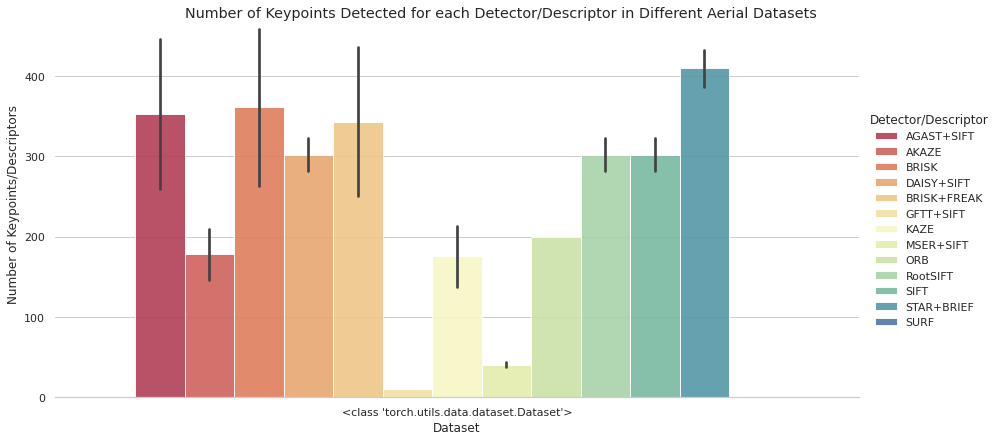

In [213]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_15, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [214]:
df_numkey_15.to_csv(f'drive/MyDrive/Num_Kypoints_15_{Dataset}.csv')

In [215]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_surf, 'Detector/Descriptor':['AGAST+SIFT']*(len_files-1) + ['AKAZE']*(len_files-1) + ['BRISK']*(len_files-1) + ['DAISY+SIFT']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) + ['GFTT+SIFT']*(len_files-1) + ['KAZE']*(len_files-1) + ['MSER+SIFT']*(len_files-1) + ['ORB']*(len_files-1) +['RootSIFT']*(len_files-1) +['SIFT']*(len_files-1) + ['STAR+BRIEF']*(len_files-1) +   ['SURF']*(len_files-1) }
df_match_15 = pd.DataFrame(data=d)
df_match_15['Number of Total Matches'] = df_match_15['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

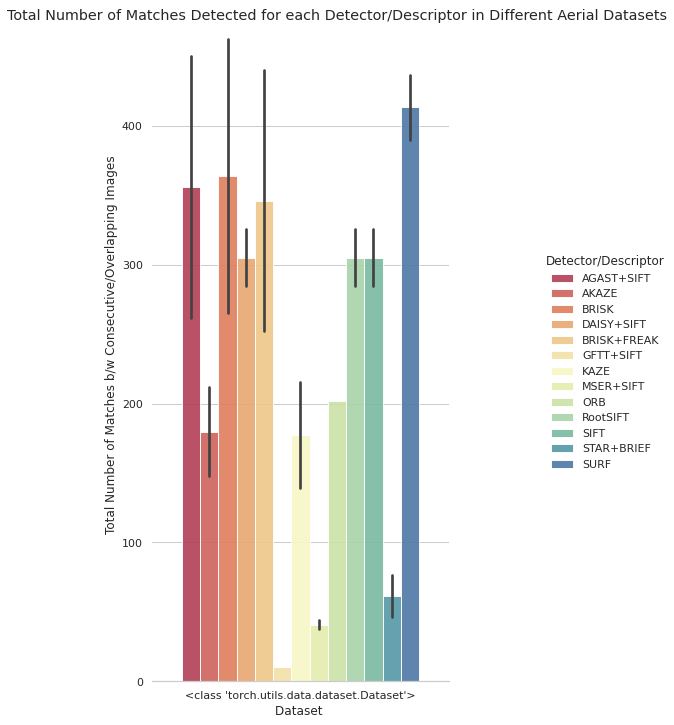

In [216]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [217]:
num_good_matches_mser = [0]*len(num_good_matches_agast)

In [218]:
df_match_15['Number of Good Matches'] = num_good_matches_agast + num_good_matches_akaze + num_good_matches_brisk + num_good_matches_daisy  + num_good_matches_freak + num_good_matches_gftt + num_good_matches_kaze + num_good_matches_mser + num_good_matches_orb + num_good_matches_rootsift + num_good_matches_sift + num_good_matches_briefstar +  num_good_matches_surf
df_match_15['Number of Good Matches'] = df_match_15['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

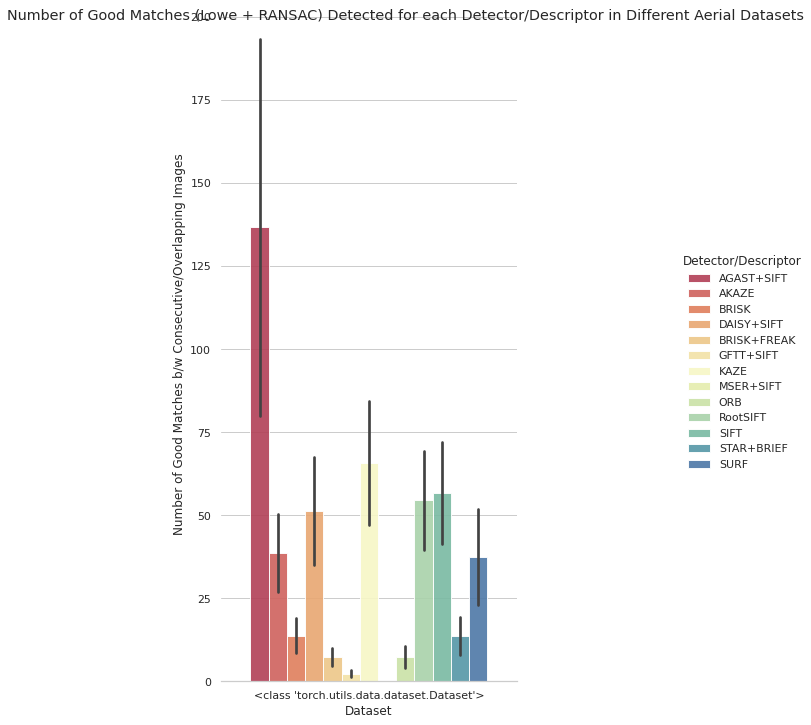

In [219]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [220]:
df_match_15['Recall Rate of Matches'] = df_match_15['Number of Good Matches']/df_match_15['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

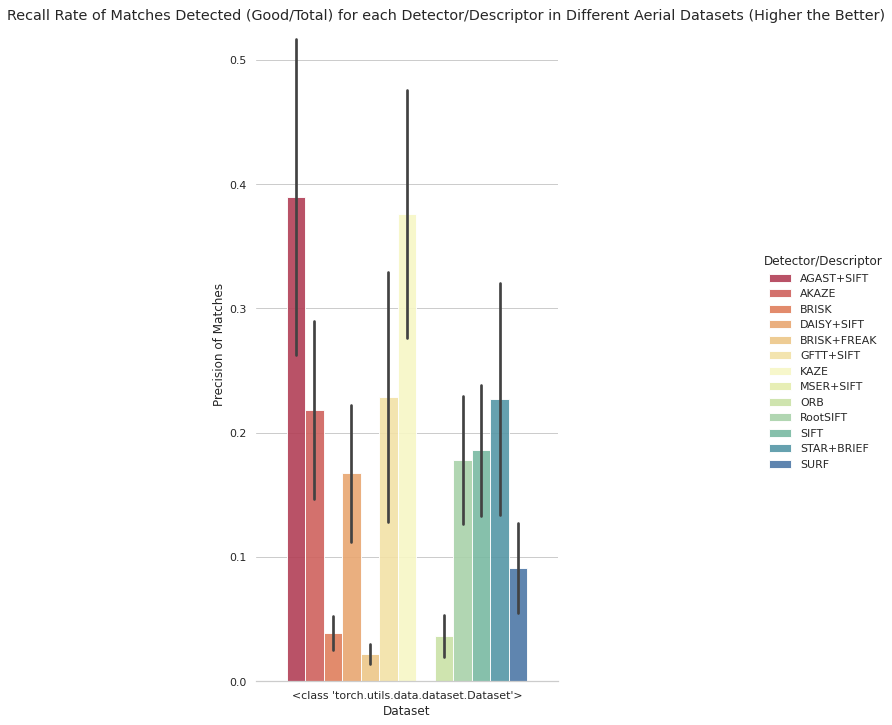

In [221]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [222]:
df_match_15['1 - Precision Rate of Matches'] = (df_match_15['Number of Total Matches'] - df_match_15['Number of Good Matches'])/df_match_15['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

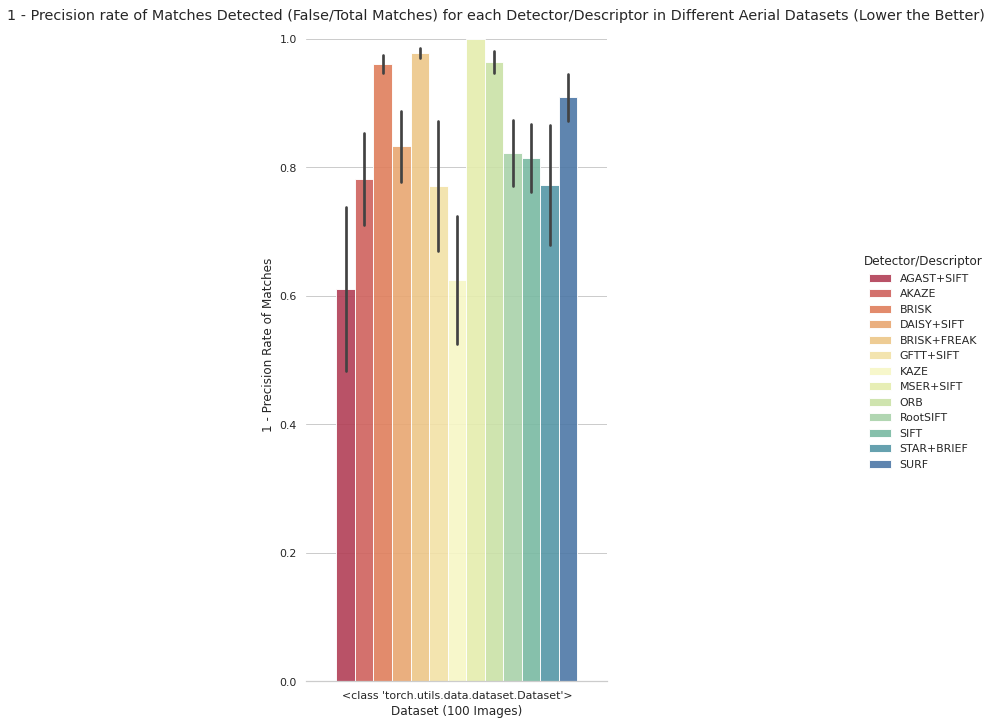

In [223]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (100 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [224]:
df_match_15['F-Score'] = (2* (1 - df_match_15['1 - Precision Rate of Matches']) * df_match_15['Recall Rate of Matches'])/((1 - df_match_15['1 - Precision Rate of Matches']) + df_match_15['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

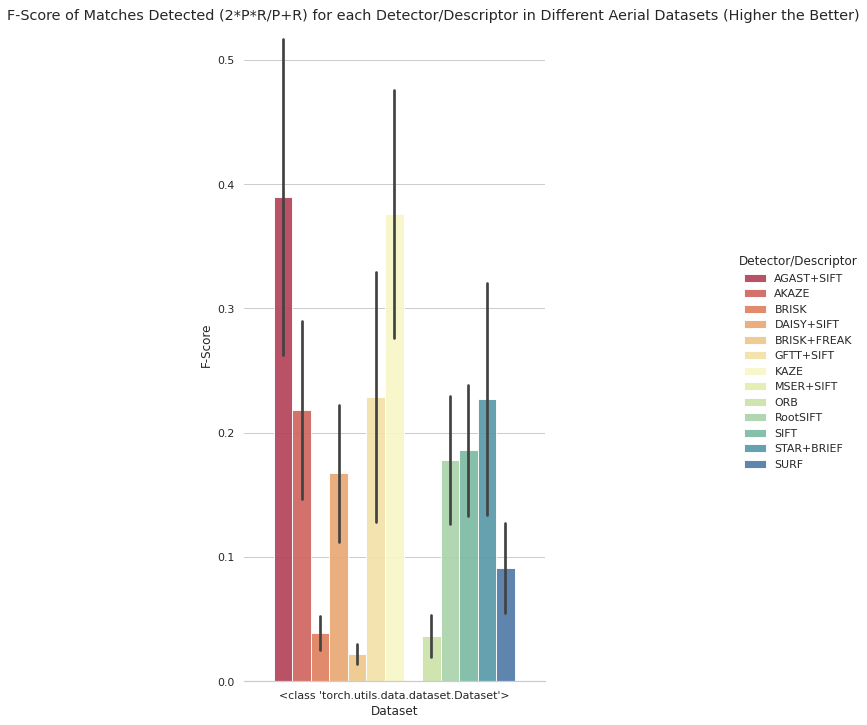

In [225]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_15, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [226]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time':  [time_all[0]] + [time_all[1]] + [time_all[2]] + [time_all[3]] + [time_all[4]] + [time_all[5]] + [time_all[6]] + [time_all[7]] + [time_all[8]] + [time_all[9]] + [time_all[10]] + [time_all[11]] + [time_all[12]] , 'Detector/Descriptor':['AGAST+SIFT'] + ['AKAZE'] + ['BRISK']*(1) + ['DAISY+SIFT']*(1) + ['BRISK+FREAK']*(1) + ['GFTT+SIFT']*(1) + ['KAZE']*(1) + ['MSER+SIFT']*(1) + ['ORB']*(1) +['RootSIFT']*(1) +['SIFT']*(1) + ['STAR+BRIEF']*(1) + ['SURF']*(1)} 
df_time_15 = pd.DataFrame(data=d)

Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

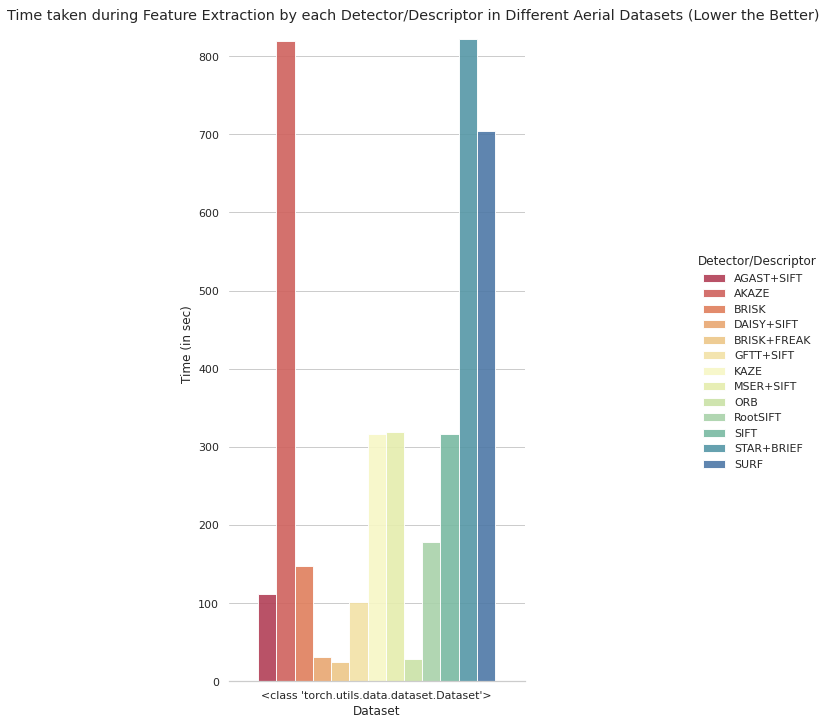

In [227]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_15, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")